In [1]:
#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table
from astropy import units as u

# Dlnpyutils and ages
from dlnpyutils.utils import bspline,mad,interp
import dlnpyutils.robust as robust
import ages as ages

# dust_extinction
from dust_extinction.parameter_averages import CCM89,O94,F99,VCG04,GCC09,M14,F19,D22

# functools
from functools import partial

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
matplotlib.rcParams.update({'font.size': 25,'axes.facecolor':'w'})
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

#Numpy/Scipy
import numpy as np
import scipy
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

# pdb
import pdb

# tqdm 
from tqdm.notebook import tqdm

In [2]:
def closest(data,value):
    '''
    Find nearest value in array to given value

    Inputs:
    ------
        data:  array-like
               data to search through

        value: float or int
               value of interest

    Output:
    ------
        close: float or int
               value in data closest to given value
    '''

    data = np.asarray(data)

    return data[(np.abs(np.subtract(data,value))).argmin()]

def sfdebv_2_ext(ebv,wave):
    '''
    Convert Schlegel Reddening to extinction using Schlafly et al. 2010 and Fitzpatrick 1999
    
    Inputs:
    ------
        ebv:  float
              Schlegel E(B-V) value
              
        wave: float
              wavelength of band to calculate extinction in mircons
        
    Output:
    ------
        ext:  float
              extinction in the band with the effective wavelength of wave
    '''
    
    micron_ext = (0.78/1.32)*ebv # Schlafly et al. 2010
    ext = f99(wave)/f99(1)*micron_ext # Fitzpatrick 1999
    return ext

import astropy.units as u
def convert_sfdebv(wave,ebv,rv=3.1):
    '''
    Convert Schlegel Reddening to extinction using Schlafly et al. 2010
    
    Inputs:
    ------
        wave: wavelength of band to calculate extinction in mircons
        ebv: Schlegel E(B-V) value
        
    Output:
    ------
        new_extinction: extinction in the band with the effective wavelength of wave
    '''
    
    micron_extinction = (0.78/1.32)*ebv
    fitz = F99(Rv=rv)
    return fitz(1/(wave*u.micron))/fitz(1*u.micron)*micron_extinction

import astropy.units as u
from dust_extinction.parameter_averages import CCM89,O94,F99,VCG04,GCC09,M14,F19,D22

def extcoeff(wavelength,rv=3.1,law='CCM89',ref='G'):

    '''
    Calculate the relative extincion law coefficients for a given wavelength relative to the 
    BP, G, RP, J, H, K or user defined band

    Input:
    -----
        wavelength: float
                    Effective wavelength of band of interest in microns
        
        law:        str
                    extinction law to use
                         
                    Available Extinction Laws: 
                    -------------------------
                        
                    CCM89 - Cardelli, Clayton, & Mathis 1989
                    O94 - O'Donnell 1994
                    F99 - Fitzpatrick 1999
                    F04 - Fitzpatrick 2004
                    VCG04 - Valencic, Clayton, & Gordon 2004
                    GCC09 - Grodon, Cartledge, & Clayton 2009
                    M14 - Maiz Apellaniz et al 2014
                    F19 - Fitzpatrick, Massa, Gordon, Bohlin & Clayton 2019
                    D22 - Decleir et al. 2022

        rv:         float
                    Rv (=Av/E(B-V)) extinction law slope. Default is 3.1
        
        ref:        str or float
                    reference filter. Can be 'BP', 'G', 'RP', 'J', 'H', 'K' 
                    or user defined float that is the wavelength in microns of the band

    Output:
    ------
        ext_coeff:  float
                    calculated extinction coefficients for the BP, G, RP, J, H, and K bands 
                    relative to the Gaia G band

    '''

    leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}
    
    # select the extinction model
    if law == 'CCM89':
        ext_model = CCM89(Rv=rv)

    elif law == 'O94':
        ext_model = O94(Rv=rv)

    elif law == 'F99':
        ext_model = F99(Rv=rv)

    elif law == 'F04':
        ext_model = F04(Rv=rv)

    elif law == 'VCG04':
        ext_model = VCG04(Rv=rv)

    elif law == 'GCC09':
        ext_model = GCC09(Rv=rv)

    elif law == 'M14':
        ext_model = M14(Rv=rv)

    elif law == 'F19':
        ext_model = F19(Rv=rv)

    elif law == 'D22':
        ext_model = D22(Rv=rv)   

    # Calculate the relative extinction coefficient
    if type(ref) == str:
        ext_coeff = ext_model(wavelength*u.micron)/ext_model(leff[ref]*u.micron)
    
    elif type(ref) == float:
        ext_coeff = ext_model(wavelength*u.micron)/ext_model(ref*u.micron)
    
    return ext_coeff

### Geometry

import MagellanicStream as MagellanicStream

def LMCdisk_cart(ra, dec):
    
    '''
    Calculate the position of stars in the LMC disk plane with 
    center at the LMC center in cartesian coordinates (x, y).
    This also calculates the distance to the individual stars.
    
    This follows van der Marel and Cioni 2001 with parameters from Choi et al. 2018 (SMASHing the LMC: 
    Mapping a Ring-like Stellar Overdensity in the LMC Disk)
    
    Input
    - ra: right ascension of stars
    - dec: declination of stars
    
    Output
    - x_m: x coordinate
    - y_m: y coordinate
    - dis: distance to LMC star
    '''
    alph0 = np.radians(82.25) #right ascension of center of LMC
    delt0 = np.radians(-69.50) #declination of center of LMC
    pa = np.radians(149.23+90.00) #146.37 #position angle of line of nodes
    io = np.radians(25.86) #27.81 #inclination of LMC disk
    d0 = 49.90 #distance to center of LMC
    
    #convert to radians
    ra = np.radians(ra)
    dec = np.radians(dec)
    sd = np.sin(delt0)
    cd = np.cos(delt0)
    
    cr = cd*np.cos(dec)*np.cos(ra-alph0)+sd*np.sin(dec)
    srcp = -np.cos(dec)*np.sin(ra-alph0)
    srsp = cd*np.sin(dec) - sd*np.cos(dec)*np.cos(ra-alph0)
    dis = d0*np.cos(io)/(np.cos(io)*cr - np.sin(io)*np.cos(pa)*srsp + np.sin(io)*np.sin(pa)*srcp)
    
    x_m = dis*srcp
    y_m = dis*(np.cos(io)*srsp + np.sin(io)*cr) - d0*np.sin(io)
    
    return x_m, y_m, dis

def elliptical_radius(x,y):
    '''
    Calculate elliptical radius from cartesian(x,y) using equation 6 form Choi et al. 2018 (SMASHing the LMC: 
    Mapping a Ring-like Stellar Overdensity in the LMC Disk)
    
    Parameters:
    ----------
        x: x cartesian coordinate
        y: y cartesian coordinate
        psi: semimajor axis position angle
    Returns:
    -------
        ell_r: elliptical radius
    '''
    
    
    b_a = 0.836 # disk axis ratio
    psi = 227.24 + 90 # position angle of semi major axis
    cpsi = np.cos(np.radians(psi)) 
    spsi = np.cos(np.radians(psi))
    
    ell_r = np.sqrt(np.square(x*cpsi-y*spsi) + np.square(b_a*(x*spsi + y*cpsi)))
    
    return ell_r

def superellipse_radius(x,y):
    b_a = 0.836 # disk axis ratio
    psi = 227.24 + 90 # position angle of semi major axis
    c0 = 2.999 # bar shape parameter
    cpsi = np.cos(np.radians(psi)) 
    spsi = np.cos(np.radians(psi))
    
    sell_r = (np.abs(x*cpsi-y*spsi)**c0 + np.abs(b_a*(x*spsi + y*cpsi))**c0)**(1/c0)
    
    return sell_r

# Gaia

In [3]:
mcs = fits.getdata('/Users/joshuapovick/Desktop/Research/LMC_Ages/Age_Fitting/notebooks/lmc_josh.fits.gz')
mcs = mcs[(np.isfinite(mcs['ra'])==True)&(np.isfinite(mcs['dec'])==True)]

# APOGEE LMC 

In [4]:
lmcdr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/lmc_rgbmembers.dr17rev1_qacuts.fits.gz')

apoafe = lmcdr17['ALPHA_M']+lmcdr17['M_H']-lmcdr17['FE_H']
apoafe_err = np.sqrt(lmcdr17['ALPHA_M_ERR']**2+lmcdr17['M_H_ERR']**2+lmcdr17['FE_H']**2)

salfeh = lmcdr17['FE_H']+np.log10(0.659*(10**(apoafe))+0.341)
salfeh_err = np.sqrt(lmcdr17['FE_H_ERR']**2+((1-0.341/(0.659*(10**(apoafe))+0.341))*apoafe_err)**2)

diane = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/output_LMC_DR16_all.fits.gz')

_, diane_idx, me_idx = np.intersect1d(diane['APOGEE_ID'],lmcdr17['APOGEE_ID'], return_indices=True)

In [5]:
### Position/Distances of the LMC stars

from dlnpyutils import coords
import astropy.units as u
from astropy.coordinates import SkyCoord

lmcx, lmcy, lmcdis = LMCdisk_cart(lmcdr17['RA'], lmcdr17['DEC'])
lmcr = elliptical_radius(lmcx,lmcy)
lmcsr = superellipse_radius(lmcx,lmcy)

### lmcdr17
gc = SkyCoord(ra=lmcdr17['RA']*u.degree, dec=lmcdr17['DEC']*u.degree, frame='icrs')
lms_lmc,bms_lmc = coords.gal2mag(gc.galactic.l.value,gc.galactic.b.value)

for i in range(len(lms_lmc)):
    if lms_lmc[i] > 180.:
        lms_lmc[i] = lms_lmc[i]-360
        
gaiax, gaiay, gaiadis = LMCdisk_cart(mcs['ra'], mcs['dec'])

gaiar = elliptical_radius(gaiax,gaiay)
gaiasr = superellipse_radius(gaiax,gaiay)

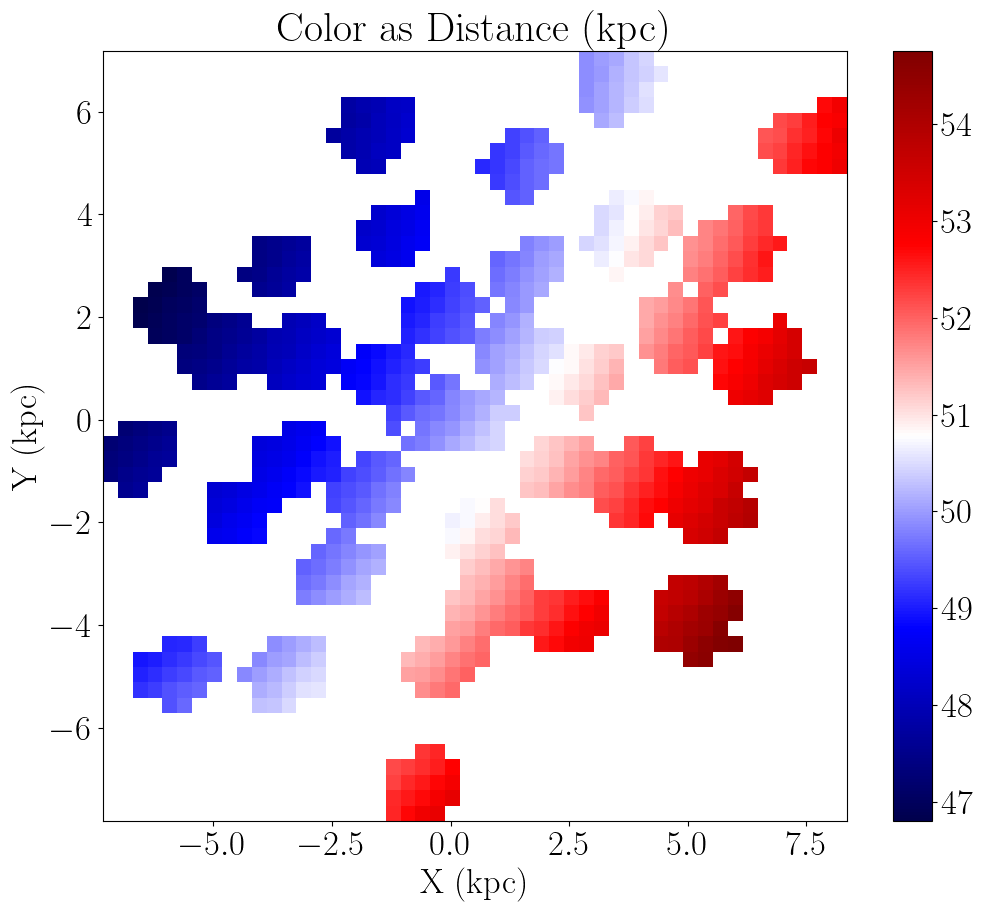

In [6]:
from scipy.stats import binned_statistic_2d

plt.figure(figsize=[12,10])
ret = binned_statistic_2d(lmcx,lmcy,lmcdis,'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='seismic')
plt.colorbar()

# plt.gca().invert_xaxis()

plt.title(r'Color as Distance (kpc)')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')
# plt.savefig('../plots/lmc_map_distance.png',dpi=300,bbox_inches='tight')
plt.show()

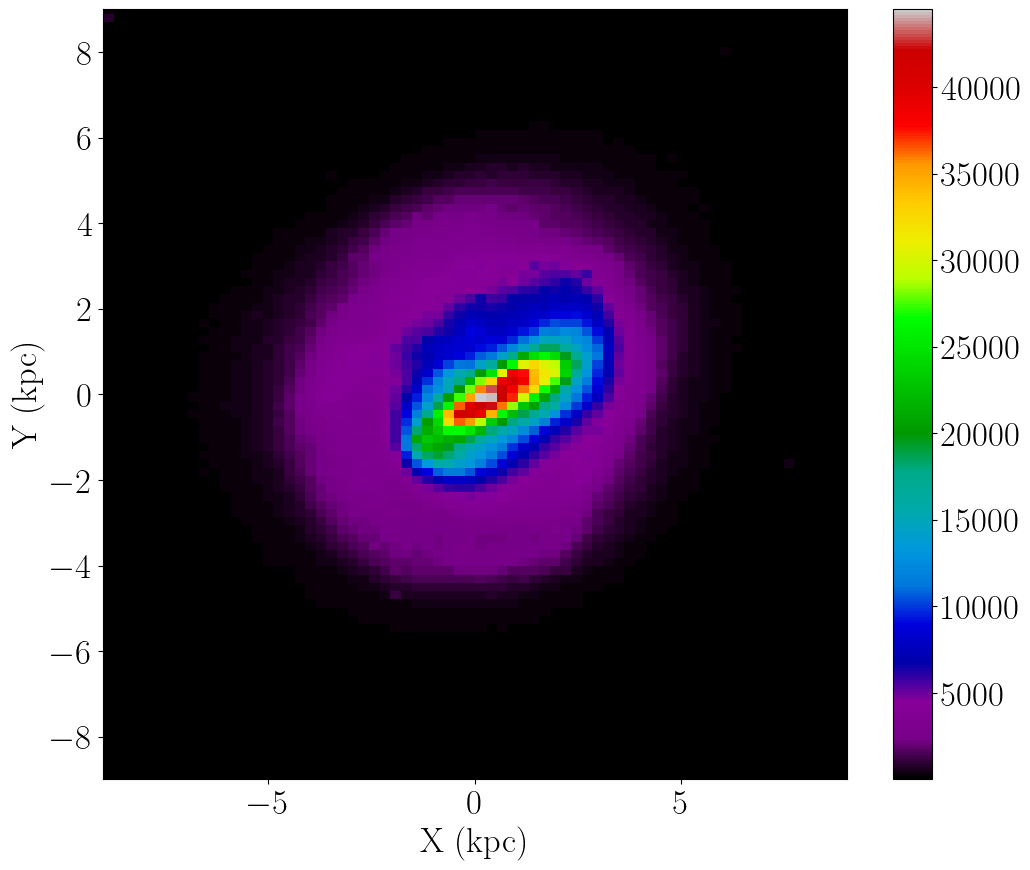

In [7]:
plt.figure(figsize=[12,10])
ret = binned_statistic_2d(gaiax,gaiay,gaiax,'count',bins=500)
ret.statistic[ret.statistic==0] = np.nan
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='nipy_spectral',alpha=1)
plt.colorbar()

# plt.scatter(lmcx,lmcy,s=10)

plt.xlim(-9,9)
plt.ylim(-9,9)

# plt.gca().invert_xaxis()

# plt.title(r'Color as Distance (kpc)')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')
# plt.savefig('../plots/lmc_map_distance.png',dpi=300,bbox_inches='tight')
plt.show()

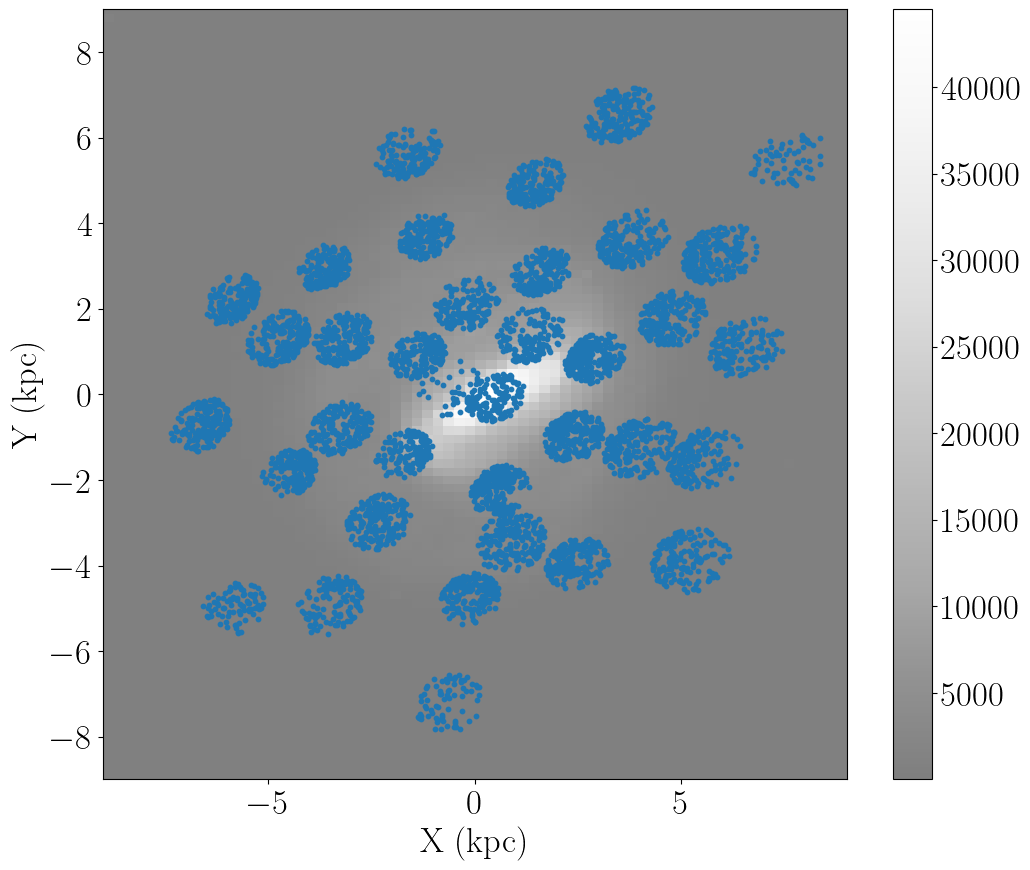

In [8]:
plt.figure(figsize=[12,10])
ret = binned_statistic_2d(gaiax,gaiay,gaiax,'count',bins=500)
ret.statistic[ret.statistic==0] = np.nan
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='Greys_r',alpha=0.5)
plt.colorbar()

plt.scatter(lmcx,lmcy,s=10)

plt.xlim(-9,9)
plt.ylim(-9,9)

# plt.gca().invert_xaxis()

# plt.title(r'Color as Distance (kpc)')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')
# plt.savefig('../plots/lmc_map_distance.png',dpi=300,bbox_inches='tight')
plt.show()

# Calculated Age Read in 

In [9]:
agetab = Table.read('lmc_lm_wgtage_21OCT2022.fits')

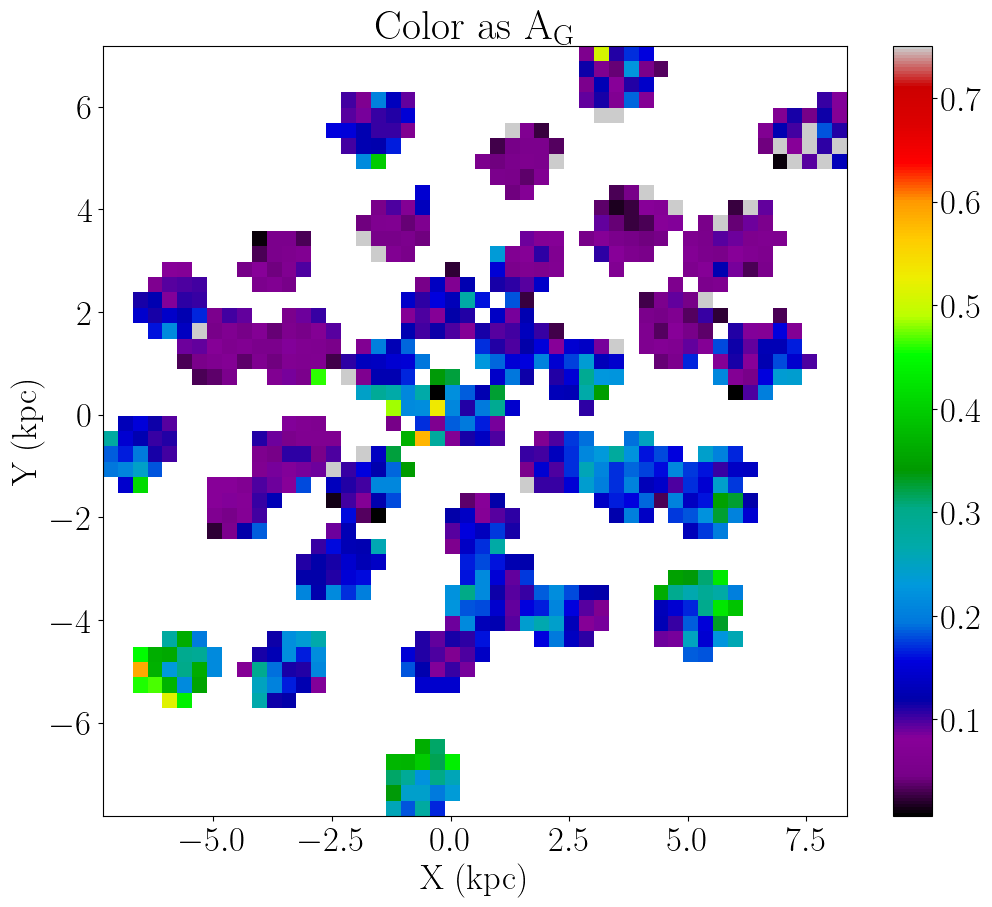

In [10]:
plt.figure(figsize=[12,10])
ret = binned_statistic_2d(lmcx,lmcy,agetab['EXT'][:,1],'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='nipy_spectral',vmax=0.75)
plt.colorbar()

plt.title(r'Color as A$_{\rm G}$')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')
# plt.savefig('lmc_map_ag.png',dpi=300,bbox_inches='tight')
plt.show()

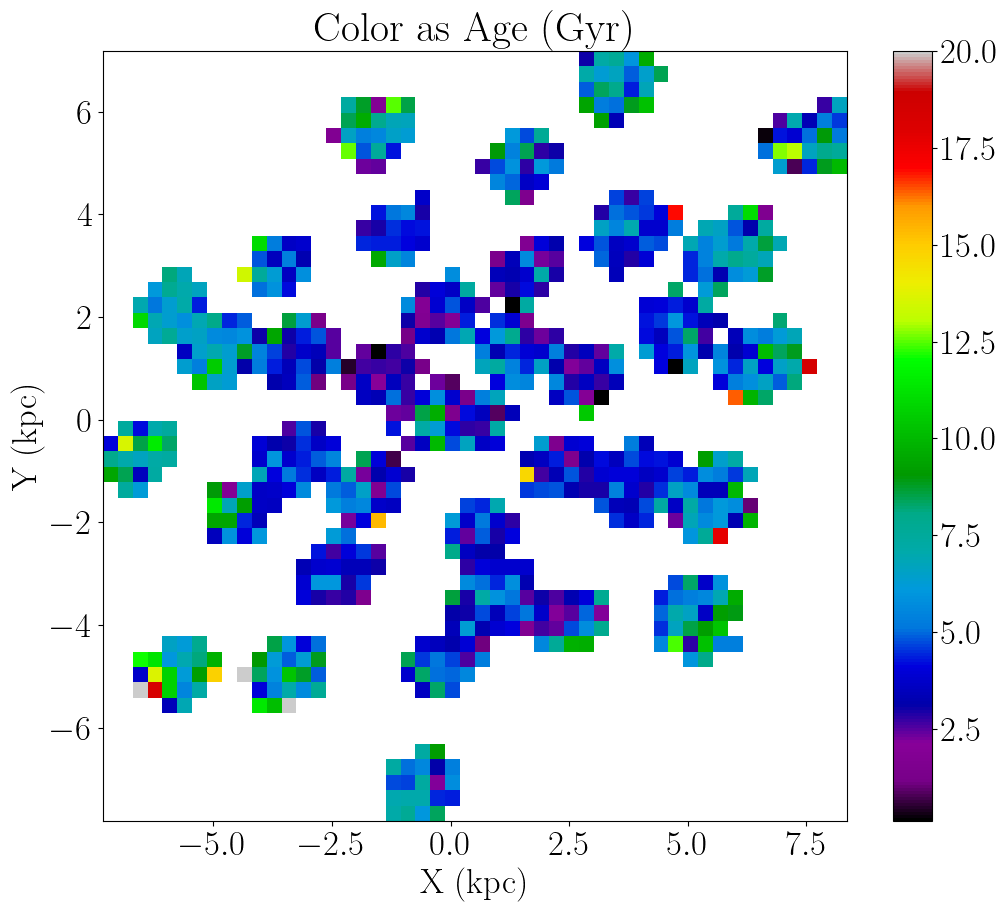

In [11]:
plt.figure(figsize=[12,10])
ret = binned_statistic_2d(lmcx,lmcy,agetab['AGE'],'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='nipy_spectral',vmax=20)
plt.colorbar()

plt.title(r'Color as Age (Gyr)')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')
# plt.savefig('../plots/lmc_map_age.png',bbox_inches='tight')
plt.show()

In [12]:
med_fld_age = 999999.0*np.ones(len(np.unique(lmcdr17['FIELD'])))
mad_fld_age = 999999.0*np.ones(len(np.unique(lmcdr17['FIELD'])))

fld_centers = 999999.0*np.ones((len(np.unique(lmcdr17['FIELD'])),2))

fld_radius = 999999.0*np.ones(len(np.unique(lmcdr17['FIELD'])))

fld_feh = 999999.0*np.ones(len(np.unique(lmcdr17['FIELD'])))
fld_feh_mad = 999999.0*np.ones(len(np.unique(lmcdr17['FIELD'])))

fld_pa = 999999.0*np.ones(len(np.unique(lmcdr17['FIELD'])))

for i in range(len(np.unique(lmcdr17['FIELD']))):
    fld, = np.where(lmcdr17['FIELD']==np.unique(lmcdr17['FIELD'])[i])
    
    med_fld_age[i] = np.nanmedian(agetab['AGE'][fld])
    mad_fld_age[i] = mad(agetab['AGE'][fld])
    
    medx = np.nanmedian(lmcx[fld])
    medy = np.nanmedian(lmcy[fld])
    
    fld_centers[i,0] = medx
    fld_centers[i,1] = medy
    
    fld_radius[i] = np.nanmedian(lmcr[fld])
    
    fld_feh[i] = np.nanmedian(lmcdr17['FE_H'][fld]) 
    fld_feh_mad[i] = mad(lmcdr17['FE_H'][fld]) 
    fld_pa[i] = np.nanmedian(lmcdr17['LMCPA'][fld]) 

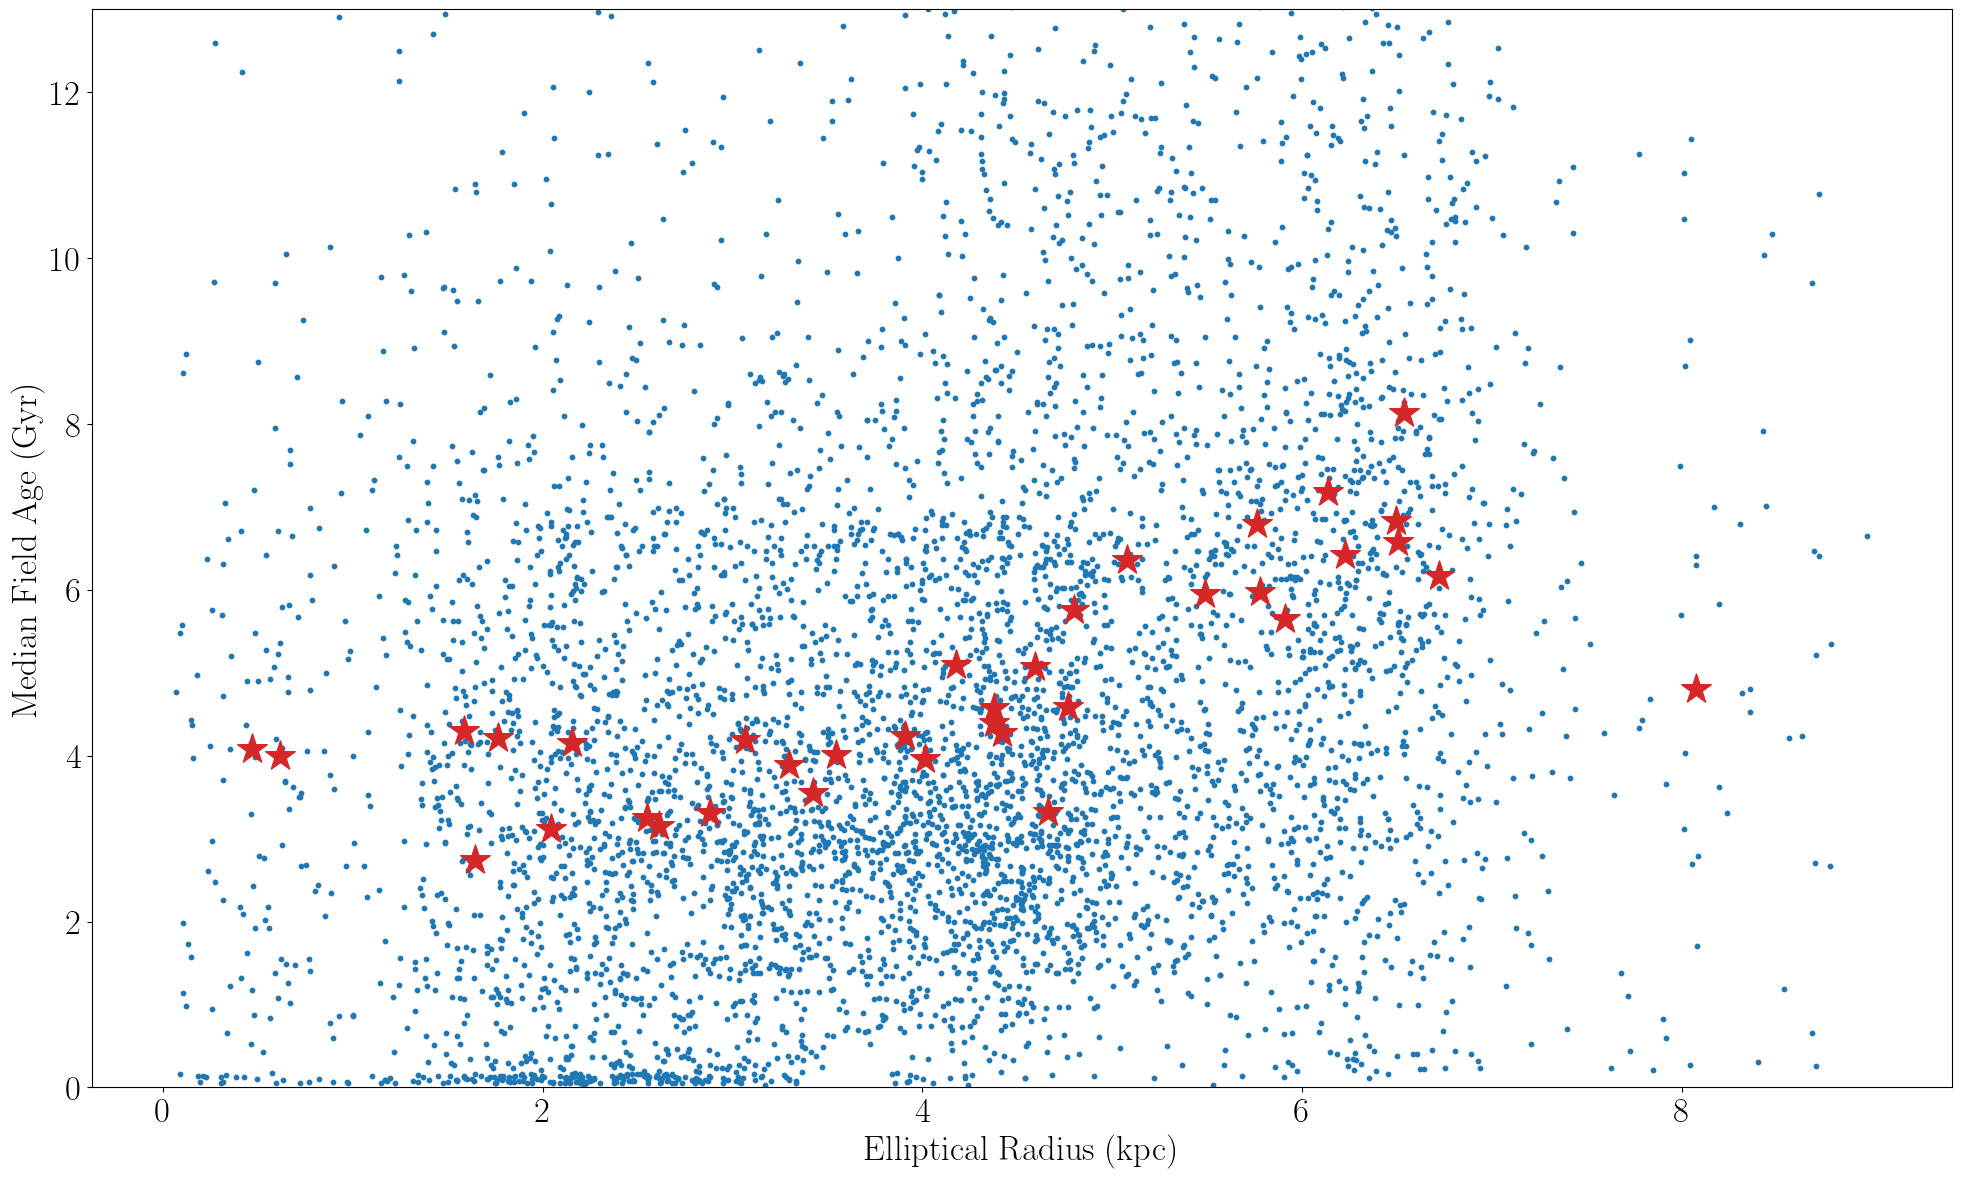

In [13]:
plt.figure(figsize=[24,14])
plt.scatter(lmcr,agetab['AGE'],c='tab:blue',s=10)
plt.scatter(fld_radius,med_fld_age,c='tab:red',marker='*',s=500)
# plt.plot(center_rad_bins,bin_stats,c='k',lw=3)
plt.ylim(0,13)
plt.xlabel(r'Elliptical Radius (kpc)')
plt.ylabel(r'Median Field Age (Gyr)')
# plt.savefig('lmc_fld_age_radius.png',bbox_inches='tight')
plt.show()

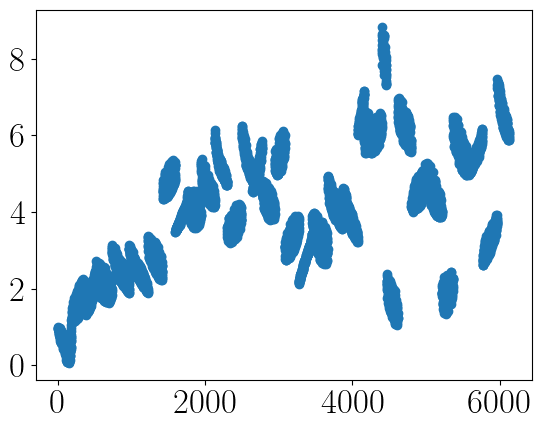

In [14]:
plt.scatter(range(len(lmcsr)),lmcsr)

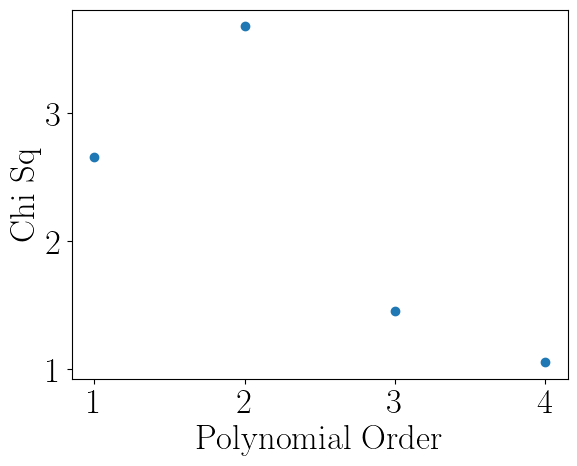

In [15]:
chi_sq = []

sidx = np.argsort(fld_radius)
for i in range(5)[1:]:
    
    p = np.poly1d(robust.polyfit(fld_radius[sidx],med_fld_age[sidx],i))
    
    chi_sq.append(sum(np.square(np.divide(med_fld_age[sidx]-p(fld_radius[sidx]),mad_fld_age[sidx])))) #/(len(fld_radius[:-1]-(i+1))))
    
chi_sq = np.array(chi_sq)
    
plt.scatter(np.arange(len(chi_sq))+1,chi_sq)
plt.xlabel(r'Polynomial Order')
plt.ylabel(r'Chi Sq')
# plt.savefig(r'chisq_age_radius_polyfit.png',bbox_inches='tight')
plt.show()

         4          3         2
-0.0221 x + 0.2865 x - 1.009 x + 0.9739 x + 3.778


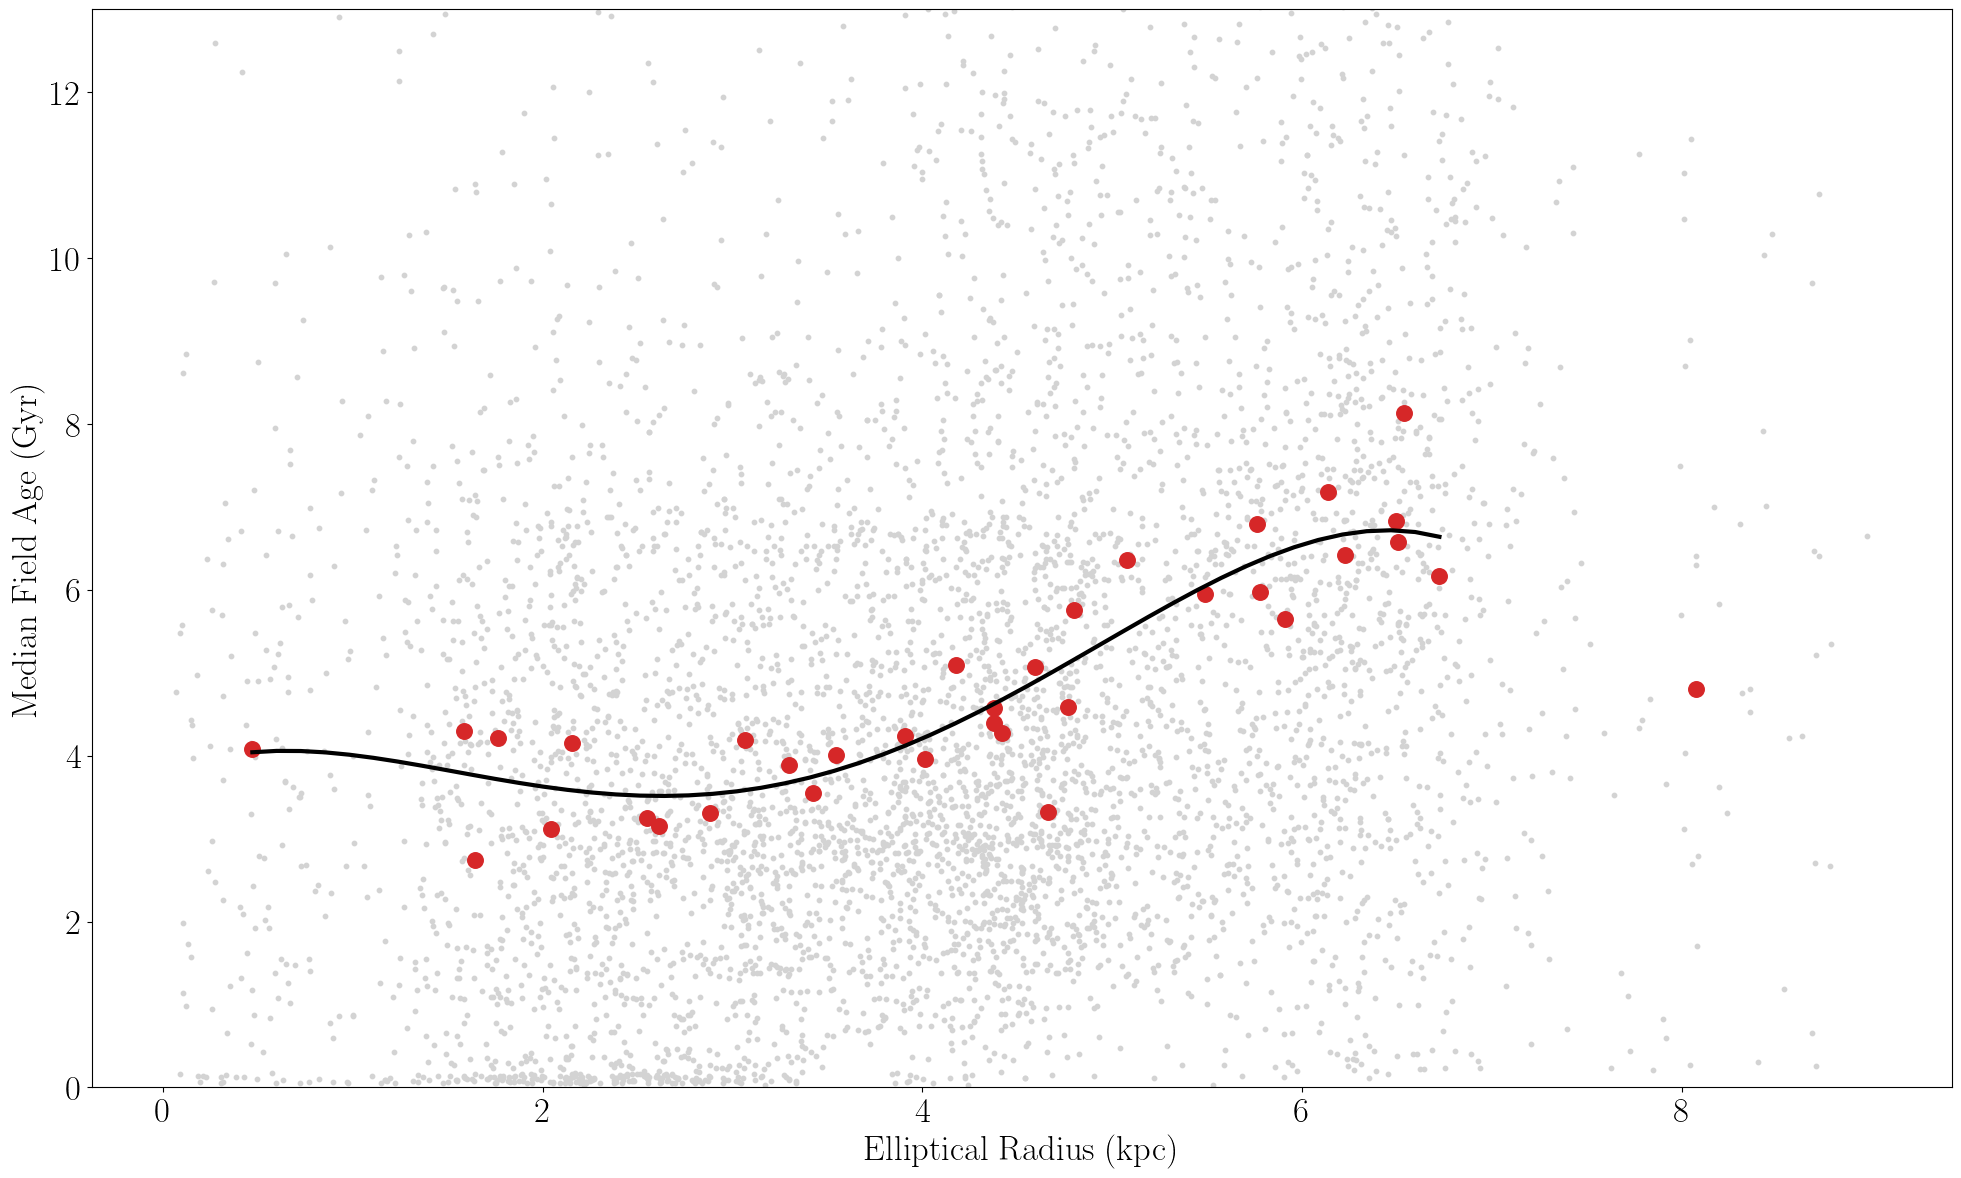

In [16]:
p_raw = np.poly1d(robust.polyfit(fld_radius[fld_radius<8],med_fld_age[fld_radius<8],4))
print(p_raw)

plt.figure(figsize=[24,14])
plt.scatter(lmcr,agetab['AGE'],c='lightgray',s=10)
plt.scatter(fld_radius[:-1],med_fld_age[:-1],c='tab:red',marker='.',s=500)
xs_rads = np.linspace(min(fld_radius[np.argsort(fld_radius)][:-1]),max(fld_radius[np.argsort(fld_radius)][:-1]))
plt.plot(xs_rads,p_raw(xs_rads),c='k',lw=3)
plt.ylim(0,13)
plt.xlabel(r'Elliptical Radius (kpc)')
plt.ylabel(r'Median Field Age (Gyr)')
# plt.savefig('lmc_fld_age_radius_w_poly.png',bbox_inches='tight')
plt.show()

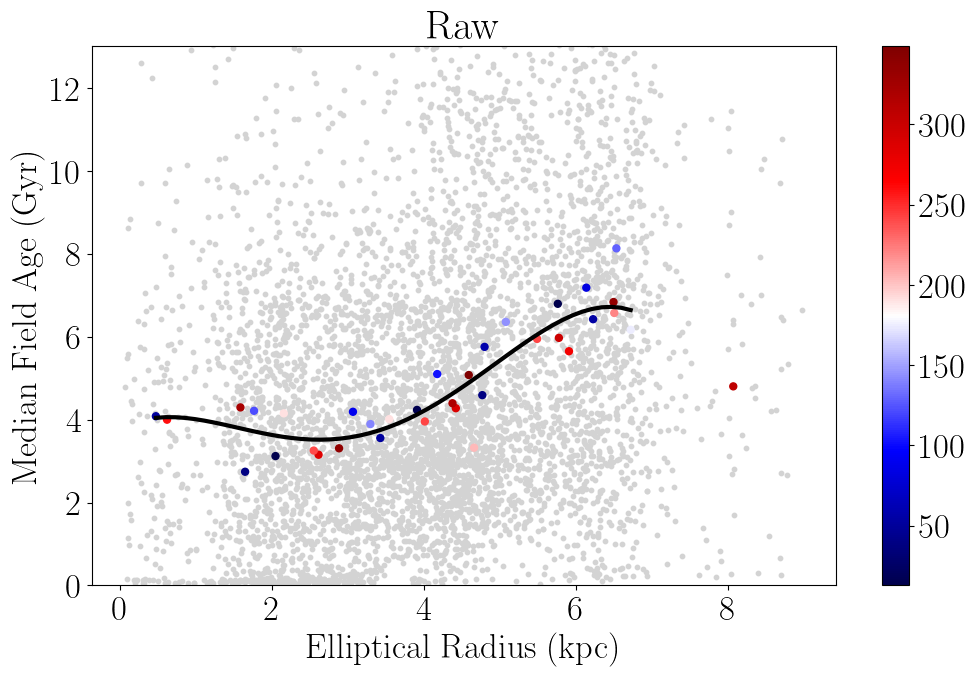

In [17]:
plt.figure(figsize=[12,7])
plt.scatter(lmcr,agetab['AGE'],c='lightgray',s=10)
plt.scatter(fld_radius,med_fld_age,c=fld_pa,marker='.',s=100,cmap='seismic')
# plt.scatter(fld_radius[south_fld],med_fld_age[south_fld],c=fld_pa[south_fld],marker='v',s=100,cmap='twilight_shifted',label='South')
plt.colorbar()
# plt.legend()
xs_rads = np.linspace(min(fld_radius[np.argsort(fld_radius)][:-1]),max(fld_radius[np.argsort(fld_radius)][:-1]))
plt.plot(xs_rads,p_raw(xs_rads),c='k',lw=3)
plt.ylim(0,13)
plt.title(r'Raw')
plt.xlabel(r'Elliptical Radius (kpc)')
plt.ylabel(r'Median Field Age (Gyr)')
# plt.savefig('lmc_fld_age_radius_w_poly.png',bbox_inches='tight')
plt.show()

# subract poly from points and plot on sky or you could plot res vs pa color coded by radius

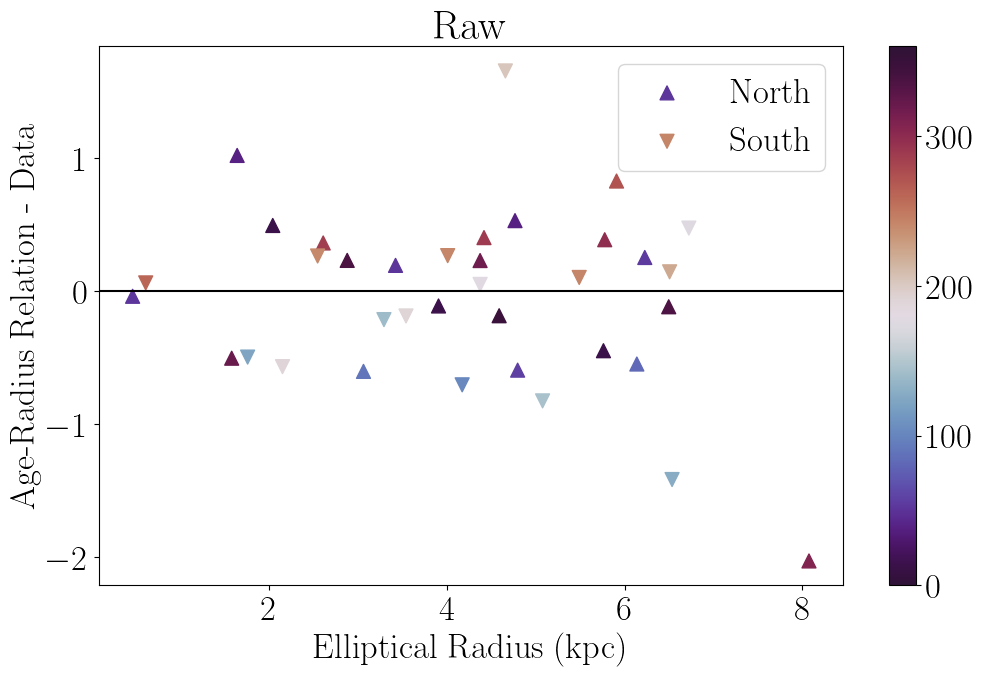

In [18]:
north_fld, = np.where((fld_pa<=90.)|(fld_pa>=270.))
south_fld, = np.where((fld_pa>90.)&(fld_pa<270.))

raw_res_fld_age = p_raw(fld_radius)-med_fld_age

plt.figure(figsize=[12,7])
plt.scatter(fld_radius[north_fld],raw_res_fld_age[north_fld],c=fld_pa[north_fld],marker='^',s=100,cmap='twilight_shifted',vmin=0,vmax=360,label='North')
plt.scatter(fld_radius[south_fld],raw_res_fld_age[south_fld],c=fld_pa[south_fld],marker='v',s=100,cmap='twilight_shifted',vmin=0,vmax=360,label='South')
plt.colorbar()
plt.legend()
plt.axhline(0.0,c='k')

plt.title(r'Raw')
plt.xlabel(r'Elliptical Radius (kpc)')
plt.ylabel(r'Age-Radius Relation - Data')
plt.show()

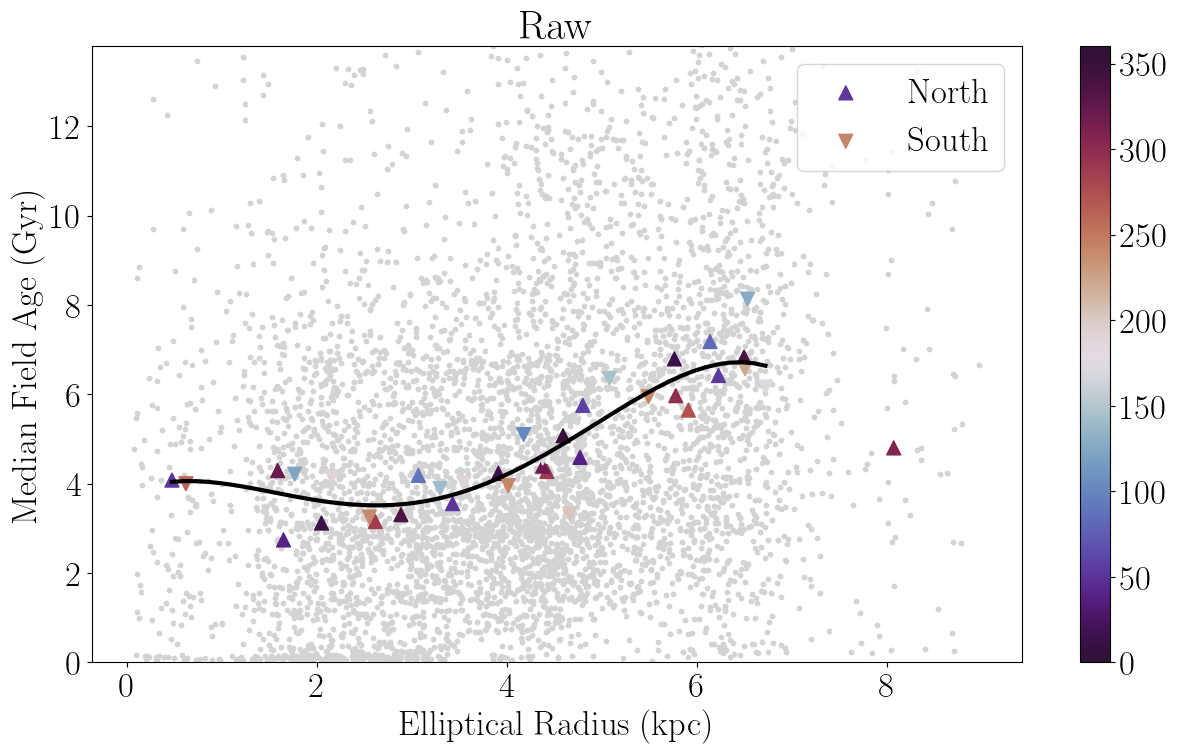

In [19]:
plt.figure(figsize=[15,8])
plt.scatter(lmcr,agetab['AGE'],c='lightgray',s=10)
plt.scatter(fld_radius[north_fld],med_fld_age[north_fld],marker='^',c=fld_pa[north_fld],s=100,label='North',cmap='twilight_shifted',vmin=0,vmax=360)
plt.scatter(fld_radius[south_fld],med_fld_age[south_fld],marker='v',c=fld_pa[south_fld],s=100,label='South',cmap='twilight_shifted',vmin=0,vmax=360)
plt.colorbar()
plt.legend()
xs_rads = np.linspace(min(fld_radius[np.argsort(fld_radius)][:-1]),max(fld_radius[np.argsort(fld_radius)][:-1]))
plt.plot(xs_rads,p_raw(xs_rads),c='k',lw=3)
plt.ylim(0,13.787)
plt.title(r'Raw')
plt.xlabel(r'Elliptical Radius (kpc)')
plt.ylabel(r'Median Field Age (Gyr)')
# plt.savefig('lmc_fld_age_radius_w_poly.png',bbox_inches='tight')
plt.show()

0.29801465472178545


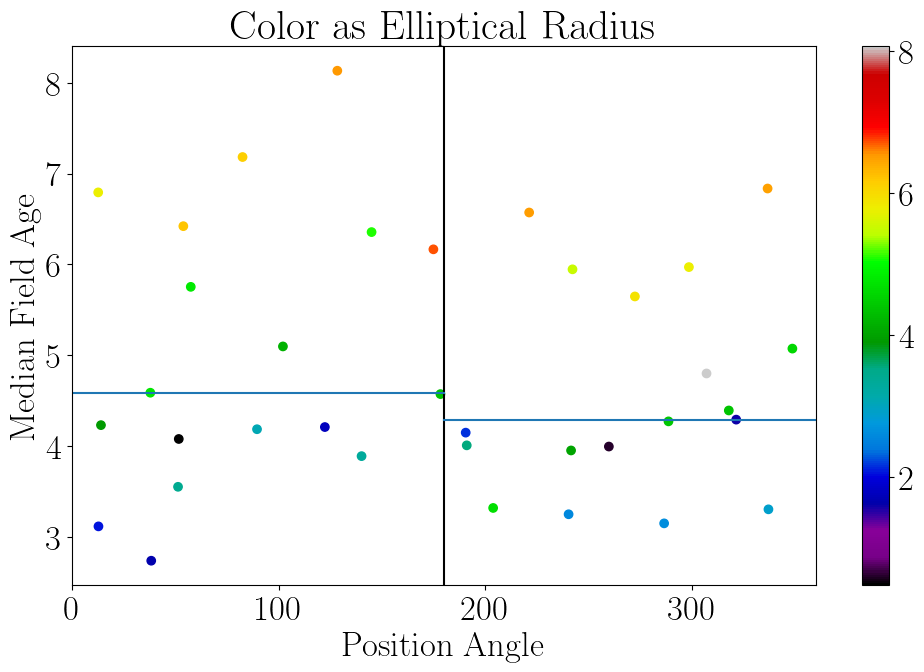

In [20]:
print(np.median(med_fld_age[fld_pa<180])-np.median(med_fld_age[fld_pa>180]))
plt.figure(figsize=[12,7])
plt.scatter(fld_pa,med_fld_age,c=fld_radius,cmap='nipy_spectral')
plt.colorbar()
plt.axvline(180,c='k')

plt.plot([0,180],[np.median(med_fld_age[fld_pa<180]),np.median(med_fld_age[fld_pa<180])],c='tab:blue')
plt.plot([180,360],[np.median(med_fld_age[fld_pa>180]),np.median(med_fld_age[fld_pa>180])],c='tab:blue')

plt.xlim(0,360)
plt.title(r'Color as Elliptical Radius')
plt.xlabel(r'Position Angle')
plt.ylabel(r'Median Field Age')
plt.show()

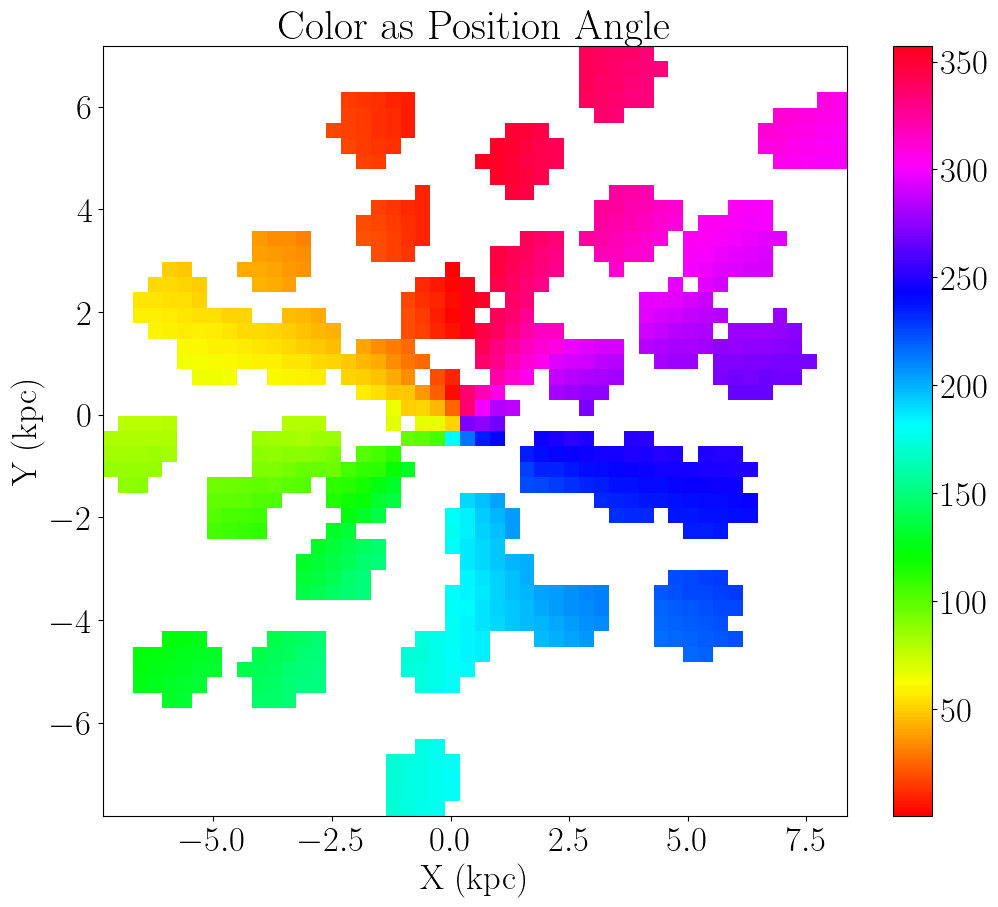

In [21]:
lmc_pa2 = 999999.0*np.ones(len(lmcdr17))

for i in range(len(lmcdr17)):
    rot_pa = lmcdr17['LMCPA'][i]+90.
    
    if rot_pa>360:
        lmc_pa2[i] = rot_pa-360
    else:
        lmc_pa2[i] = rot_pa

plt.figure(figsize=[12,10])
ret = binned_statistic_2d(lmcx,lmcy,lmcdr17['LMCPA'],'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='hsv')
plt.colorbar()

plt.title(r'Color as Position Angle')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')
# plt.savefig('lmc_map_ag.png',dpi=300,bbox_inches='tight')
plt.show()

In [22]:
# p2.deriv().roots

# Median Field Age Map

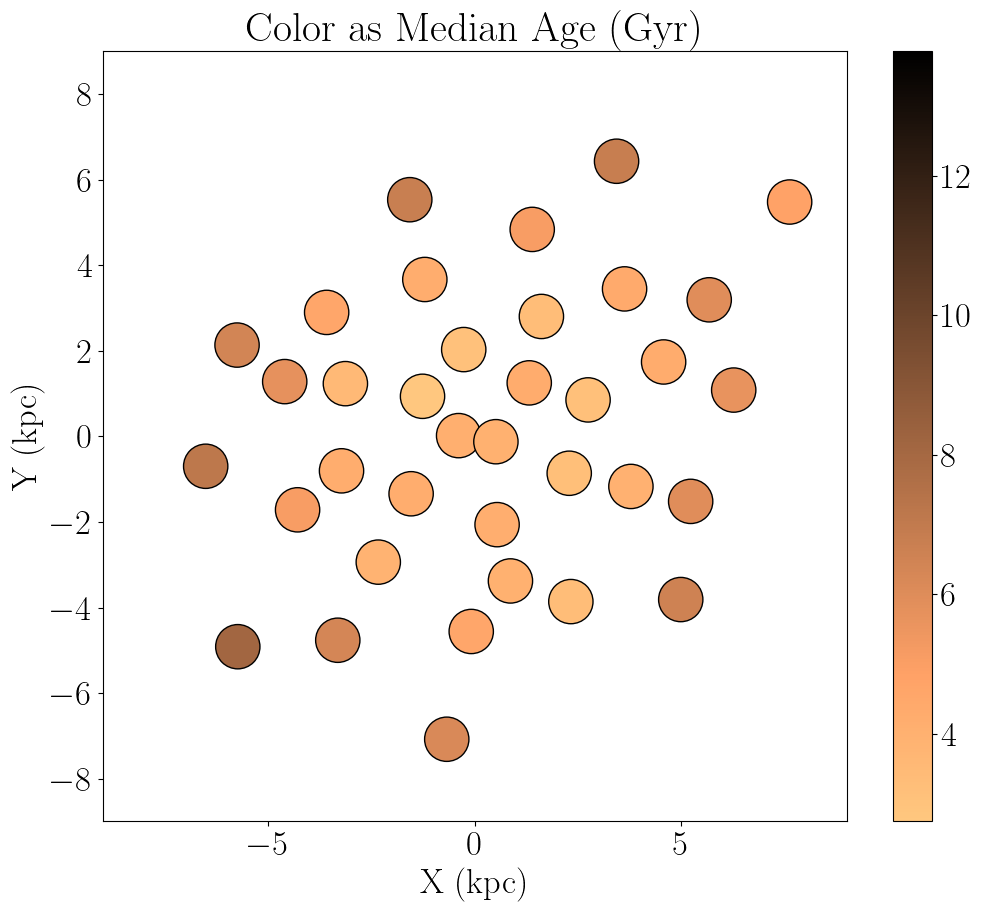

In [23]:
cen_xy = 999999.0*np.zeros((len(np.unique(lmcdr17['FIELD'])),2))

for i in range(len(np.unique(lmcdr17['FIELD']))):
    clus, = np.where(lmcdr17['FIELD']==np.unique(lmcdr17['FIELD'])[i])
    cen_xy[i,0] = np.nanmedian(lmcx[clus])
    cen_xy[i,1] = np.nanmedian(lmcy[clus])

fig, ax = plt.subplots(1,1,figsize=[12,10])
plt.title(r'Color as Median Age (Gyr)')

# set bounds for the plot
ax.set_xlim(-9,9)
ax.set_ylim(-9,9)

# convert 0.8 deg diameter to points and calculate the marker size
r = 49.9*np.tan(np.radians(0.8/2)) #0.8
r_ = ax.transData.transform([r,0])[0] - ax.transData.transform([0,0])[0]
marker_size = np.pi * r_**2

pl = ax.scatter(cen_xy[:,0],cen_xy[:,1],s=marker_size,c=med_fld_age,edgecolors='k',cmap='copper_r',vmax=13.787)
plt.colorbar(pl,ax=ax)

ax.set_xlabel(r'X (kpc)')
ax.set_ylabel(r'Y (kpc)')

# ax.scatter(cen_xy[:,0],cen_xy[:,1],s=marker_size,facecolors='none',edgecolors='k')
plt.show()

In [24]:
select_results = Table.read('lmc_rgbmembers_selectfunc2.fits.gz')

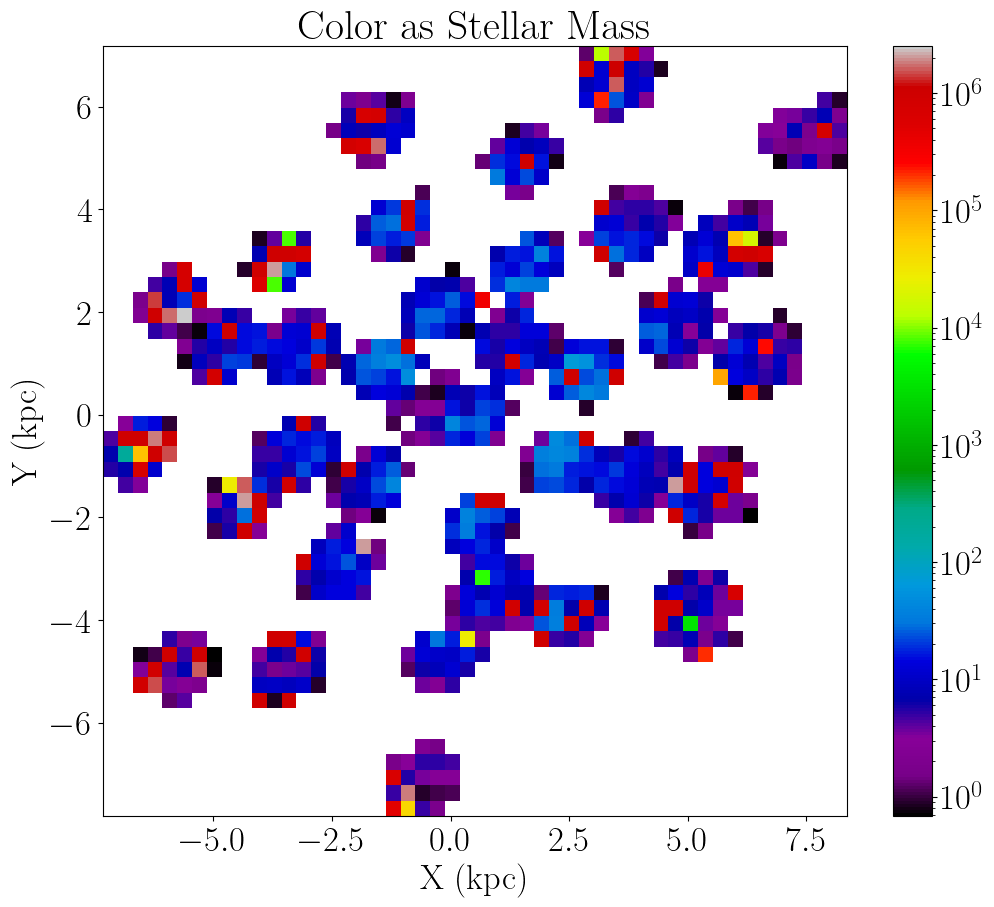

In [25]:
from matplotlib.colors import LogNorm
plt.figure(figsize=[12,10])
raw_mass, = np.where((agetab['MASS']!=999999.0)&(np.isfinite(agetab['MASS'])==True))
ret = binned_statistic_2d(lmcx[raw_mass],lmcy[raw_mass],agetab['MASS'][raw_mass],'sum',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                aspect='auto',interpolation='nearest',cmap='nipy_spectral',norm=LogNorm())
plt.colorbar()

plt.title(r'Color as Stellar Mass')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')
# plt.savefig('lmc_map_ag.png',dpi=300,bbox_inches='tight')
plt.show()

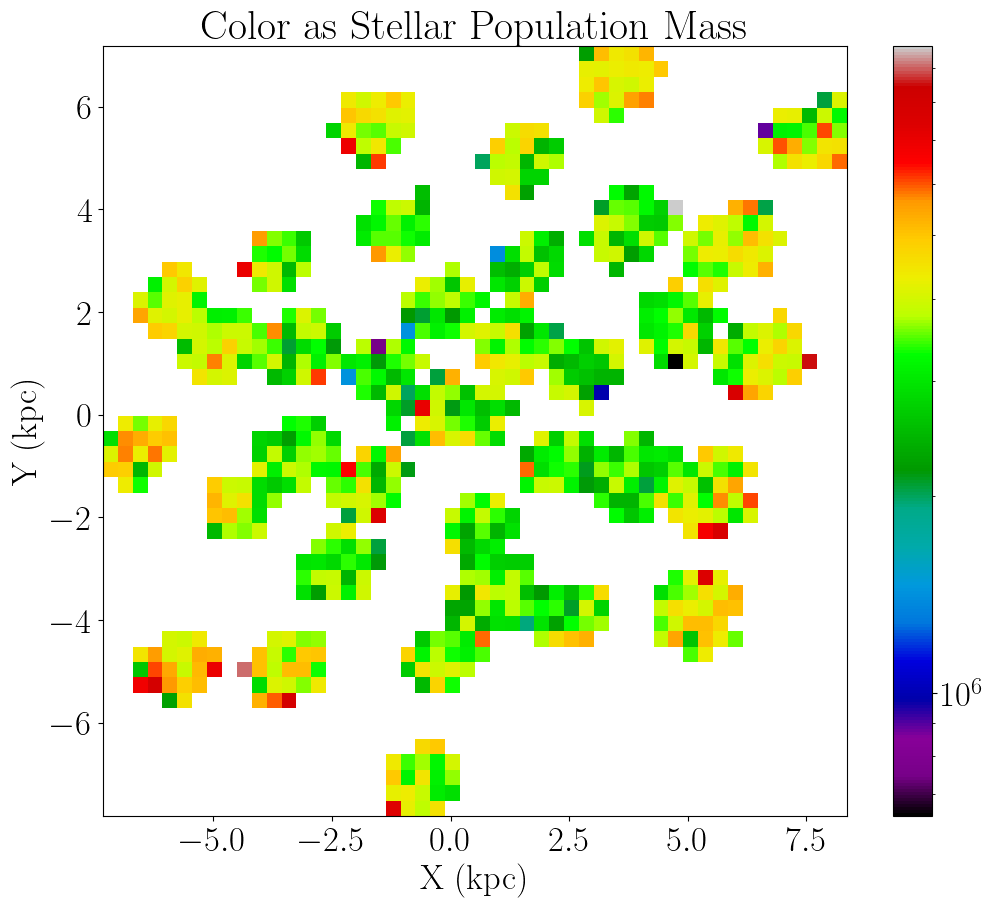

In [26]:
from matplotlib.colors import LogNorm
plt.figure(figsize=[12,10])
unmasked_mass, = np.where(select_results['stellarmass']!=select_results['stellarmass'][6])
ret = binned_statistic_2d(lmcx[unmasked_mass],lmcy[unmasked_mass],select_results['stellarmass'][unmasked_mass],
                          'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                aspect='auto',interpolation='nearest',cmap='nipy_spectral',norm=LogNorm())
plt.colorbar()

plt.title(r'Color as Stellar Population Mass')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')
# plt.savefig('lmc_map_ag.png',dpi=300,bbox_inches='tight')
plt.show()

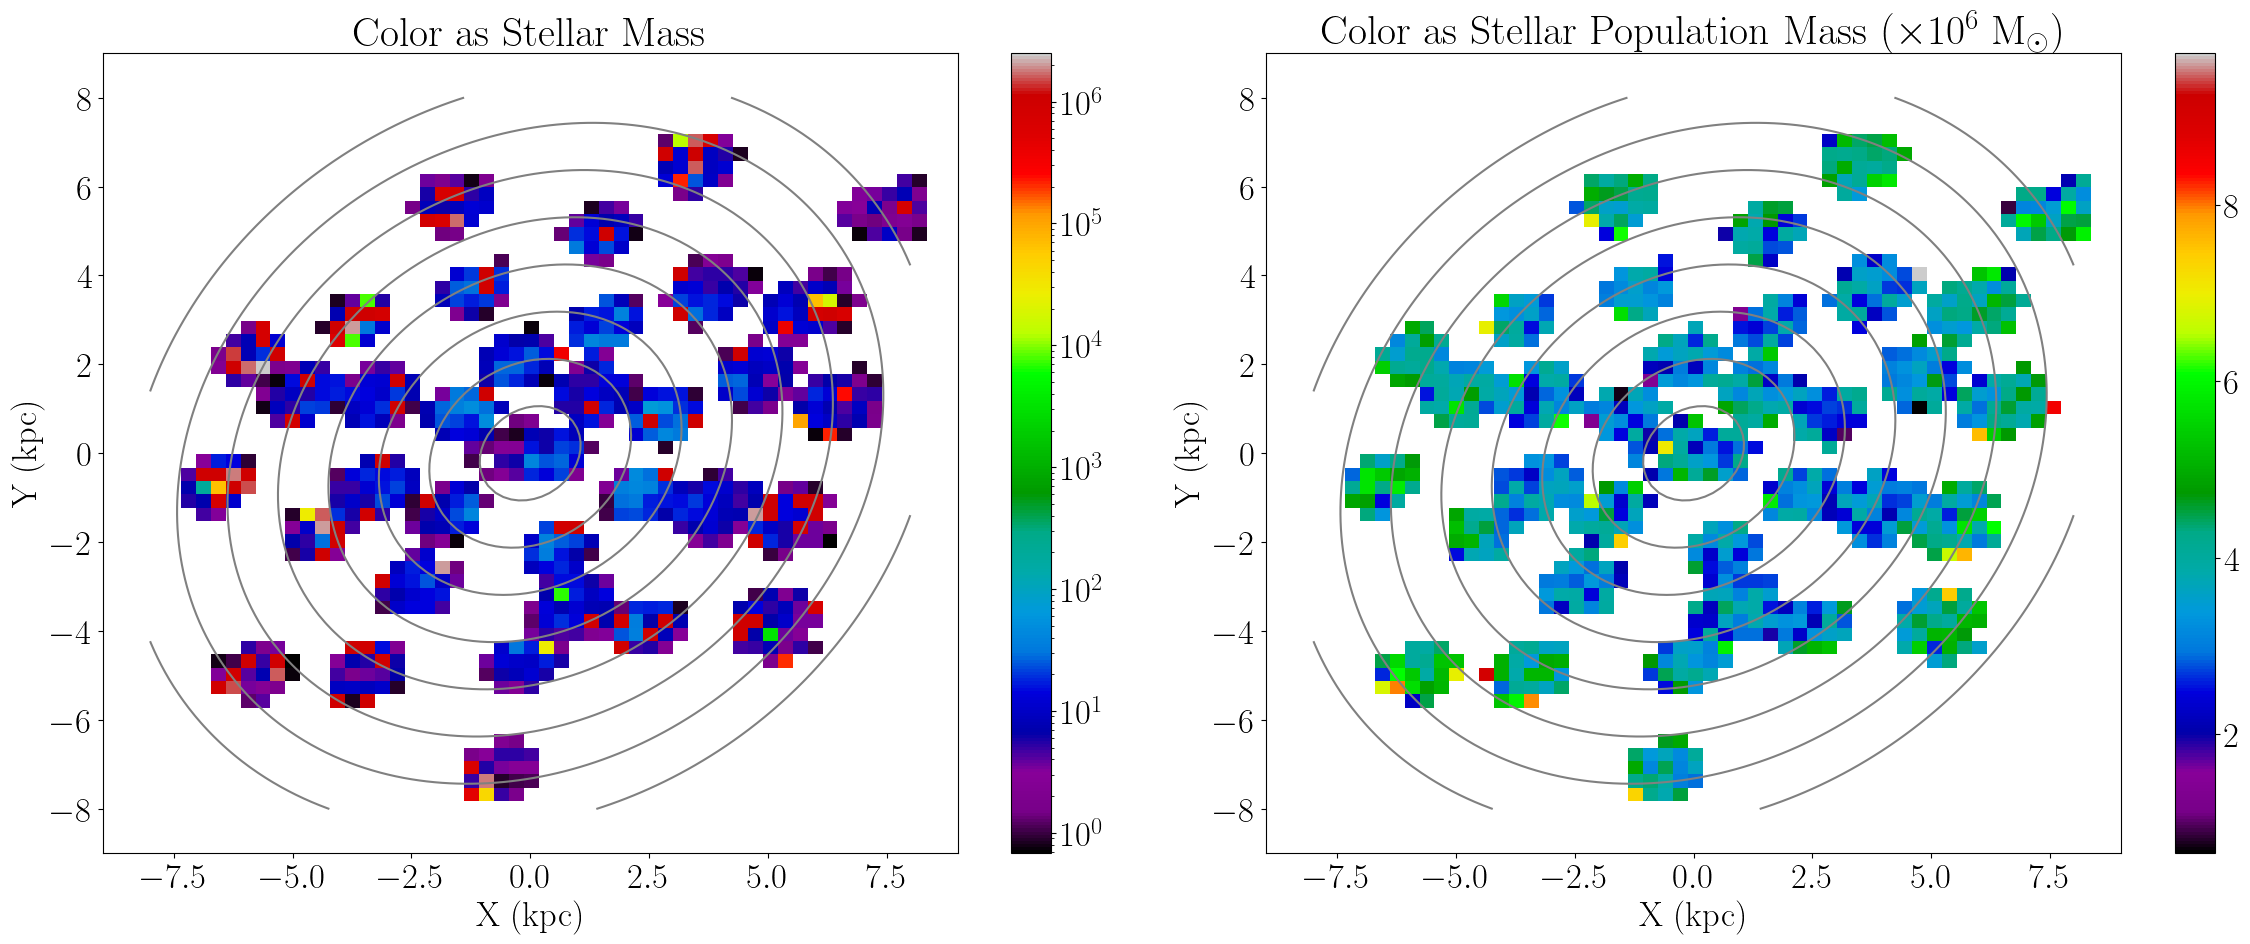

In [181]:
plt.figure(figsize=[24,10])

plt.subplot(121)
xx,yy = np.meshgrid(np.linspace(-8,8,100),np.linspace(-8,8,100))
CS = plt.contour(xx,yy,elliptical_radius(xx,yy),levels=[1,2,3,4,5,6,7,8],colors='grey')

raw_mass, = np.where((agetab['MASS']!=999999.0)&(np.isfinite(agetab['MASS'])==True))
ret = binned_statistic_2d(lmcx[raw_mass],lmcy[raw_mass],agetab['MASS'][raw_mass],'sum',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                aspect='auto',interpolation='nearest',cmap='nipy_spectral',norm=LogNorm())
plt.colorbar()

plt.xlim(-9,9)
plt.ylim(-9,9)

plt.title(r'Color as Stellar Mass')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')
# plt.savefig('lmc_map_ag.png',dpi=300,bbox_inches='tight')

plt.subplot(122)
xx,yy = np.meshgrid(np.linspace(-8,8,100),np.linspace(-8,8,100))
CS = plt.contour(xx,yy,elliptical_radius(xx,yy),levels=[1,2,3,4,5,6,7,8],colors='grey')
unmasked_mass, = np.where(select_results['stellarmass']!=select_results['stellarmass'][6])
ret = binned_statistic_2d(lmcx[unmasked_mass],lmcy[unmasked_mass],select_results['stellarmass'][unmasked_mass],
                          'median',bins=50)
im = plt.imshow(ret.statistic.T/10**6, origin='lower',
                extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                aspect='auto',interpolation='nearest',cmap='nipy_spectral')#,norm=LogNorm())
plt.colorbar()

plt.xlim(-9,9)
plt.ylim(-9,9)

plt.title(r'Color as Stellar Population Mass ($\times 10^6$ M$_{\odot}$)')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')

plt.tight_layout()
# plt.savefig('lmc_mass_map_sf2.png',bbox_inches='tight')
plt.show()

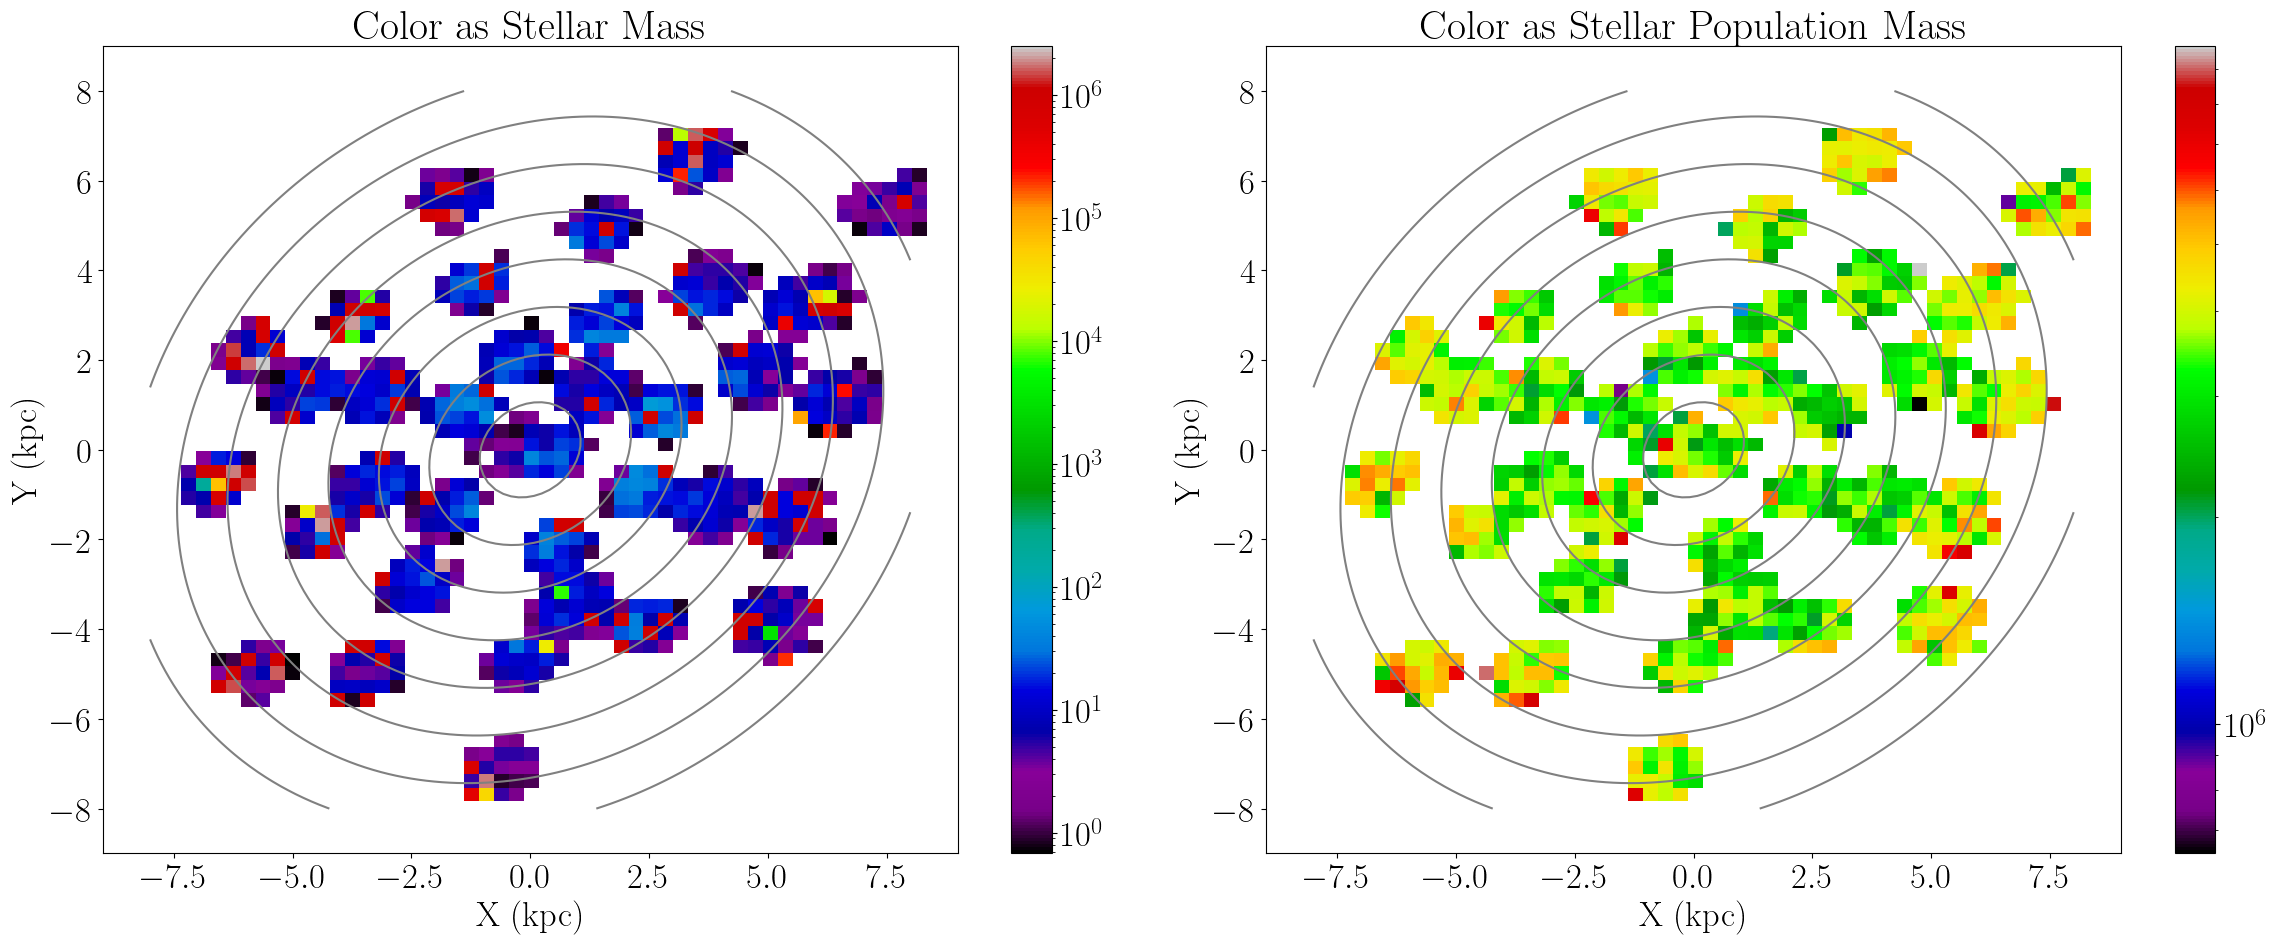

In [186]:
plt.figure(figsize=[24,10])

plt.subplot(121)
xx,yy = np.meshgrid(np.linspace(-8,8,100),np.linspace(-8,8,100))
CS = plt.contour(xx,yy,elliptical_radius(xx,yy),levels=[1,2,3,4,5,6,7,8],colors='grey')

raw_mass, = np.where((agetab['MASS']!=999999.0)&(np.isfinite(agetab['MASS'])==True))
ret = binned_statistic_2d(lmcx[raw_mass],lmcy[raw_mass],agetab['MASS'][raw_mass],'sum',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                aspect='auto',interpolation='nearest',cmap='nipy_spectral',norm=LogNorm())
plt.colorbar()

plt.xlim(-9,9)
plt.ylim(-9,9)

plt.title(r'Color as Stellar Mass')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')
# plt.savefig('lmc_map_ag.png',dpi=300,bbox_inches='tight')

plt.subplot(122)
xx,yy = np.meshgrid(np.linspace(-8,8,100),np.linspace(-8,8,100))
CS = plt.contour(xx,yy,elliptical_radius(xx,yy),levels=[1,2,3,4,5,6,7,8],colors='grey')
unmasked_mass, = np.where(select_results['stellarmass']!=select_results['stellarmass'][6])
ret = binned_statistic_2d(lmcx[unmasked_mass],lmcy[unmasked_mass],select_results['stellarmass'][unmasked_mass],
                          'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                aspect='auto',interpolation='nearest',cmap='nipy_spectral',norm=LogNorm())
plt.colorbar()

plt.xlim(-9,9)
plt.ylim(-9,9)

plt.title(r'Color as Stellar Population Mass')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')

plt.tight_layout()
plt.savefig('lmc_mass_map_sf2.png',bbox_inches='tight')
plt.show()

In [28]:
np.sum(select_results['stellarmass'][unmasked_mass])/10**10

2.3535812066211848

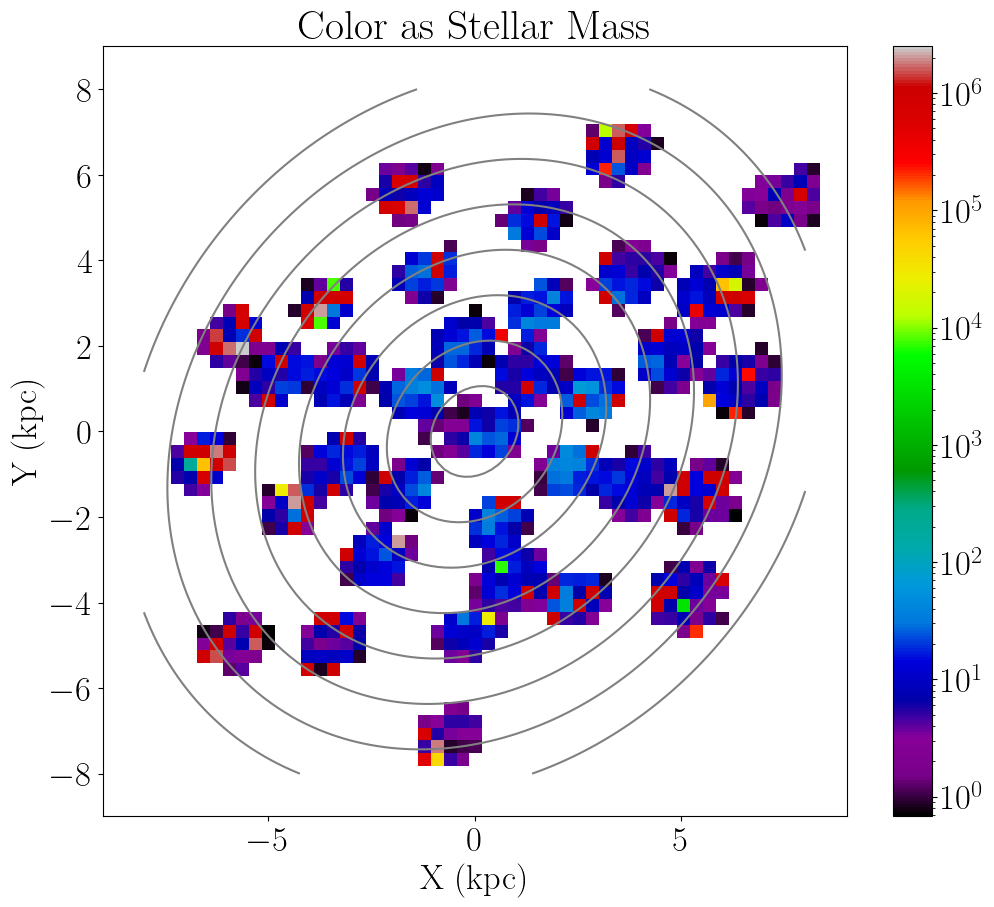

In [29]:
plt.figure(figsize=[12,10])
xx,yy = np.meshgrid(np.linspace(-8,8,100),np.linspace(-8,8,100))
CS = plt.contour(xx,yy,elliptical_radius(xx,yy),levels=[1,2,3,4,5,6,7,8],colors='grey')

raw_mass, = np.where((agetab['MASS']!=999999.0)&(np.isfinite(agetab['MASS'])==True))
ret = binned_statistic_2d(lmcx[raw_mass],lmcy[raw_mass],agetab['MASS'][raw_mass],'sum',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                aspect='auto',interpolation='nearest',cmap='nipy_spectral',norm=LogNorm())
plt.colorbar()

plt.xlim(-9,9)
plt.ylim(-9,9)

plt.title(r'Color as Stellar Mass')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')
# plt.savefig('lmc_mass_map_raw.png')
plt.show()

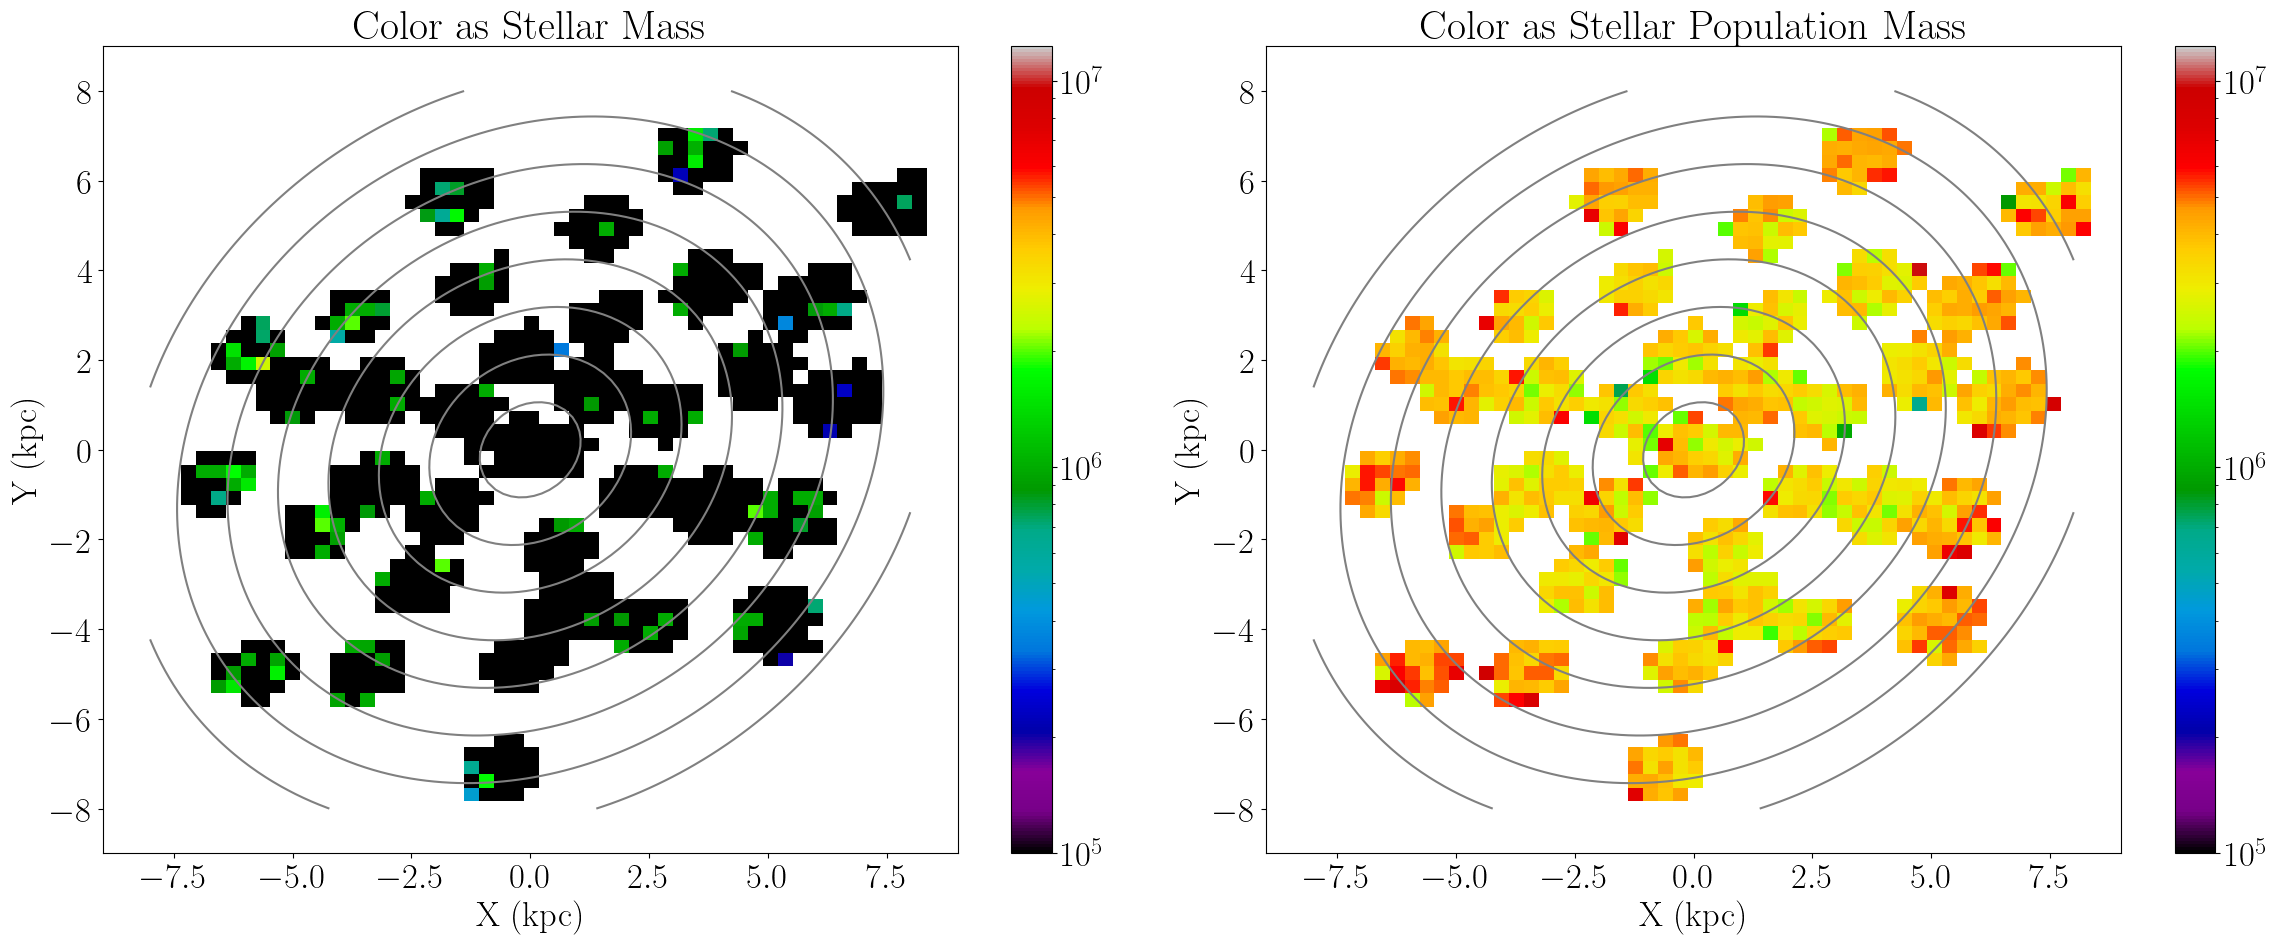

In [30]:
plt.figure(figsize=[24,10])

plt.subplot(121)
xx,yy = np.meshgrid(np.linspace(-8,8,100),np.linspace(-8,8,100))
CS = plt.contour(xx,yy,elliptical_radius(xx,yy),levels=[1,2,3,4,5,6,7,8],colors='grey')

raw_mass, = np.where((agetab['MASS']!=999999.0)&(np.isfinite(agetab['MASS'])==True))
ret = binned_statistic_2d(lmcx[raw_mass],lmcy[raw_mass],agetab['MASS'][raw_mass],'sum',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                aspect='auto',interpolation='nearest',cmap='nipy_spectral',
                norm=LogNorm(vmin=10**5,vmax=max(select_results['stellarmass'][unmasked_mass])))
plt.colorbar()

plt.xlim(-9,9)
plt.ylim(-9,9)

plt.title(r'Color as Stellar Mass')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')
# plt.savefig('lmc_map_ag.png',dpi=300,bbox_inches='tight')

plt.subplot(122)
xx,yy = np.meshgrid(np.linspace(-8,8,100),np.linspace(-8,8,100))
CS = plt.contour(xx,yy,elliptical_radius(xx,yy),levels=[1,2,3,4,5,6,7,8],colors='grey')
unmasked_mass, = np.where(select_results['stellarmass']!=select_results['stellarmass'][6])
ret = binned_statistic_2d(lmcx[unmasked_mass],lmcy[unmasked_mass],select_results['stellarmass'][unmasked_mass],
                          'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                aspect='auto',interpolation='nearest',cmap='nipy_spectral',
                norm=LogNorm(vmin=10**5,vmax=max(select_results['stellarmass'][unmasked_mass])))
plt.colorbar()

plt.xlim(-9,9)
plt.ylim(-9,9)

plt.title(r'Color as Stellar Population Mass')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')

plt.tight_layout()
# plt.savefig('lmc_mass_map.png',bbox_inches='tight')
plt.show()

In [31]:
def bloop(j_k):
    '''
    Function used to cut the bloop using apparent 2Mass colors. The return is the K on the boundary as a function
    of J - K color.
    
    Inputs:
    ------
    j_k: J - K 2Mass color
    
    Outputs:
    -------
    k: apparent 2Mass K of bloop cut 
    '''
    
    j_k = np.asarray(j_k)
    
    bloop_bound = np.ones(len(j_k))
    
    for i in range(len(j_k)):
        if j_k[i] <= 0.85:
            bloop_bound[i] = 12.75
#             return 12.75 #k
        else:
            bloop_bound[i] = -4.25*j_k[i] + 16.36
#             return -4.25*j_k + 16.36
        
    return bloop_bound


bloop_cut, = np.where(lmcdr17['K']>bloop(lmcdr17['J']-lmcdr17['K'])) 

bloop_only = np.where(lmcdr17['K']<bloop(lmcdr17['J']-lmcdr17['K']))

  0%|          | 0/5828 [00:00<?, ?it/s]

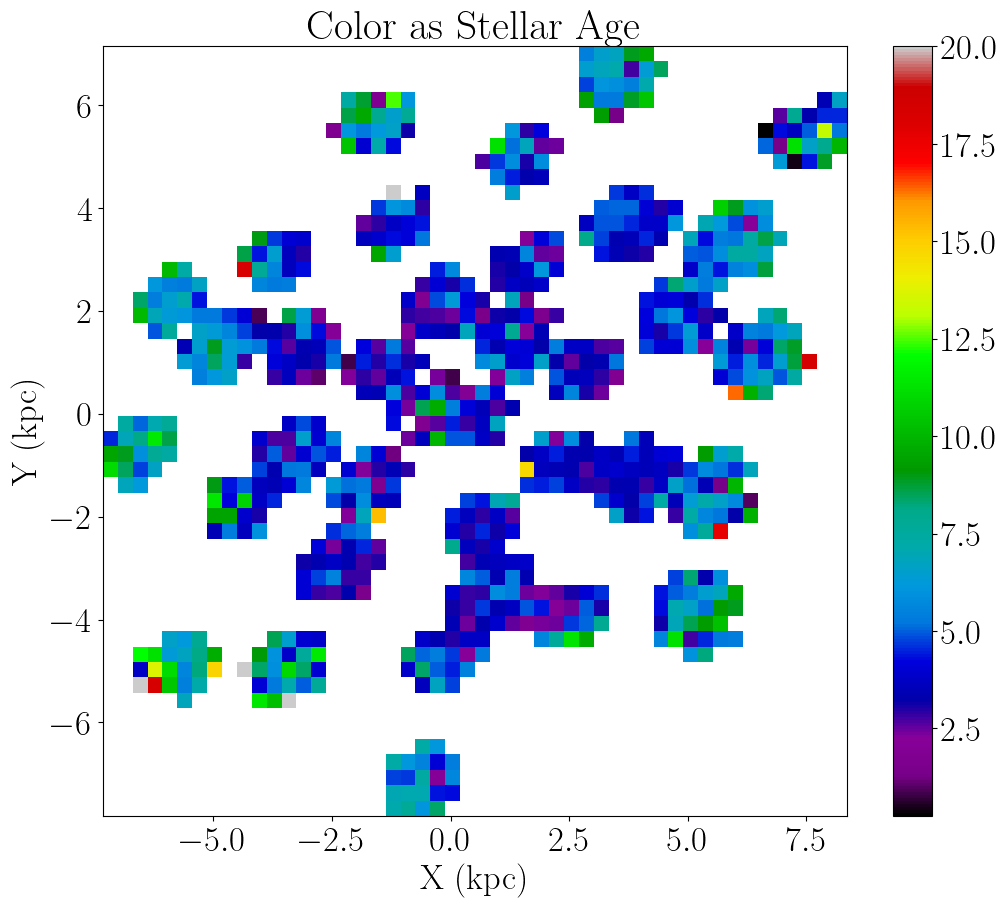

In [32]:
new_num_nobloop = 1/(agetab['DELTA_INT_IMF'][bloop_cut]*select_results['stellarmass'][bloop_cut])

age_num_norm2_nobloop = np.array([])
num_norm2_nobloop_x = np.array([])
num_norm2_nobloop_y = np.array([])

unmasked_mass_nobloop, = np.where(np.isfinite(new_num_nobloop)==True) 

for i in tqdm(range(len(agetab[unmasked_mass_nobloop]))):
    age_num_norm2_nobloop = np.append(age_num_norm2_nobloop,(agetab['AGE'][bloop_cut][unmasked_mass_nobloop][i]*np.ones(int(np.ceil(new_num_nobloop[unmasked_mass_nobloop][i])))).tolist())
    num_norm2_nobloop_x = np.append(num_norm2_nobloop_x,(lmcx[bloop_cut][unmasked_mass_nobloop][i]*np.ones(int(np.ceil(new_num_nobloop[unmasked_mass_nobloop][i])))).tolist())
    num_norm2_nobloop_y = np.append(num_norm2_nobloop_y,(lmcy[bloop_cut][unmasked_mass_nobloop][i]*np.ones(int(np.ceil(new_num_nobloop[unmasked_mass_nobloop][i])))).tolist())
    
plt.figure(figsize=[12,10])
ret = binned_statistic_2d(num_norm2_nobloop_x,num_norm2_nobloop_y,age_num_norm2_nobloop,'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                aspect='auto',interpolation='nearest',cmap='nipy_spectral',vmax=20)
plt.colorbar()

plt.title(r'Color as Stellar Age')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')
# plt.savefig('lmc_map_ag.png',dpi=300,bbox_inches='tight')
plt.show()

In [33]:
# stellar mass wgt feh by fld
# AMR

In [34]:
fld_wgt_avg = np.ones(len(np.unique(lmcdr17['FIELD'][bloop_cut])))
fld_disp = np.ones(len(np.unique(lmcdr17['FIELD'][bloop_cut])))

for i in range(len(np.unique(lmcdr17['FIELD'][bloop_cut]))):
    
    # fld, = np.where((lmcdr17[bloop_cut]['FIELD']==np.unique(lmcdr17['FIELD'][bloop_cut])[i])&(agetab['AGE'][bloop_cut]!=999999.0))
    
    fld, = np.where((lmcdr17['FIELD']==np.unique(lmcdr17['FIELD'])[i])&(agetab['AGE']<=20.0))
    
    fld_wgt_avg[i] = np.dot(agetab['AGE'][fld],select_results[fld]['stellarmass'])/np.sum(select_results[fld]['stellarmass'])
    fld_disp[i] = mad(np.multiply(agetab['AGE'][fld],select_results[fld]['stellarmass'])/np.sum(select_results[fld]['stellarmass']))
    #np.dot(agetab['AGE'][fld],select_results[fld]['stellarmass'])/np.sum(select_results[fld]['stellarmass'])
    
#     corr_fld_ages = np.array([])
    
#     for j in range(len(fld)):
#         corr_fld_ages = np.append(corr_fld_ages,(agetab['AGE'][bloop_cut][fld][i]*np.ones(int(np.ceil(new_num_nobloop[fld][i])))).tolist())
    
#     corrected_fld_medians[i] = np.nanmedian(corr_fld_ages)

In [35]:
fld_wgt_avg

array([5.60198094, 8.34918714, 7.16448258, 6.14509696, 9.19094601,
       4.7306475 , 6.14168256, 7.27217579, 8.91424423, 8.55757277,
       5.93349798, 6.06717851, 7.28047163, 5.35668148, 6.12761353,
       5.53641911, 9.98647121, 8.11126017, 9.4050656 , 6.55262537,
       6.14895806, 8.48044356, 8.55952693, 5.52326006, 7.22253014,
       4.7589326 , 7.62508544, 9.66726425, 5.64521558, 8.54549489,
       4.73070959, 5.72980234, 5.78742276, 7.6559293 , 6.48358238,
       6.40454964])

In [36]:
fld_disp

array([0.07029768, 0.03326093, 0.02428189, 0.01728772, 0.04674488,
       0.01769812, 0.02041794, 0.021813  , 0.04585502, 0.02310676,
       0.01174637, 0.01769605, 0.03207713, 0.01372516, 0.01703818,
       0.01214606, 0.08700945, 0.06911121, 0.04054436, 0.06462087,
       0.02580326, 0.03569003, 0.02649145, 0.01085825, 0.01590426,
       0.02039295, 0.02266034, 0.03682094, 0.01143125, 0.03723156,
       0.01239814, 0.01059559, 0.01489263, 0.02682885, 0.01458798,
       0.02715008])

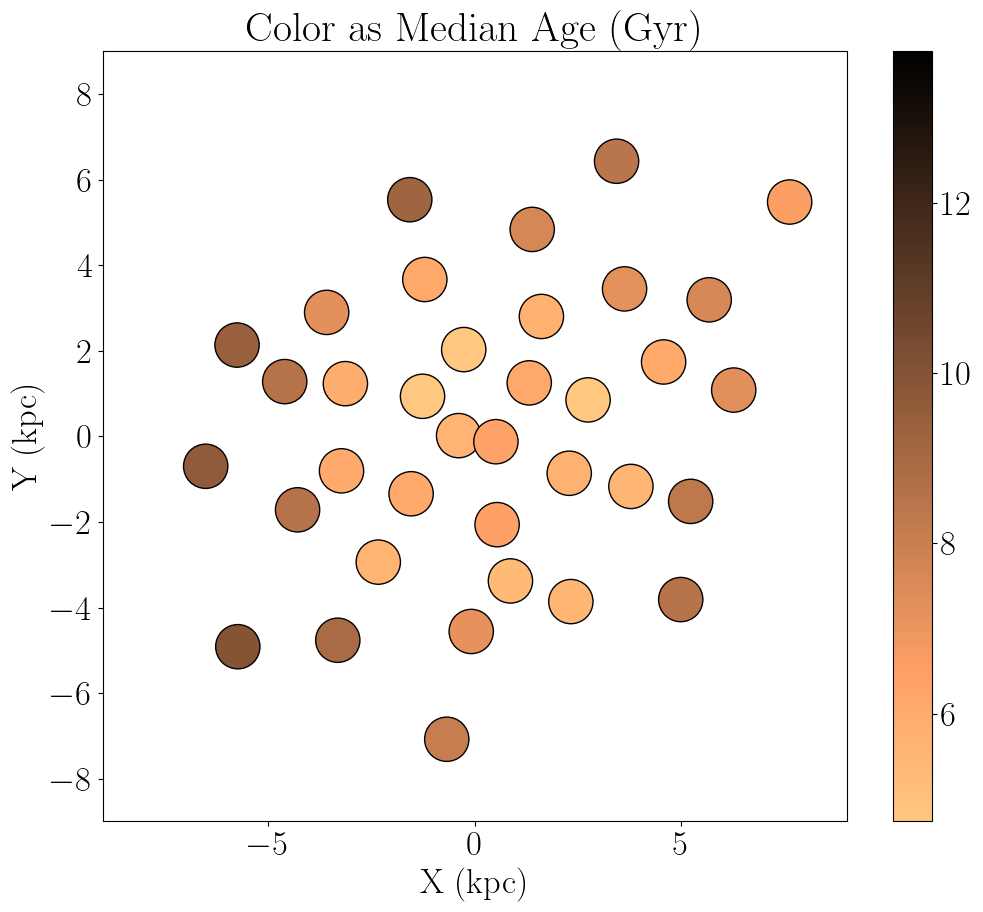

In [187]:
fig, ax = plt.subplots(1,1,figsize=[12,10])
plt.title(r'Color as Median Age (Gyr)')

# set bounds for the plot
ax.set_xlim(-9,9)
ax.set_ylim(-9,9)

# convert 0.8 deg diameter to points and calculate the marker size
r = 49.9*np.tan(np.radians(0.8/2)) #0.8
r_ = ax.transData.transform([r,0])[0] - ax.transData.transform([0,0])[0]
marker_size = np.pi * r_**2

pl = ax.scatter(cen_xy[:,0],cen_xy[:,1],s=marker_size,c=fld_wgt_avg,edgecolors='k',cmap='copper_r',vmax=13.787)
plt.colorbar(pl,ax=ax)

ax.set_xlabel(r'X (kpc)')
ax.set_ylabel(r'Y (kpc)')

# ax.scatter(cen_xy[:,0],cen_xy[:,1],s=marker_size,facecolors='none',edgecolors='k')
plt.show()

#####################################
#### Make ellipses for this plot ####
#####################################

# side by side raw + corrected map


In [38]:
fin, = np.where(np.isfinite(gaiax)==False)
fin

array([], dtype=int64)

/var/folders/rc/1rzbdsbd3pb_0pd6mhcfkh2r0000gn/T/ipykernel_15859/162054495.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


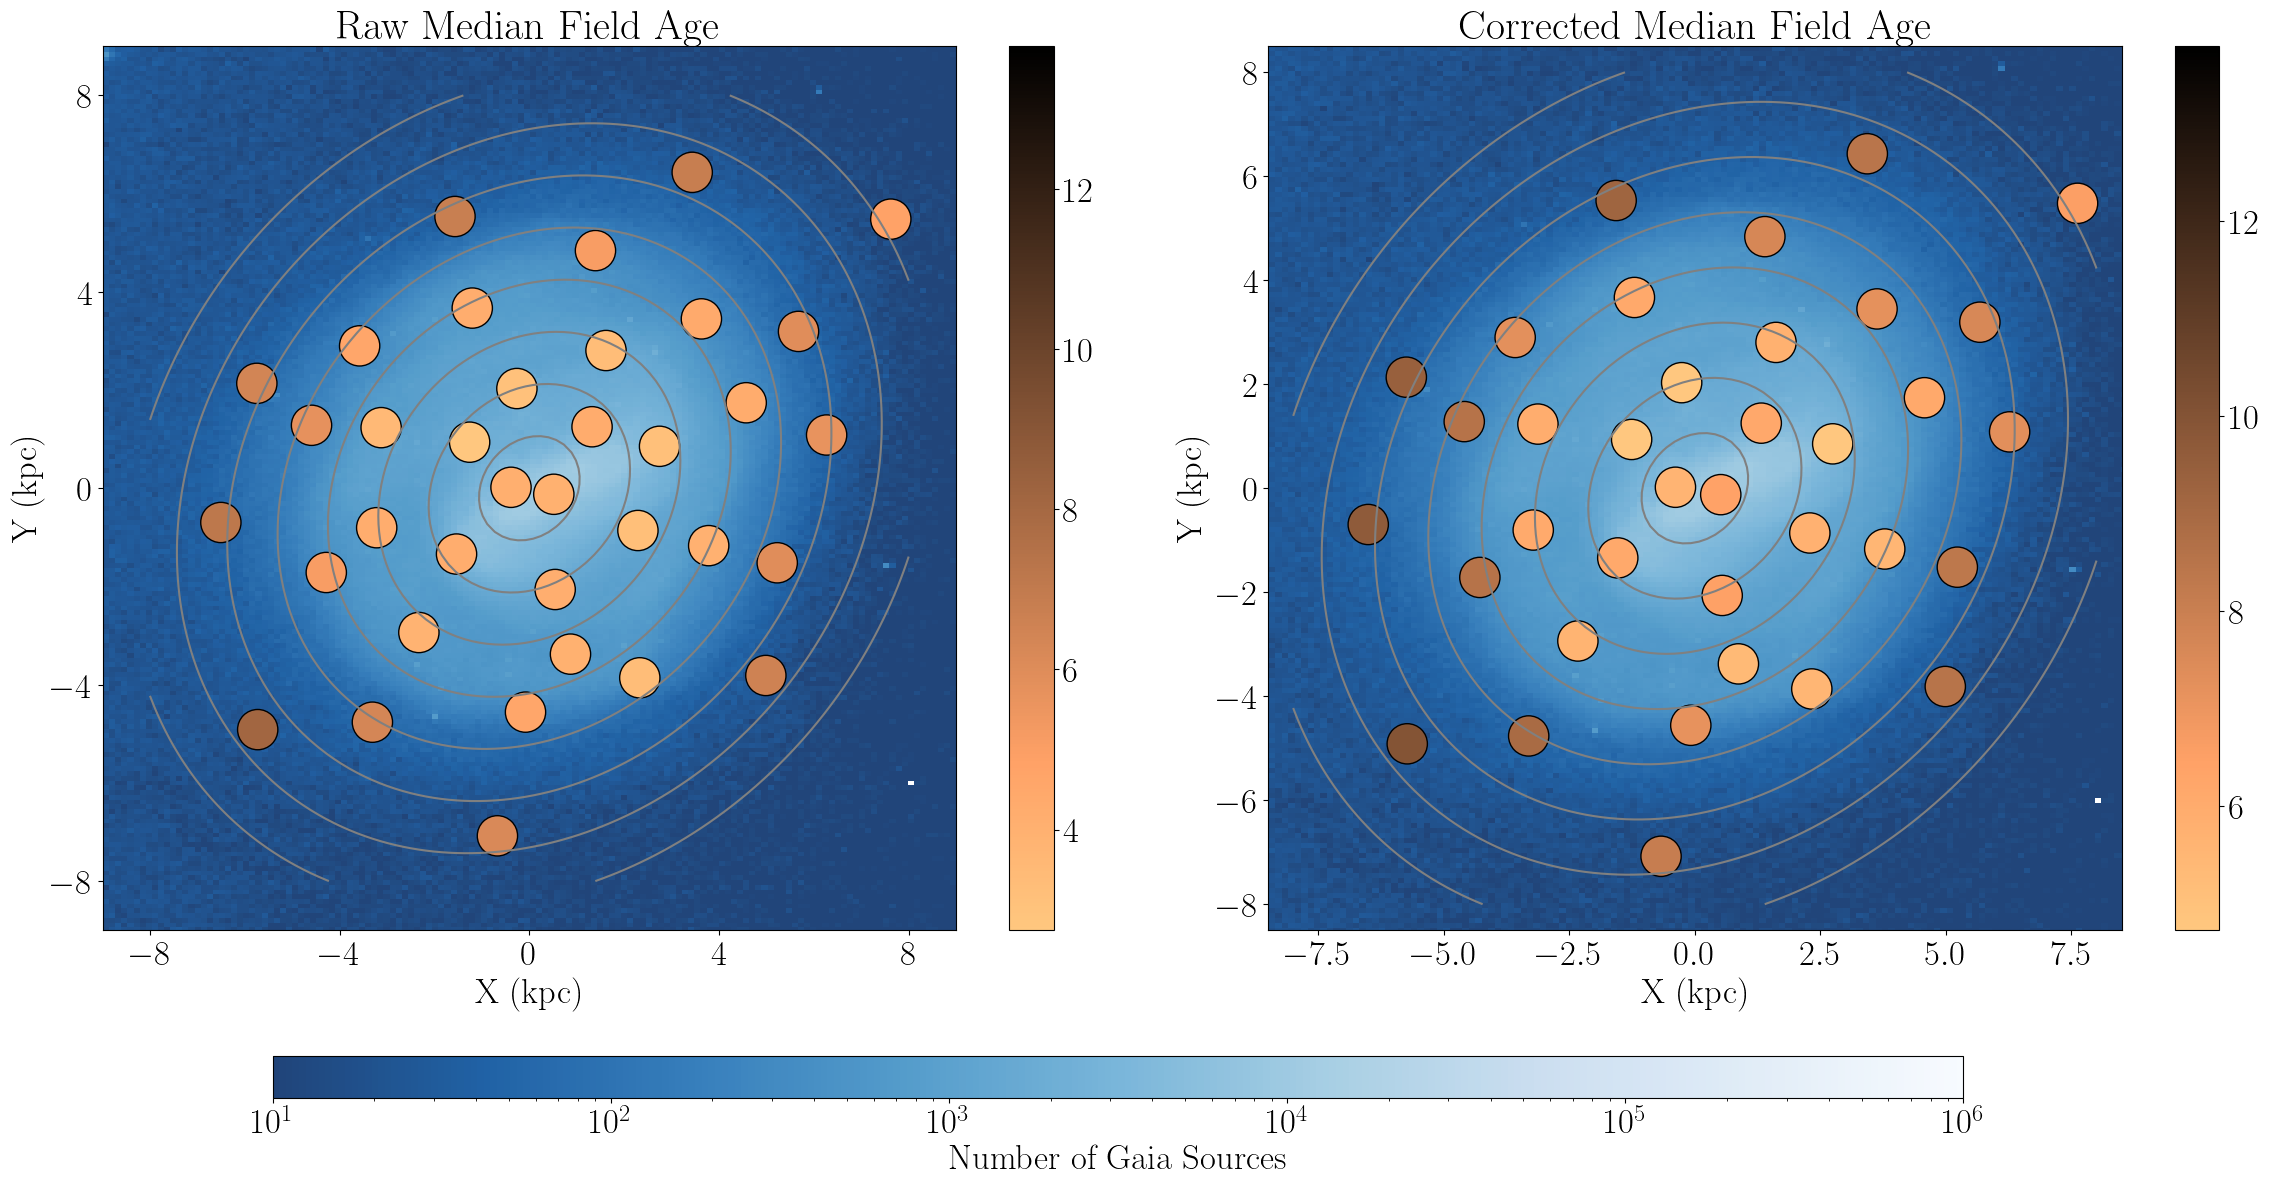

In [190]:
# psi = np.radians(227.24+90.0)
# b_a = 0.839

# clabx = (np.arange(7)+1)*np.sqrt(1/(np.cos(psi)**2+np.sin(psi)**2/b_a))

# locations = []
# for i in range(len(clabx)):
#     locations.append([clabx[i],0.0])

from matplotlib.colors import LogNorm
    
ret = binned_statistic_2d(gaiax,gaiay,gaiax,'count',bins=1000)
ret.statistic[ret.statistic==0] = np.nan

fig, ax = plt.subplots(1,2,figsize=[24,14])

xx,yy = np.meshgrid(np.linspace(-8,8,100),np.linspace(-8,8,100))
CS = ax[0].contour(xx,yy,elliptical_radius(xx,yy),levels=[1,2,3,4,5,6,7,8],colors='grey')
#ax[0].clabel(CS,colors='k',fontsize=25,manual=locations)

# fmt = {}
# strs = ['1', '2', '3', '4', '5', '6', '7']
# for l, s in zip(CS.levels, strs):
#     fmt[l] = s
# ax[0].clabel(CS, CS.levels[::2], inline=True, fmt=fmt, fontsize=10, manual=locations)

CS = ax[1].contour(xx,yy,elliptical_radius(xx,yy),levels=[1,2,3,4,5,6,7,8],colors='grey')
#ax[1].clabel(CS,colors='k',fontsize=25,manual=locations)

# for i in range(len(clabx)):
#     ax[0].text(clabx[i]*(1+0.01),0.0,'{}'.format(i+1))

plt.xlim(-8.5,8.5)
plt.ylim(-8.5,8.5)

# set bounds for the plot
for i in range(1):
    ax[i].set_xlim(-9,9)
    ax[i].set_ylim(-9,9)
    ax[i].set_xlabel(r'X (kpc)')
    ax[i].set_ylabel(r'Y (kpc)')

    ax[i].set_xticks([-8,-4.0,0,4.0,8])
    ax[i].set_yticks([-8,-4.0,0,4.0,8])
    
    

# convert 0.8 deg diameter to points and calculate the marker size
r = 49.9*np.tan(np.radians(0.8/2)) #0.8
r_ = ax[0].transData.transform([r,0])[0] - ax[0].transData.transform([0,0])[0]
marker_size = np.pi * r_**2

ax[0].imshow(ret.statistic.T, origin='lower',
             extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
             aspect='auto',interpolation='nearest',cmap='Blues_r',alpha=0.9,norm=LogNorm(vmin=10**1,vmax=10**6))

im = ax[1].imshow(ret.statistic.T, origin='lower',
             extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
             aspect='auto',interpolation='nearest',cmap='Blues_r',alpha=0.9,norm=LogNorm(vmin=10**1,vmax=10**6))

pl = ax[0].scatter(cen_xy[:,0],cen_xy[:,1],s=marker_size,c=med_fld_age,edgecolors='k',cmap='copper_r',vmax=13.787)
plt.colorbar(pl,ax=ax[0])
pl = ax[1].scatter(cen_xy[:,0],cen_xy[:,1],s=marker_size,c=fld_wgt_avg,edgecolors='k',cmap='copper_r',vmax=13.787)
plt.colorbar(pl,ax=ax[1])

plt.colorbar(im,ax=[ax[0],ax[1]],location='bottom',pad=-0.45,aspect=40,label='Number of Gaia Sources')#orientation='horizontal')

ax[0].set_title(r'Raw Median Field Age')
ax[1].set_title(r'Corrected Median Field Age')

ax[1].set_xlabel(r'X (kpc)')
ax[1].set_ylabel(r'Y (kpc)')

plt.tight_layout()

plt.savefig(r'lmc_median_field_age_map_sf2.png',bbox_inches='tight')
plt.show()

In [40]:
# plt.figure(figsize=[12,10])

# xx,yy = np.meshgrid(np.linspace(-8,8,100),np.linspace(-8,8,100))
# CS = plt.contour(xx,yy,elliptical_radius(xx,yy),levels=[1,2,3,4,5,6,7,8],colors='lightgrey')

# ret = binned_statistic_2d(lmcx,lmcy,lmcdis,'median',bins=50)
# im = plt.imshow(ret.statistic.T, origin='lower',
#                     extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
#                     aspect='auto',interpolation='nearest',cmap='seismic')
# plt.colorbar()

# plt.xlim(-8.5,8.5)
# plt.ylim(-8.5,8.5)

# plt.title(r'Color as Distance (kpc)')
# plt.xlabel(r'X (kpc)')
# plt.ylabel(r'Y (kpc)')
# plt.savefig('lmc_map_distance.png',dpi=300,bbox_inches='tight')
# plt.show()

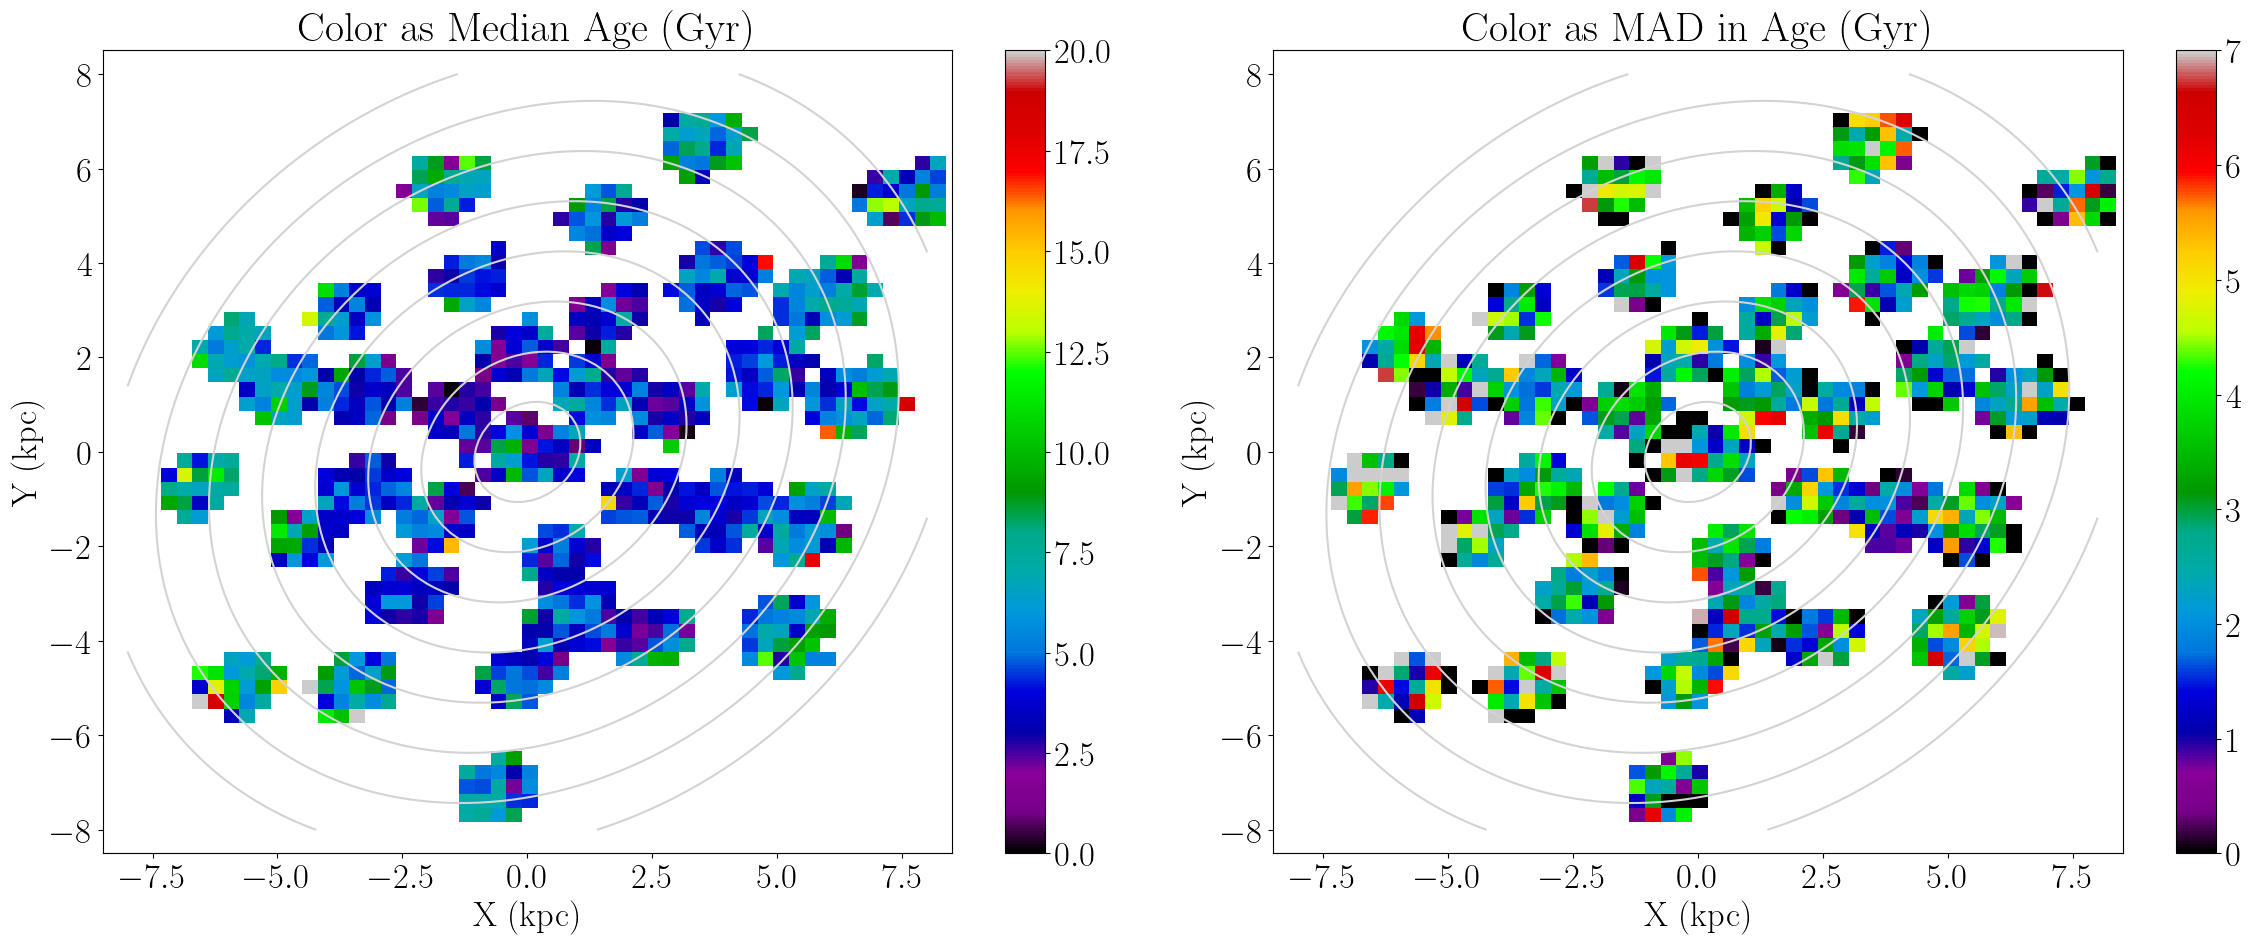

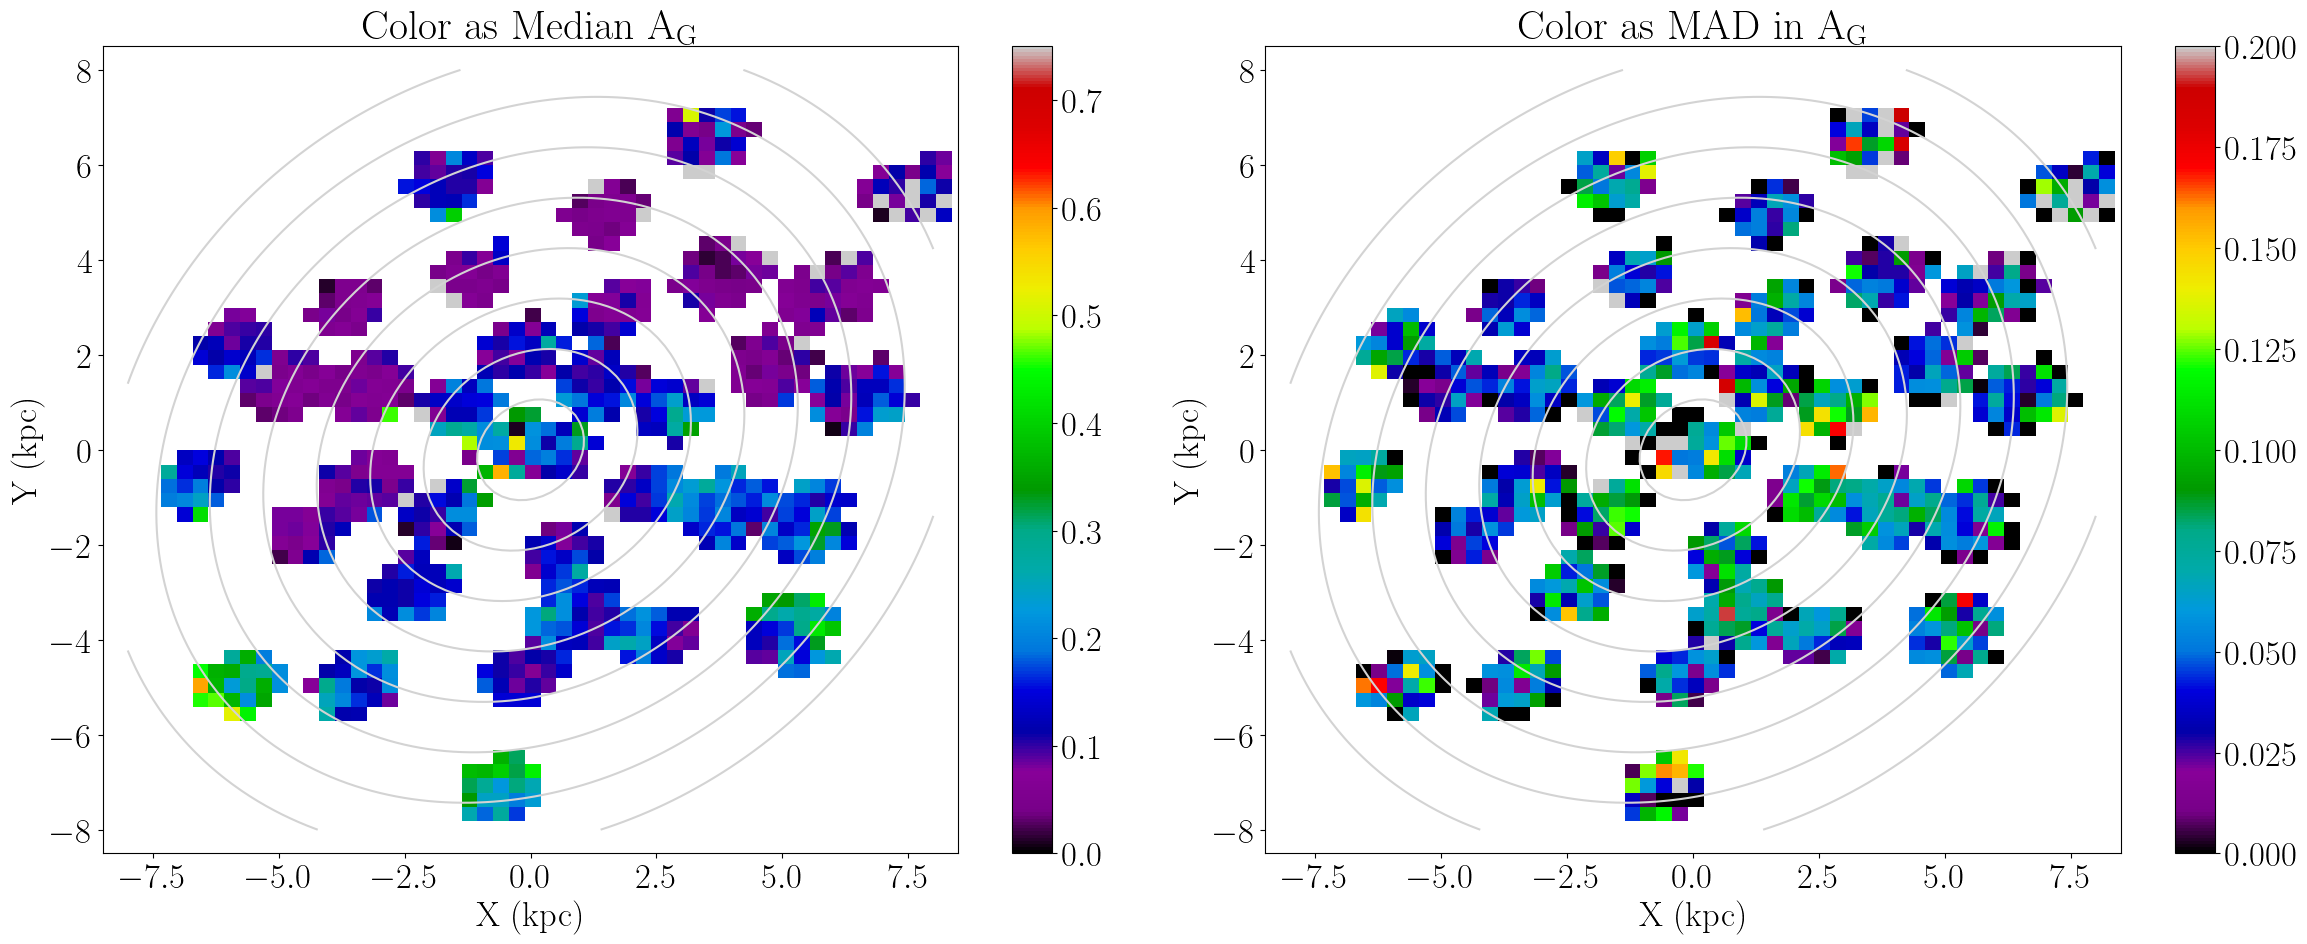

In [41]:
# plt.figure(figsize=[12,10])

# xx,yy = np.meshgrid(np.linspace(-8,8,100),np.linspace(-8,8,100))
# CS = plt.contour(xx,yy,elliptical_radius(xx,yy),levels=[1,2,3,4,5,6,7,8],colors='lightgrey')

# ret = binned_statistic_2d(lmcx,lmcy,agetab['AGE'],'median',bins=50)
# im = plt.imshow(ret.statistic.T, origin='lower',
#                     extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
#                     aspect='auto',interpolation='nearest',cmap='nipy_spectral',vmin=0,vmax=20.)
# plt.colorbar()

# plt.xlim(-8.5,8.5)
# plt.ylim(-8.5,8.5)

# plt.title(r'Color as Median Age (Gyr)')
# plt.xlabel(r'X (kpc)')
# plt.ylabel(r'Y (kpc)')
# plt.savefig('lmc_raw_age_map.png',dpi=300,bbox_inches='tight')
# plt.show()

plt.figure(figsize=[24,10])

xx,yy = np.meshgrid(np.linspace(-8,8,100),np.linspace(-8,8,100))

plt.subplot(121)
CS = plt.contour(xx,yy,elliptical_radius(xx,yy),levels=[1,2,3,4,5,6,7,8],colors='lightgrey')
ret = binned_statistic_2d(lmcx,lmcy,agetab['AGE'],'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='nipy_spectral',vmin=0,vmax=20.)
plt.colorbar()

plt.xlim(-8.5,8.5)
plt.ylim(-8.5,8.5)

plt.title(r'Color as Median Age (Gyr)')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')

plt.subplot(122)
CS = plt.contour(xx,yy,elliptical_radius(xx,yy),levels=[1,2,3,4,5,6,7,8],colors='lightgrey')
ret = binned_statistic_2d(lmcx,lmcy,agetab['AGE'],mad,bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='nipy_spectral',vmin=0,vmax=7)
plt.colorbar()

plt.xlim(-8.5,8.5)
plt.ylim(-8.5,8.5)

plt.title(r'Color as MAD in Age (Gyr)')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')

plt.tight_layout()
plt.savefig('lmc_raw_age_map_sf2.png',dpi=300,bbox_inches='tight')
plt.show()

plt.figure(figsize=[24,10])

xx,yy = np.meshgrid(np.linspace(-8,8,100),np.linspace(-8,8,100))

plt.subplot(121)
CS = plt.contour(xx,yy,elliptical_radius(xx,yy),levels=[1,2,3,4,5,6,7,8],colors='lightgrey')
ret = binned_statistic_2d(lmcx,lmcy,agetab['EXT'][:,1],'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='nipy_spectral',vmin=0,vmax=0.75)
plt.colorbar()

plt.xlim(-8.5,8.5)
plt.ylim(-8.5,8.5)

plt.title(r'Color as Median A$_{\rm G}$')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')

plt.subplot(122)
CS = plt.contour(xx,yy,elliptical_radius(xx,yy),levels=[1,2,3,4,5,6,7,8],colors='lightgrey')
ret = binned_statistic_2d(lmcx,lmcy,agetab['EXT'][:,1],mad,bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='nipy_spectral',vmin=0,vmax=0.2)
plt.colorbar()

plt.xlim(-8.5,8.5)
plt.ylim(-8.5,8.5)

plt.title(r'Color as MAD in A$_{\rm G}$')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')

plt.tight_layout()
plt.savefig('lmc_g_ext_map_sf2.png',dpi=300,bbox_inches='tight')
plt.show()

/var/folders/rc/1rzbdsbd3pb_0pd6mhcfkh2r0000gn/T/ipykernel_15859/2488839188.py:39: RuntimeWarning: invalid value encountered in true_divide
  im = plt.imshow(age_mass_wgt.statistic.T/mass_wgt.statistic.T, origin='lower',


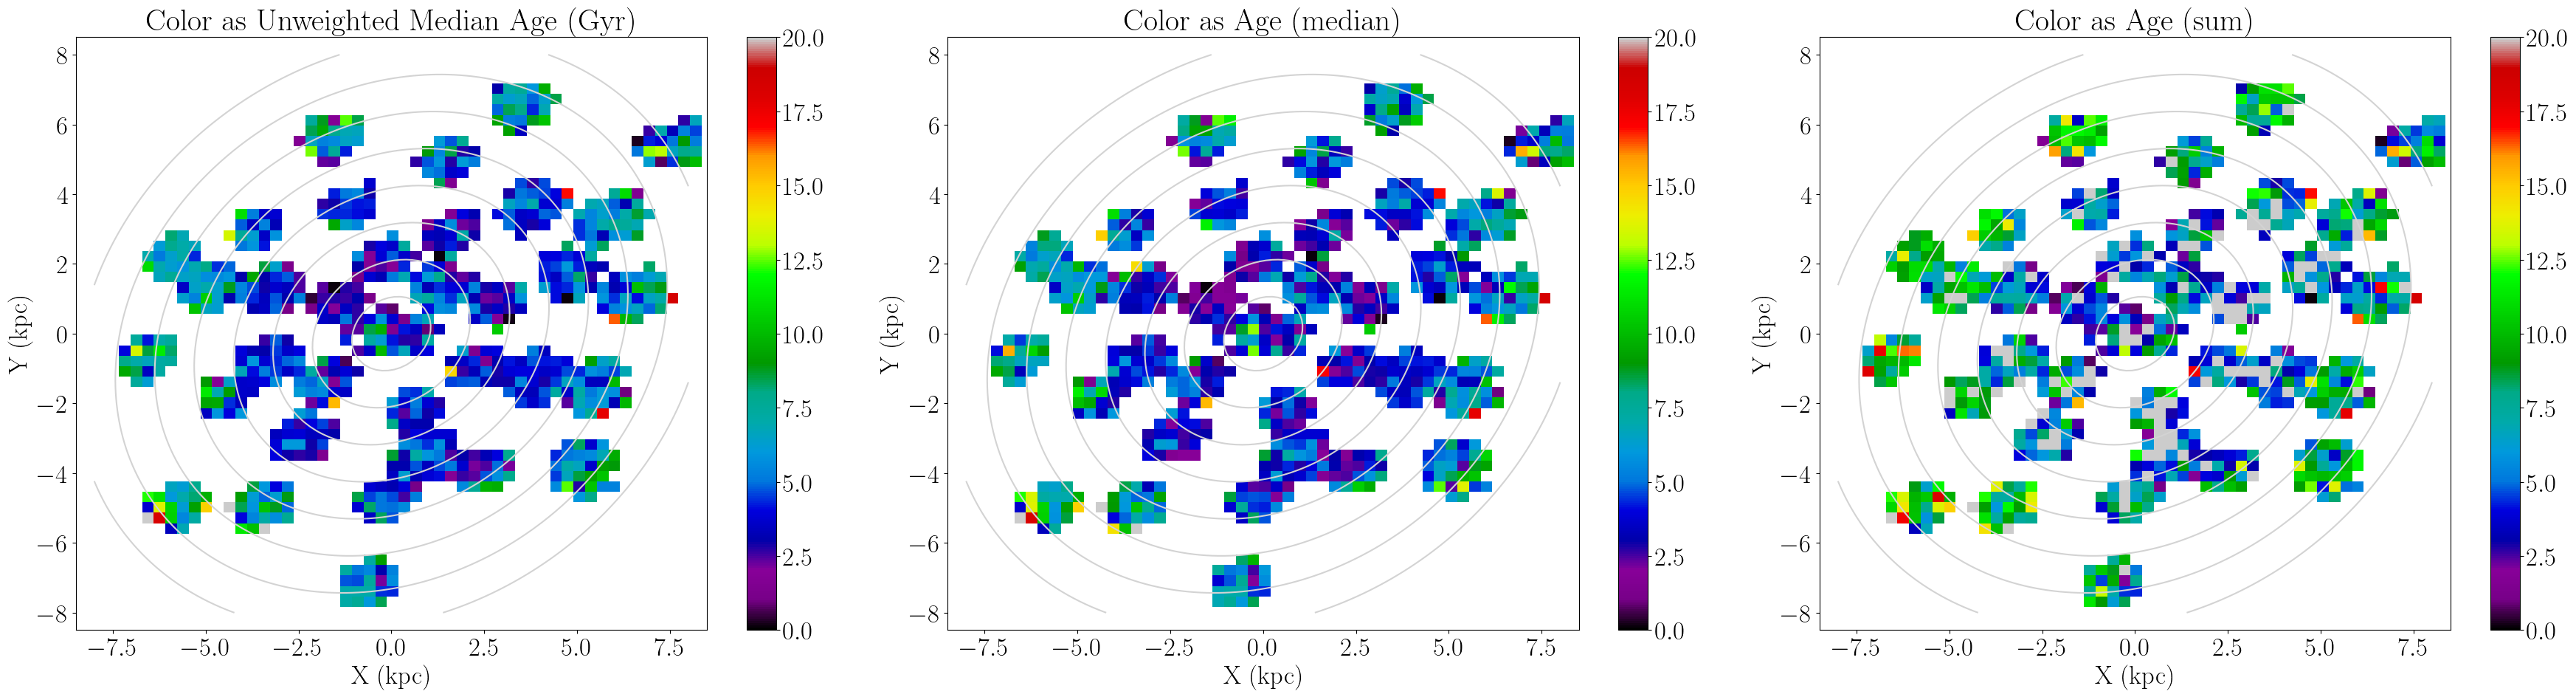

In [42]:
plt.figure(figsize=[36,10])
plt.subplot(131)
CS = plt.contour(xx,yy,elliptical_radius(xx,yy),levels=[1,2,3,4,5,6,7,8],colors='lightgrey')
ret = binned_statistic_2d(lmcx,lmcy,agetab['AGE'],'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='nipy_spectral',vmin=0,vmax=20.)
plt.colorbar()

plt.xlim(-8.5,8.5)
plt.ylim(-8.5,8.5)

plt.title(r'Color as Unweighted Median Age (Gyr)')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')

plt.subplot(132)
age_mass_wgt = binned_statistic_2d(lmcx, lmcy, np.multiply(agetab['AGE'],select_results['stellarmass']),'median',bins=50)
mass_wgt = binned_statistic_2d(lmcx, lmcy, select_results['stellarmass'],'median',bins=50)

CS = plt.contour(xx,yy,elliptical_radius(xx,yy),levels=[1,2,3,4,5,6,7,8],colors='lightgrey')
im = plt.imshow(age_mass_wgt.statistic.T/mass_wgt.statistic.T, origin='lower',
                    extent=[age_mass_wgt.x_edge[0],age_mass_wgt.x_edge[-1],age_mass_wgt.y_edge[0],age_mass_wgt.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='nipy_spectral',vmin=0,vmax=20)
plt.colorbar()

plt.xlim(-8.5,8.5)
plt.ylim(-8.5,8.5)

plt.title(r'Color as Age (median)')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')

plt.subplot(133)
age_mass_wgt = binned_statistic_2d(lmcx, lmcy, np.multiply(agetab['AGE'],select_results['stellarmass']),'sum',bins=50)
mass_wgt = binned_statistic_2d(lmcx, lmcy, select_results['stellarmass'],'sum',bins=50)

CS = plt.contour(xx,yy,elliptical_radius(xx,yy),levels=[1,2,3,4,5,6,7,8],colors='lightgrey')
im = plt.imshow(age_mass_wgt.statistic.T/mass_wgt.statistic.T, origin='lower',
                    extent=[age_mass_wgt.x_edge[0],age_mass_wgt.x_edge[-1],age_mass_wgt.y_edge[0],age_mass_wgt.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='nipy_spectral',vmin=0,vmax=20)
plt.colorbar()

plt.xlim(-8.5,8.5)
plt.ylim(-8.5,8.5)

plt.title(r'Color as Age (sum)')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')

plt.tight_layout()

In [43]:
# plt.figure(figsize=[24,10])

# xx,yy = np.meshgrid(np.linspace(-8,8,100),np.linspace(-8,8,100))

# plt.subplot(121)
# CS = plt.contour(xx,yy,elliptical_radius(xx,yy),levels=[1,2,3,4,5,6,7,8],colors='lightgrey')
# ret = binned_statistic_2d(lmcx,lmcy,agetab['AGE'],'median',bins=50)
# im = plt.imshow(ret.statistic.T, origin='lower',
#                     extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
#                     aspect='auto',interpolation='nearest',cmap='nipy_spectral',vmin=0,vmax=20.)
# plt.colorbar()

# plt.xlim(-8.5,8.5)
# plt.ylim(-8.5,8.5)

# plt.title(r'Color as Median Age (Gyr)')
# plt.xlabel(r'X (kpc)')
# plt.ylabel(r'Y (kpc)')

# plt.subplot(122)
# CS = plt.contour(xx,yy,elliptical_radius(xx,yy),levels=[1,2,3,4,5,6,7,8],colors='lightgrey')
# ret = binned_statistic_2d(lmcx,lmcy,agetab['AGE'],mad,bins=50)
# im = plt.imshow(ret.statistic.T, origin='lower',
#                     extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
#                     aspect='auto',interpolation='nearest',cmap='nipy_spectral',vmin=0,vmax=7)
# plt.colorbar()

# # H, xedges, yedges = np.histogram2d(lmcx,lmcy,agetab['AGE'],bins=(xedges, yedges))

# plt.xlim(-8.5,8.5)
# plt.ylim(-8.5,8.5)

# plt.title(r'Color as Age (Gyr)')
# plt.xlabel(r'X (kpc)')
# plt.ylabel(r'Y (kpc)')

# plt.tight_layout()
# # plt.savefig('lmc_raw_age_map.png',dpi=300,bbox_inches='tight')
# plt.show()

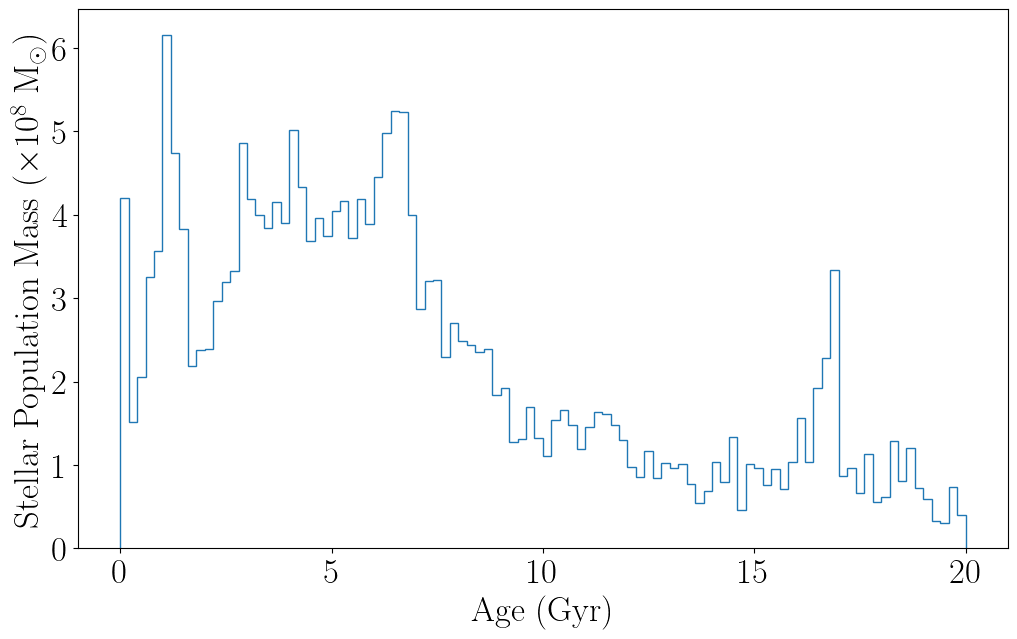

In [171]:
plt.figure(figsize=[12,7])
plt.hist(agetab['AGE'],weights=select_results['stellarmass']/10**8,range=(0,20),bins=100,histtype='step')
# plt.yscale('log')
plt.xlabel(r'Age (Gyr)')
plt.ylabel(r'Stellar Population Mass ($\times 10^8$ M$_\odot$)')
plt.savefig('age_stellarpopmass_sf2.png',bbox_inches='tight')
plt.show()

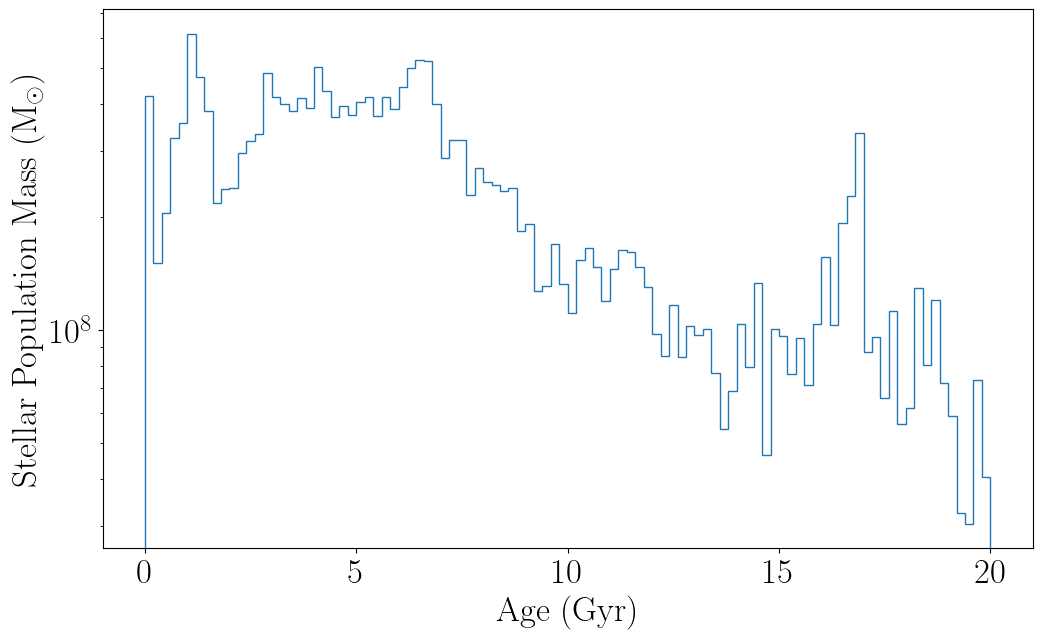

In [172]:
plt.figure(figsize=[12,7])
plt.hist(agetab['AGE'],weights=select_results['stellarmass'],range=(0,20),bins=100,histtype='step')
plt.yscale('log')
plt.xlabel(r'Age (Gyr)')
plt.ylabel(r'Stellar Population Mass (M$_\odot$)')
plt.savefig('age_stellarpopmass_sf2.png',bbox_inches='tight')
plt.show()

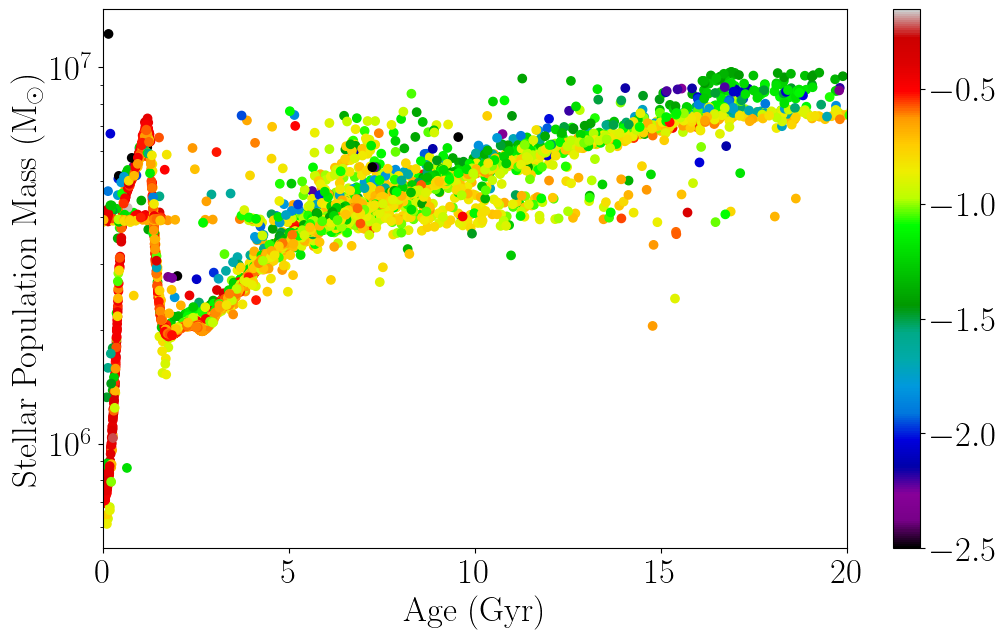

In [45]:
plt.figure(figsize=[12,7])
plt.scatter(agetab['AGE'],select_results['stellarmass'],c=lmcdr17['FE_H'],cmap='nipy_spectral')
plt.colorbar()
plt.xlim(0,20)
plt.yscale('log')
plt.xlabel(r'Age (Gyr)')
plt.ylabel(r'Stellar Population Mass (M$_\odot$)')
plt.savefig('age_stellarpopmass_scatter_sf2.png',bbox_inches='tight')
plt.show()

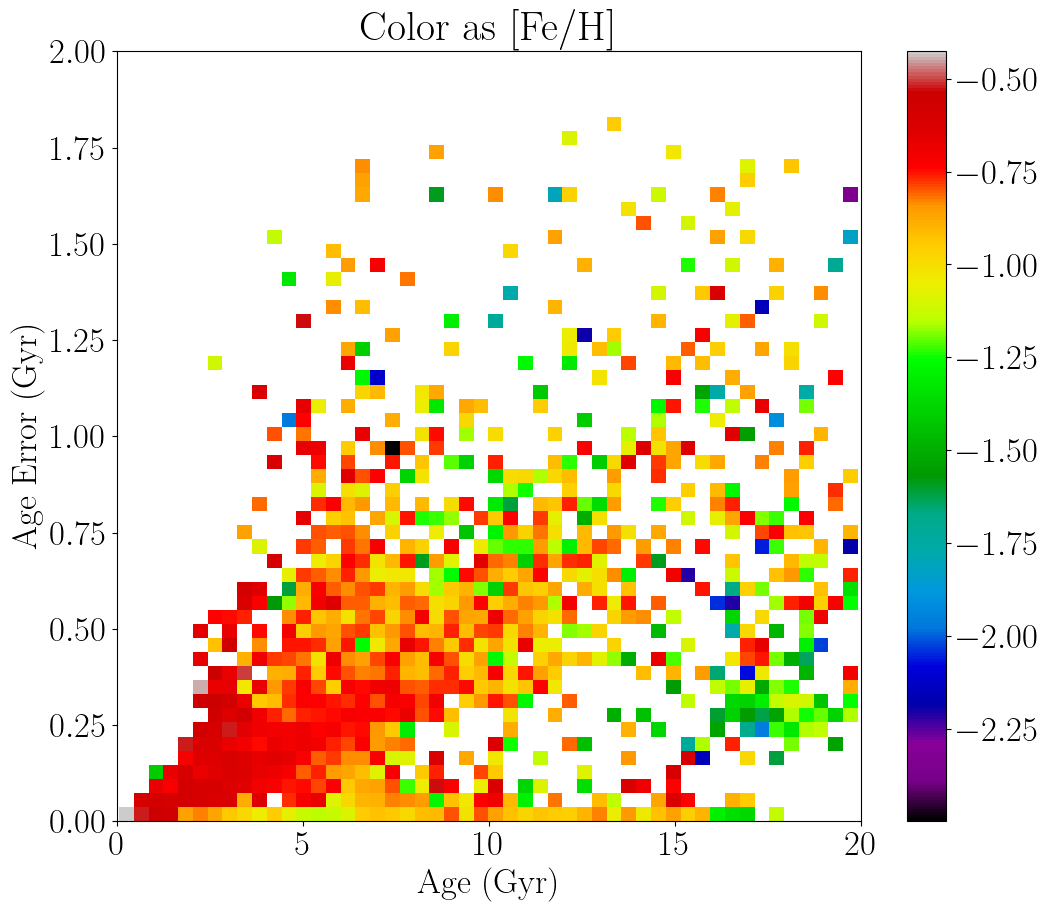

In [46]:
plt.figure(figsize=[12,10])
cut, = np.where((agetab['AGE']<=20)&(agetab['AGE_ERR']<=2)&
                (np.isfinite(agetab['AGE'])==True)&(np.isfinite(agetab['AGE_ERR'])==True))
ret = binned_statistic_2d(agetab['AGE'][cut],agetab['AGE_ERR'][cut],lmcdr17['FE_H'][cut],'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='nipy_spectral')
# plt.scatter(agetab['AGE'],agetab['AGE_ERR'],c=lmcdr17['FE_H'],cmap='nipy_spectral')
plt.colorbar()
plt.xlim(0,20)
plt.ylim(0,2)
plt.title(r'Color as [Fe/H]')
plt.xlabel(r'Age (Gyr)')
plt.ylabel(r'Age Error (Gyr)')
plt.show()

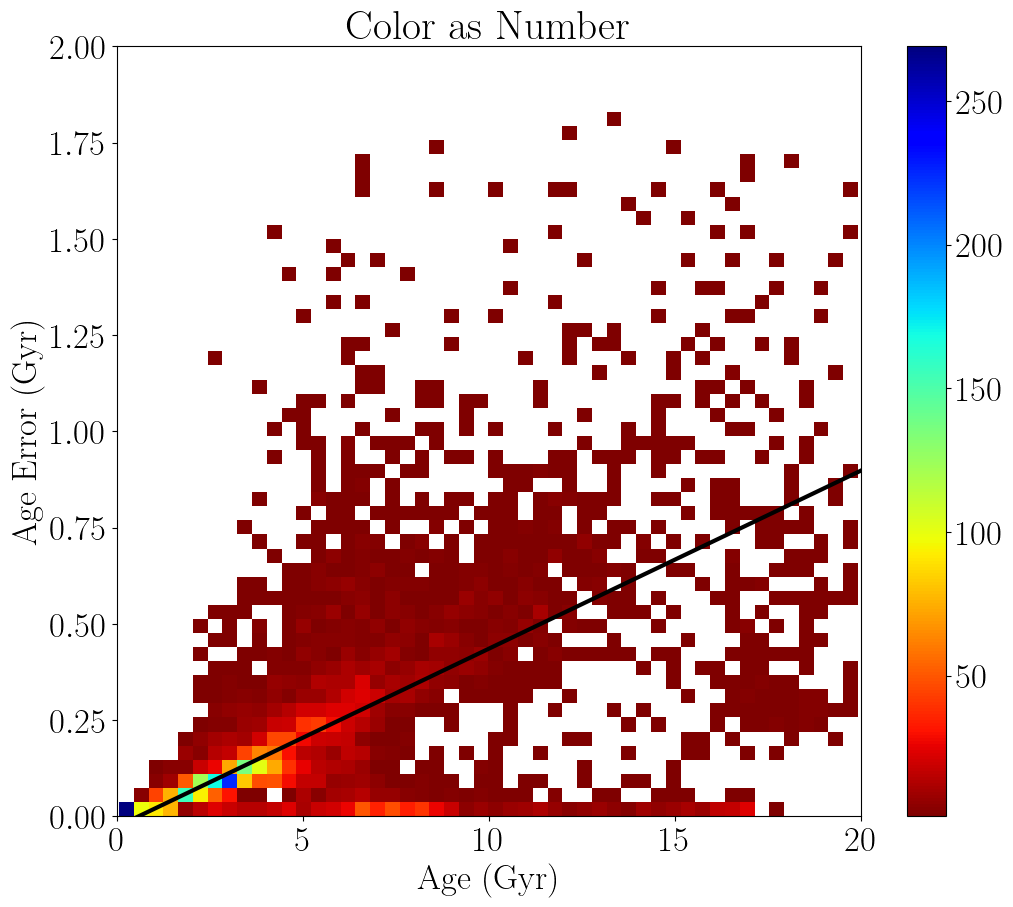

In [47]:
plt.figure(figsize=[12,10])
cut, = np.where((agetab['AGE']<=20)&(agetab['AGE_ERR']<=2)&
                (np.isfinite(agetab['AGE'])==True)&(np.isfinite(agetab['AGE_ERR'])==True))
ret = binned_statistic_2d(agetab['AGE'][cut],agetab['AGE_ERR'][cut],agetab['AGE'][cut],'count',bins=50)
ret.statistic[ret.statistic==0] = np.nan
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet_r')
# plt.scatter(agetab['AGE'],agetab['AGE_ERR'],c=lmcdr17['FE_H'],cmap='nipy_spectral')

p_age_err = np.poly1d(robust.polyfit(agetab['AGE'][cut],agetab['AGE_ERR'][cut],1))
plt.plot(np.linspace(0,20),p_age_err(np.linspace(0,20)),c='k',lw=3.0)

plt.colorbar()
plt.xlim(0,20)
plt.ylim(0,2)
plt.title(r'Color as Number')
plt.xlabel(r'Age (Gyr)')
plt.ylabel(r'Age Error (Gyr)')
plt.show()

(array([36.73585895,  4.71981057,  4.79847408,  3.14654038,  2.12391476,
         2.59589581,  5.89976321, 10.38358326, 13.2154696 , 16.44067349]),
 array([1.82569101e-06, 9.99583088e-03, 1.99898361e-02, 2.99838412e-02,
        3.99778464e-02, 4.99718516e-02, 5.99658568e-02, 6.99598620e-02,
        7.99538672e-02, 8.99478724e-02, 9.99418775e-02]),
 <BarContainer object of 10 artists>)

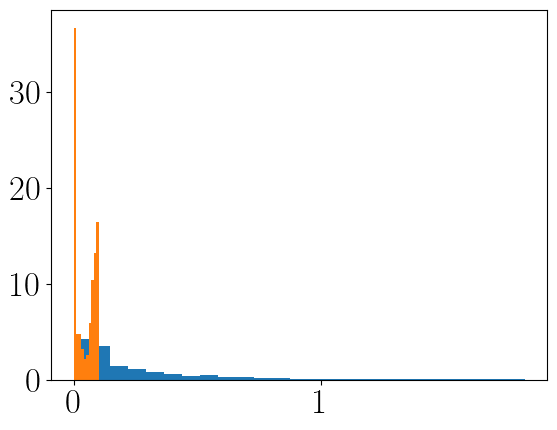

In [48]:
bad_err = np.where((agetab['AGE'][cut]>2.5)&(agetab['AGE_ERR'][cut]<0.1))
good_err = np.where((agetab['AGE'][cut]>2.5)&(agetab['AGE_ERR'][cut]<0.1))

plt.hist(agetab['AGE_ERR'][cut],bins=25,density=True)
plt.hist(agetab['AGE_ERR'][cut][bad_err],bins=10,density=True)

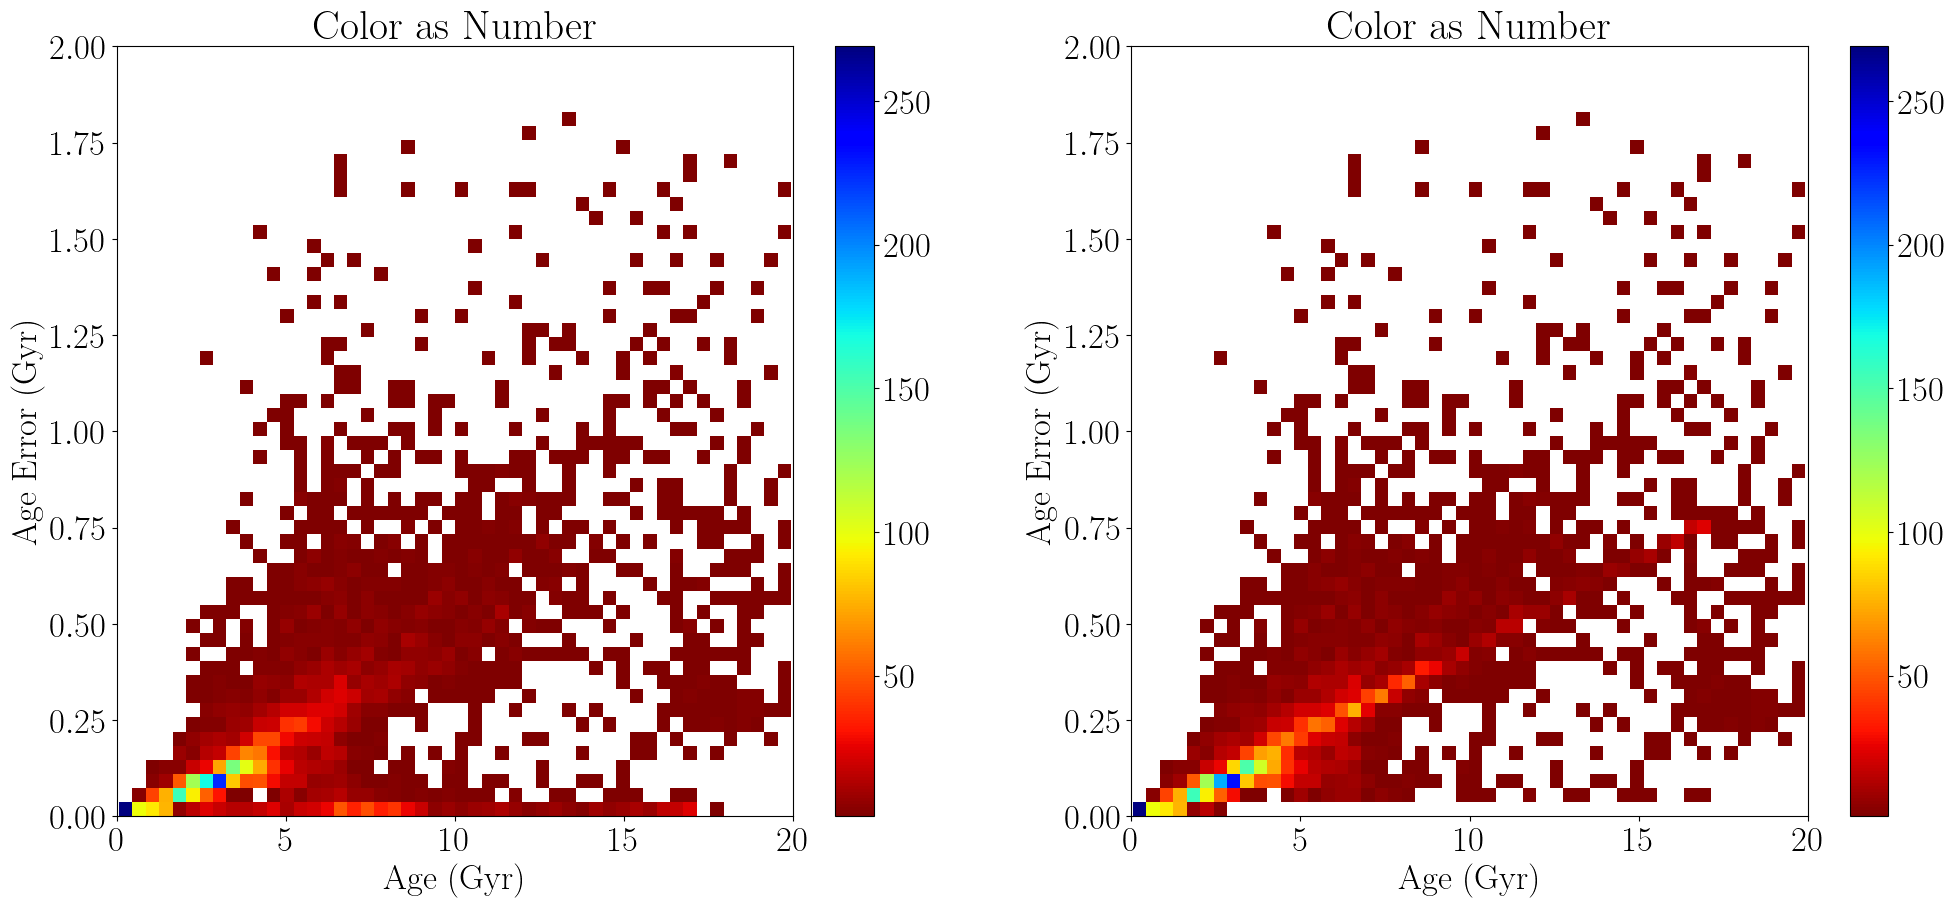

In [49]:
new_err = np.copy(agetab['AGE_ERR'])

for i in range(len(agetab)):
    if (agetab['AGE'][i]>2.5)&(agetab['AGE_ERR'][i]<0.05):
        new_err[i] = p_age_err(agetab['AGE'][i])


plt.figure(figsize=[24,10])
cut, = np.where((agetab['AGE']<=20)&(agetab['AGE_ERR']<=2)&
                (np.isfinite(agetab['AGE'])==True)&(np.isfinite(agetab['AGE_ERR'])==True))
plt.subplot(121)
ret = binned_statistic_2d(agetab['AGE'][cut],agetab['AGE_ERR'][cut],agetab['AGE'][cut],'count',bins=50)
ret.statistic[ret.statistic==0] = np.nan
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet_r')
# plt.scatter(agetab['AGE'],agetab['AGE_ERR'],c=lmcdr17['FE_H'],cmap='nipy_spectral')

p_age_err = np.poly1d(robust.polyfit(agetab['AGE'][cut],agetab['AGE_ERR'][cut],1))
# plt.plot(np.linspace(0,20),p_age_err(np.linspace(0,20)),c='k',lw=3.0)

plt.colorbar()
plt.xlim(0,20)
plt.ylim(0,2)
plt.title(r'Color as Number')
plt.xlabel(r'Age (Gyr)')
plt.ylabel(r'Age Error (Gyr)')

plt.subplot(122)
cut2, = np.where((agetab['AGE']<=20)&(new_err<=2)&
                (np.isfinite(agetab['AGE'])==True)&(np.isfinite(new_err)==True))

ret = binned_statistic_2d(agetab['AGE'][cut2],new_err[cut2],agetab['AGE'][cut2],'count',bins=50)
ret.statistic[ret.statistic==0] = np.nan
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='jet_r')
# plt.scatter(agetab['AGE'],agetab['AGE_ERR'],c=lmcdr17['FE_H'],cmap='nipy_spectral')

# p_age_err = np.poly1d(robust.polyfit(agetab['AGE'][cut],agetab['AGE_ERR'][cut],1))
# plt.plot(np.linspace(0,20),p_age_err(np.linspace(0,20)),c='k',lw=3.0)

plt.colorbar()
plt.xlim(0,20)
plt.ylim(0,2)
plt.title(r'Color as Number')
plt.xlabel(r'Age (Gyr)')
plt.ylabel(r'Age Error (Gyr)')
plt.show()

(array([1251., 1458.,  668.,  620.,  466.,  252.,  234.,  184.,  157.,
         136.,   65.,   50.,   40.,   28.,   20.,   22.,   20.,   17.,
          15.,    9.,   18.,    5.,    5.,    2.,    0.]),
 array([0.  , 0.08, 0.16, 0.24, 0.32, 0.4 , 0.48, 0.56, 0.64, 0.72, 0.8 ,
        0.88, 0.96, 1.04, 1.12, 1.2 , 1.28, 1.36, 1.44, 1.52, 1.6 , 1.68,
        1.76, 1.84, 1.92, 2.  ]),
 <BarContainer object of 25 artists>)

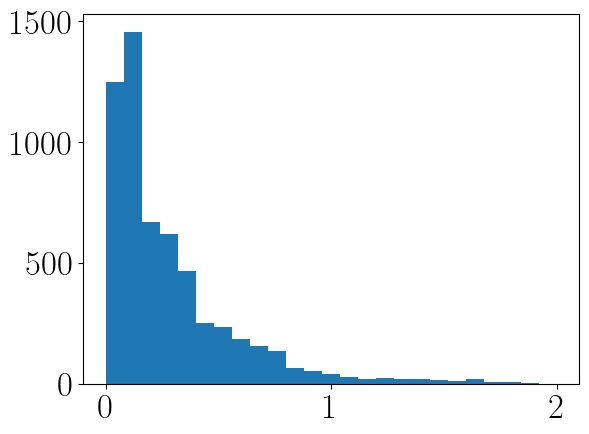

In [50]:
plt.hist(new_err,bins=25,range=(0,2))

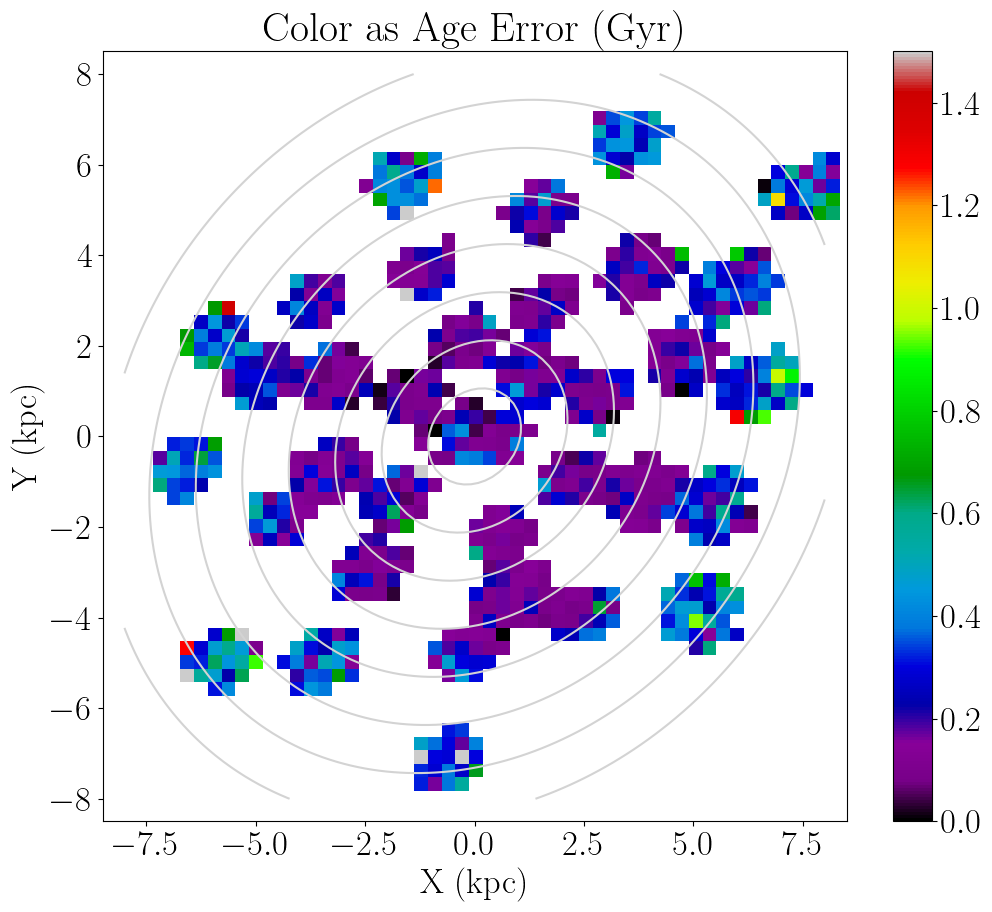

In [51]:
plt.figure(figsize=[12,10])

xx,yy = np.meshgrid(np.linspace(-8,8,100),np.linspace(-8,8,100))
CS = plt.contour(xx,yy,elliptical_radius(xx,yy),levels=[1,2,3,4,5,6,7,8],colors='lightgrey')

ret = binned_statistic_2d(lmcx,lmcy,new_err,'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='nipy_spectral',vmin=0,vmax=1.5)
plt.colorbar()

plt.xlim(-8.5,8.5)
plt.ylim(-8.5,8.5)

plt.title(r'Color as Age Error (Gyr)')
plt.xlabel(r'X (kpc)')
plt.ylabel(r'Y (kpc)')
# plt.savefig('lmc_map_distance.png',dpi=300,bbox_inches='tight')
plt.show()

(-8.5, 8.5)

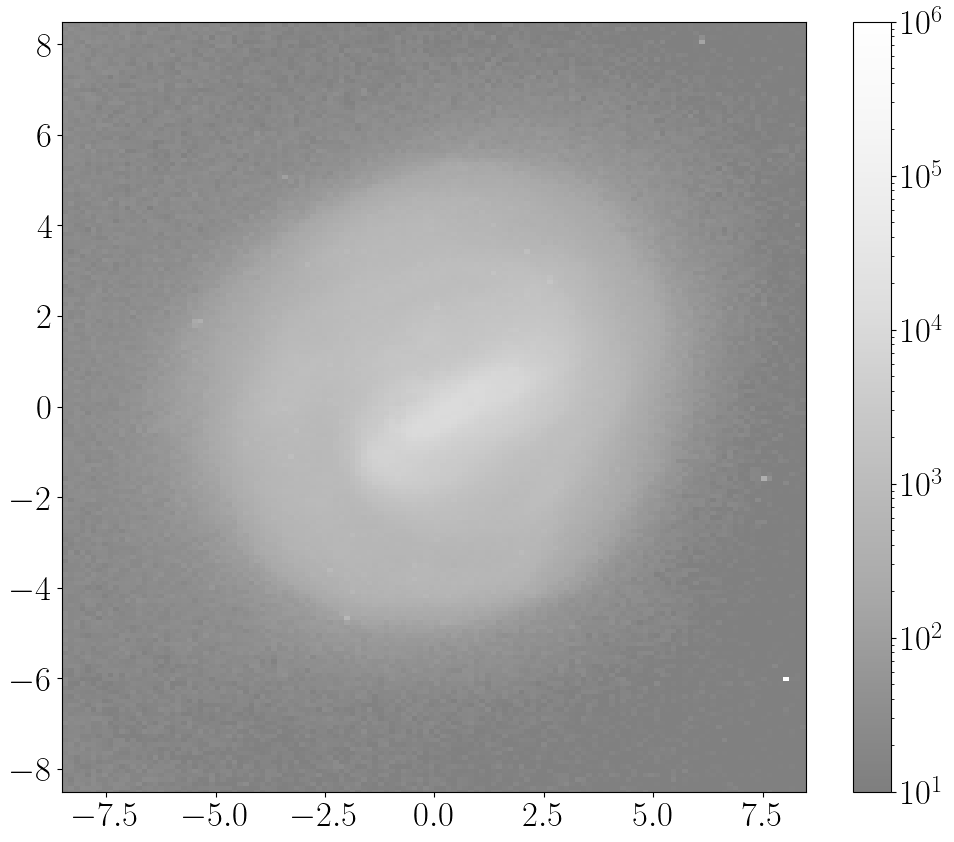

In [52]:
ret = binned_statistic_2d(gaiax,gaiay,gaiax,'count',bins=1000)
ret.statistic[ret.statistic==0] = np.nan

plt.figure(figsize=[12,10])
im  = plt.imshow(ret.statistic.T, origin='lower',
             extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
             aspect='auto',interpolation='nearest',cmap='Greys_r',alpha=0.5,norm=LogNorm(vmin=10**1,vmax=10**6))
plt.colorbar()
plt.xlim(-8.5,8.5)
plt.ylim(-8.5,8.5)

In [53]:
np.nanmax(lmcdr17['LMCRAD'])

11.097992

In [54]:
# fig, ax = plt.subplots(1,2,figsize=[24,10])

# xx,yy = np.meshgrid(np.linspace(-8,8,100),np.linspace(-8,8,100))
# CS = ax[0].contour(xx,yy,superellipse_radius(xx,yy),levels=[1,2,3,4,5,6,7,8],colors='k')
# #ax[0].clabel(CS,colors='k',fontsize=25,manual=locations)

# # fmt = {}
# # strs = ['1', '2', '3', '4', '5', '6', '7']
# # for l, s in zip(CS.levels, strs):
# #     fmt[l] = s
# # ax[0].clabel(CS, CS.levels[::2], inline=True, fmt=fmt, fontsize=10, manual=locations)

# CS = ax[1].contour(xx,yy,superellipse_radius(xx,yy),levels=[1,2,3,4,5,6,7,8],colors='k')
# #ax[1].clabel(CS,colors='k',fontsize=25,manual=locations)

# # for i in range(len(clabx)):
# #     ax[0].text(clabx[i]*(1+0.01),0.0,'{}'.format(i+1))

# plt.xlim(-8.5,8.5)
# plt.ylim(-8.5,8.5)

# # set bounds for the plot
# for i in range(1):
#     ax[i].set_xlim(-9,9)
#     ax[i].set_ylim(-9,9)
#     ax[i].set_xlabel(r'X (kpc)')
#     ax[i].set_ylabel(r'Y (kpc)')

#     ax[i].set_xticks([-8,-4.0,0,4.0,8])
#     ax[i].set_yticks([-8,-4.0,0,4.0,8])

# # convert 0.8 deg diameter to points and calculate the marker size
# r = 49.9*np.tan(np.radians(0.8/2)) #0.8
# r_ = ax[0].transData.transform([r,0])[0] - ax[0].transData.transform([0,0])[0]
# marker_size = np.pi * r_**2

# pl = ax[0].scatter(cen_xy[:,0],cen_xy[:,1],s=marker_size,c=med_fld_age,edgecolors='k',cmap='copper_r',vmax=13.787)
# plt.colorbar(pl,ax=ax[0])
# pl = ax[1].scatter(cen_xy[:,0],cen_xy[:,1],s=marker_size,c=fld_wgt_avg,edgecolors='k',cmap='copper_r',vmax=13.787)
# plt.colorbar(pl,ax=ax[1])

# ax[0].set_title(r'Raw Median Field Age')
# ax[1].set_title(r'Corrected Median Field Age')

# ax[1].set_xlabel(r'X (kpc)')
# ax[1].set_ylabel(r'Y (kpc)')

# plt.tight_layout()
# plt.show()

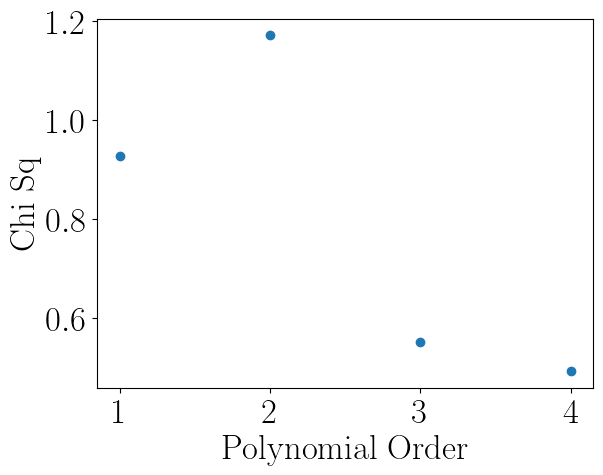

In [55]:
chi_sq = []

sidx = np.argsort(fld_radius)
for i in range(5)[1:]:
    
    p = np.poly1d(robust.polyfit(fld_radius[sidx],fld_wgt_avg[sidx],i))
    
    chi_sq.append(sum(np.square(np.divide(fld_wgt_avg[sidx]-p(fld_radius[sidx]),fld_wgt_avg[sidx])))) #/(len(fld_radius[:-1]-(i+1))))
    
chi_sq = np.array(chi_sq)
    
plt.scatter(range(5)[1:],chi_sq)
plt.xlabel(r'Polynomial Order')
plt.ylabel(r'Chi Sq')
# plt.savefig(r'chisq_age_radius_polyfit.png',bbox_inches='tight')
plt.show()

Raw:          4          3         2
-0.0221 x + 0.2865 x - 1.009 x + 0.9739 x + 3.778
Corr:           4          3         2
-0.03159 x + 0.4015 x - 1.443 x + 1.603 x + 5.452


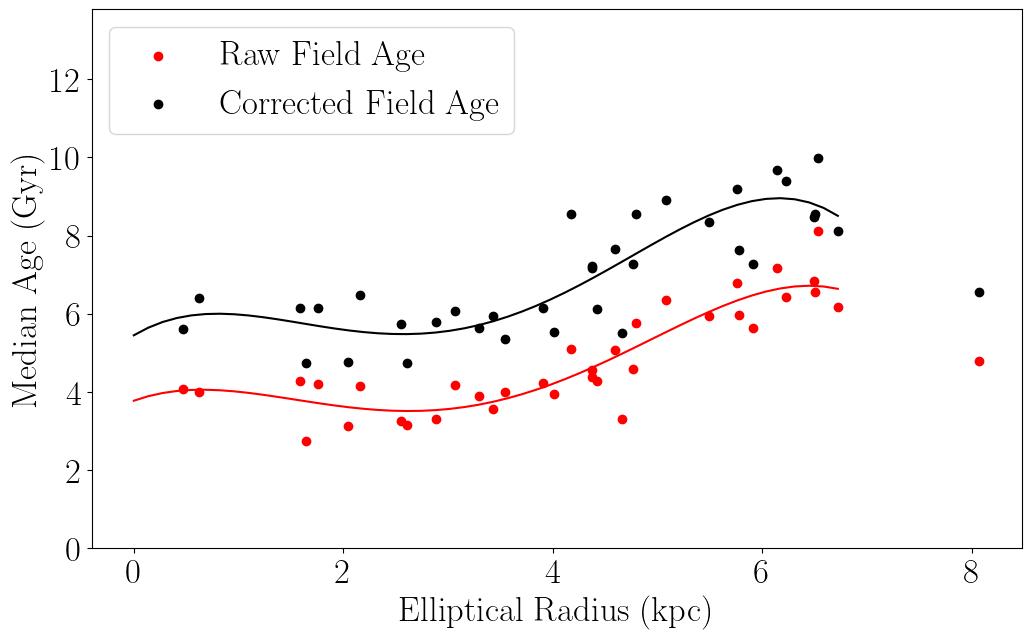

In [56]:
plt.figure(figsize=[12,7])
age_xs = np.linspace(0,max(fld_radius[fld_radius<8]))

plt.plot(age_xs,p_raw(age_xs),c='r')
plt.scatter(fld_radius,med_fld_age,c='r',label='Raw Field Age')

p_corr = np.poly1d(robust.polyfit(fld_radius[fld_radius<8],fld_wgt_avg[fld_radius<8],4))
plt.plot(age_xs,p_corr(age_xs),c='k')
plt.scatter(fld_radius,fld_wgt_avg,c='k',label='Corrected Field Age')

plt.legend(loc='upper left')

plt.ylim(0.,13.787)

plt.xlabel(r'Elliptical Radius (kpc)')
plt.ylabel(r'Median Age (Gyr)')

print('Raw:', p_raw)
print('Corr:', p_corr)

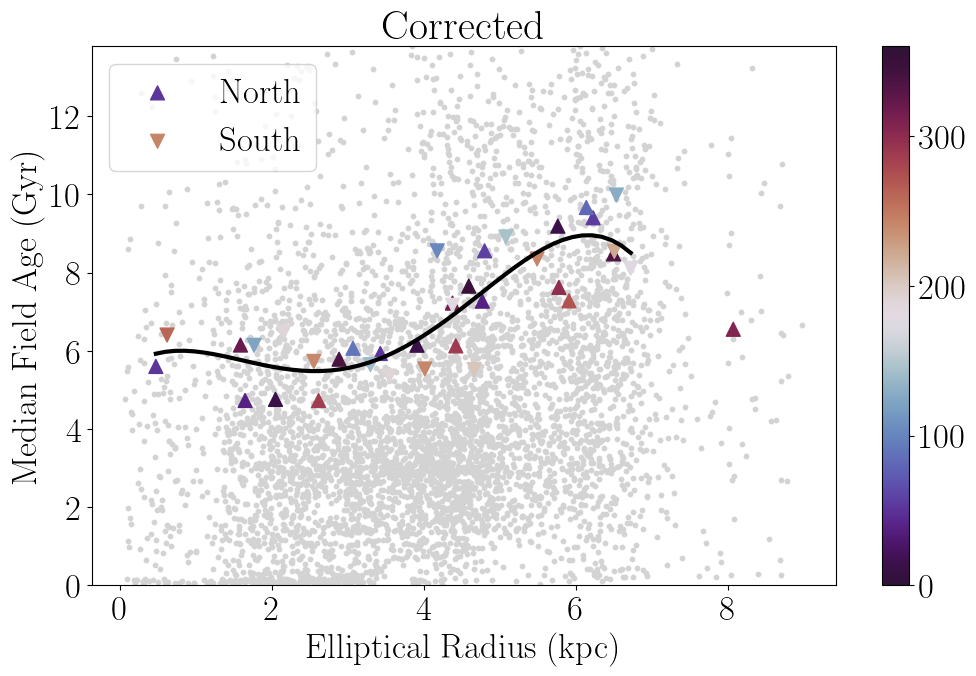

In [57]:
plt.figure(figsize=[12,7])
plt.scatter(lmcr,agetab['AGE'],c='lightgray',s=10)
plt.scatter(fld_radius[north_fld],fld_wgt_avg[north_fld],marker='^',c=fld_pa[north_fld],s=100,label='North',cmap='twilight_shifted',vmin=0,vmax=360)
plt.scatter(fld_radius[south_fld],fld_wgt_avg[south_fld],marker='v',c=fld_pa[south_fld],s=100,label='South',cmap='twilight_shifted',vmin=0,vmax=360)
plt.colorbar()
plt.legend()
xs_rads = np.linspace(min(fld_radius[np.argsort(fld_radius)][:-1]),max(fld_radius[np.argsort(fld_radius)][:-1]))
plt.plot(xs_rads,p_corr(xs_rads),c='k',lw=3)
plt.ylim(0,13.787)
plt.title(r'Corrected')
plt.xlabel(r'Elliptical Radius (kpc)')
plt.ylabel(r'Median Field Age (Gyr)')
# plt.savefig('lmc_fld_age_radius_w_poly.png',bbox_inches='tight')
plt.show()

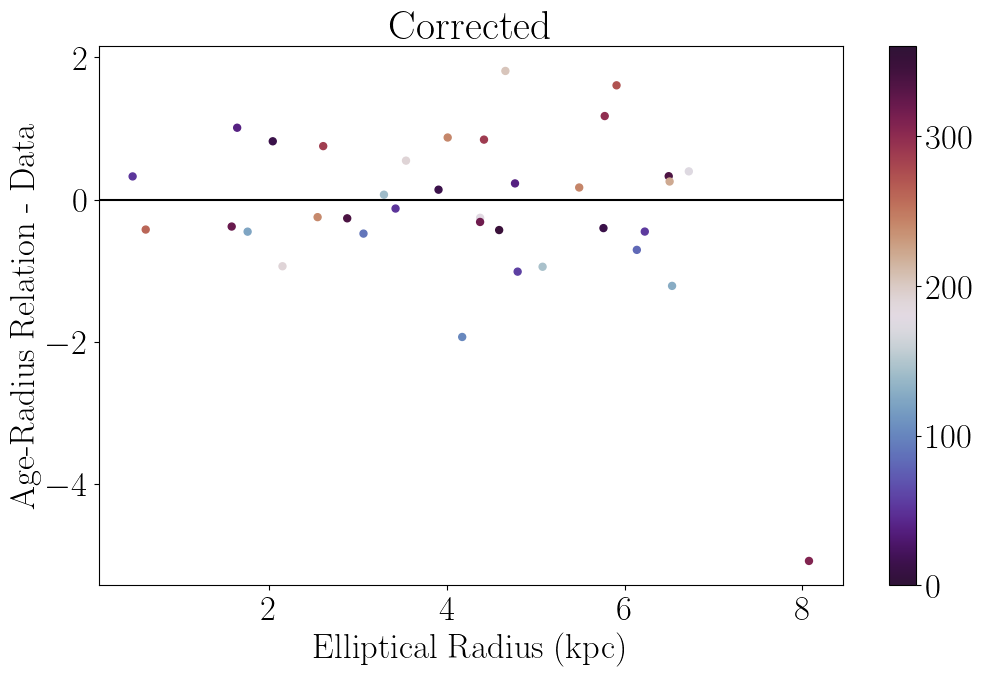

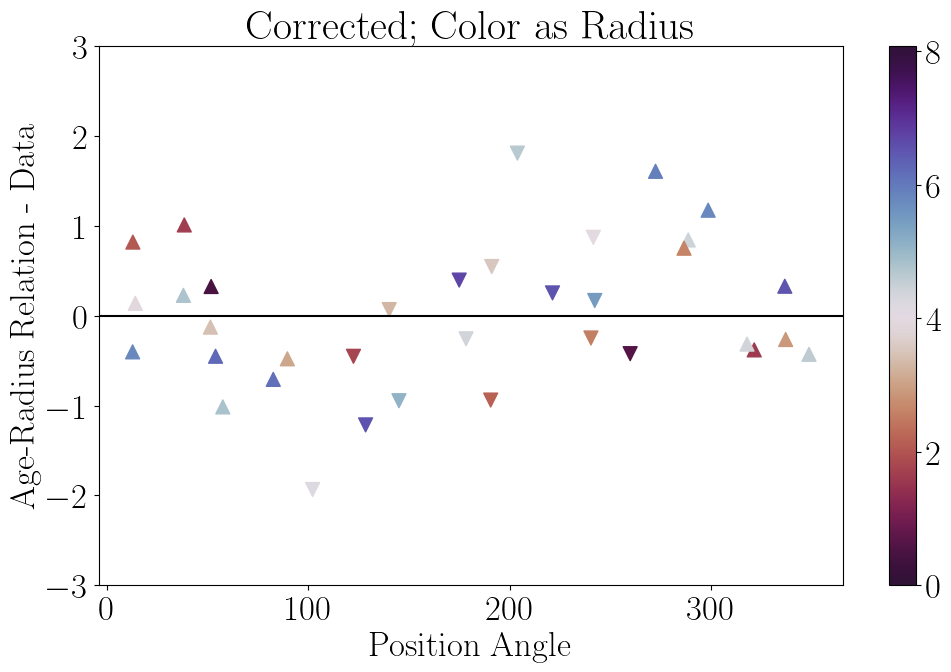

In [58]:
corr_res_fld_age = p_corr(fld_radius)-fld_wgt_avg

plt.figure(figsize=[12,7])
plt.scatter(fld_radius,corr_res_fld_age,c=fld_pa,marker='.',s=100,cmap='twilight_shifted',vmin=0,vmax=360)
plt.colorbar()
plt.axhline(0.0,c='k')

plt.title(r'Corrected')
plt.xlabel(r'Elliptical Radius (kpc)')
plt.ylabel(r'Age-Radius Relation - Data')
plt.show()

plt.figure(figsize=[12,7])
plt.scatter(fld_pa[north_fld],corr_res_fld_age[north_fld],c=fld_radius[north_fld],marker='^',s=100,cmap='twilight_shifted_r',vmin=0,vmax=max(fld_radius),label='North')
plt.scatter(fld_pa[south_fld],corr_res_fld_age[south_fld],c=fld_radius[south_fld],marker='v',s=100,cmap='twilight_shifted_r',vmin=0,vmax=max(fld_radius),label='South')
plt.colorbar()
# plt.legend()
plt.axhline(0.0,c='k')
plt.ylim(-3,3)
plt.title(r'Corrected; Color as Radius')
plt.xlabel(r'Position Angle')
plt.ylabel(r'Age-Radius Relation - Data')
plt.show()

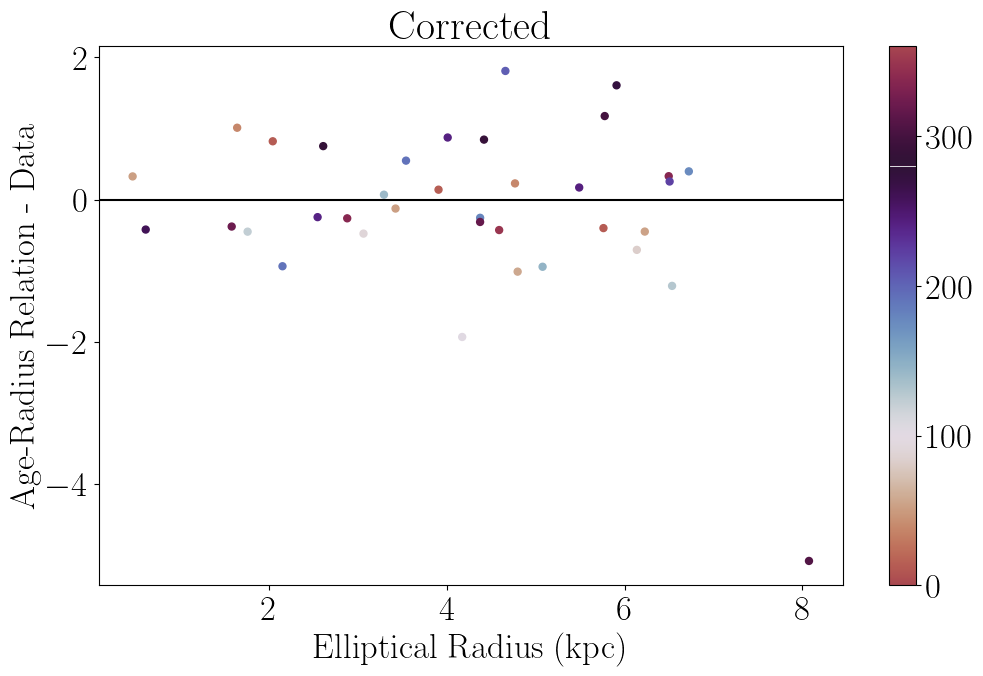

In [59]:
from matplotlib.colors import LinearSegmentedColormap

class roll_cmap(LinearSegmentedColormap):

    def __init__(self, cmap, shift):
        
        shift = shift/360.

        assert 0. < shift < 1.
        self.cmap = cmap
        self.N = cmap.N
        self.monochrome = self.cmap.monochrome
        self._x = np.linspace(0.0, 1.0, 255)
        self._y = np.roll(np.linspace(0.0, 1.0, 255),int(255.*shift))

    def __call__(self, xi, alpha=1.0, **kw):
        yi = np.interp(xi, self._x, self._y)
        return self.cmap(yi, alpha)
    
cmap = plt.cm.twilight_shifted_r
cmap_rolled = roll_cmap(cmap, shift=280)
    
corr_res_fld_age = p_corr(fld_radius)-fld_wgt_avg

plt.figure(figsize=[12,7])
plt.scatter(fld_radius,corr_res_fld_age,c=fld_pa,marker='.',s=100,cmap=cmap_rolled,vmin=0,vmax=360)
plt.colorbar()
plt.axhline(0.0,c='k')

plt.title(r'Corrected')
plt.xlabel(r'Elliptical Radius (kpc)')
plt.ylabel(r'Age-Radius Relation - Data')
plt.show()

In [60]:
# plt.figure(figsize=[24,14])
# plt.plot(lmcr[np.argsort(lmcr)][::-1],np.cumsum(lmcdr17['GAIAEDR3_PHOT_G_MEAN_MAG'][np.argsort(lmcr)][::-1]),c='tab:blue',label='G Elliptical')
# plt.plot(lmcr[np.argsort(lmcr)][::-1],np.cumsum(lmcdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][np.argsort(lmcr)][::-1]),c='tab:orange',label='BP Elliptical')
# plt.plot(lmcr[np.argsort(lmcr)][::-1],np.cumsum(lmcdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][np.argsort(lmcr)][::-1]),c='tab:green',label='RP Elliptical')

# plt.plot(lmcsr[np.argsort(lmcsr)][::-1],np.cumsum(lmcdr17['GAIAEDR3_PHOT_G_MEAN_MAG'][np.argsort(lmcsr)][::-1]),c='tab:blue',ls='--',label='G Superellipse')
# plt.plot(lmcsr[np.argsort(lmcsr)][::-1],np.cumsum(lmcdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][np.argsort(lmcsr)][::-1]),c='tab:orange',ls='--',label='BP Superellipse')
# plt.plot(lmcsr[np.argsort(lmcsr)][::-1],np.cumsum(lmcdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][np.argsort(lmcsr)][::-1]),c='tab:green',ls='--',label='RP Superellipse')

# plt.plot(np.sqrt(lmcx**2+lmcy**2)[np.argsort(np.sqrt(lmcx**2+lmcy**2))][::-1],
#          np.cumsum(lmcdr17['GAIAEDR3_PHOT_G_MEAN_MAG'][np.argsort(np.sqrt(lmcx**2+lmcy**2))][::-1]),c='tab:blue',ls=':',label='G Circular')
# plt.plot(np.sqrt(lmcx**2+lmcy**2)[np.argsort(np.sqrt(lmcx**2+lmcy**2))][::-1],
#          np.cumsum(lmcdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][np.argsort(np.sqrt(lmcx**2+lmcy**2))][::-1]),c='tab:orange',ls=':',label='BP Circular')
# plt.plot(np.sqrt(lmcx**2+lmcy**2)[np.argsort(np.sqrt(lmcx**2+lmcy**2))][::-1],
#          np.cumsum(lmcdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][np.argsort(np.sqrt(lmcx**2+lmcy**2))][::-1]),c='tab:green',ls=':',label='RP Circular')

# plt.legend()

# # plt.axhline(0.5*np.nanmax(np.cumsum(lmcdr17['GAIAEDR3_PHOT_G_MEAN_MAG'][np.argsort(lmcr)])))
# # plt.axvline(4.25)
# plt.xlabel(r'Radius (kpc)')
# plt.ylabel(r'Cummulative Brightness')
# plt.show()

In [61]:
# north

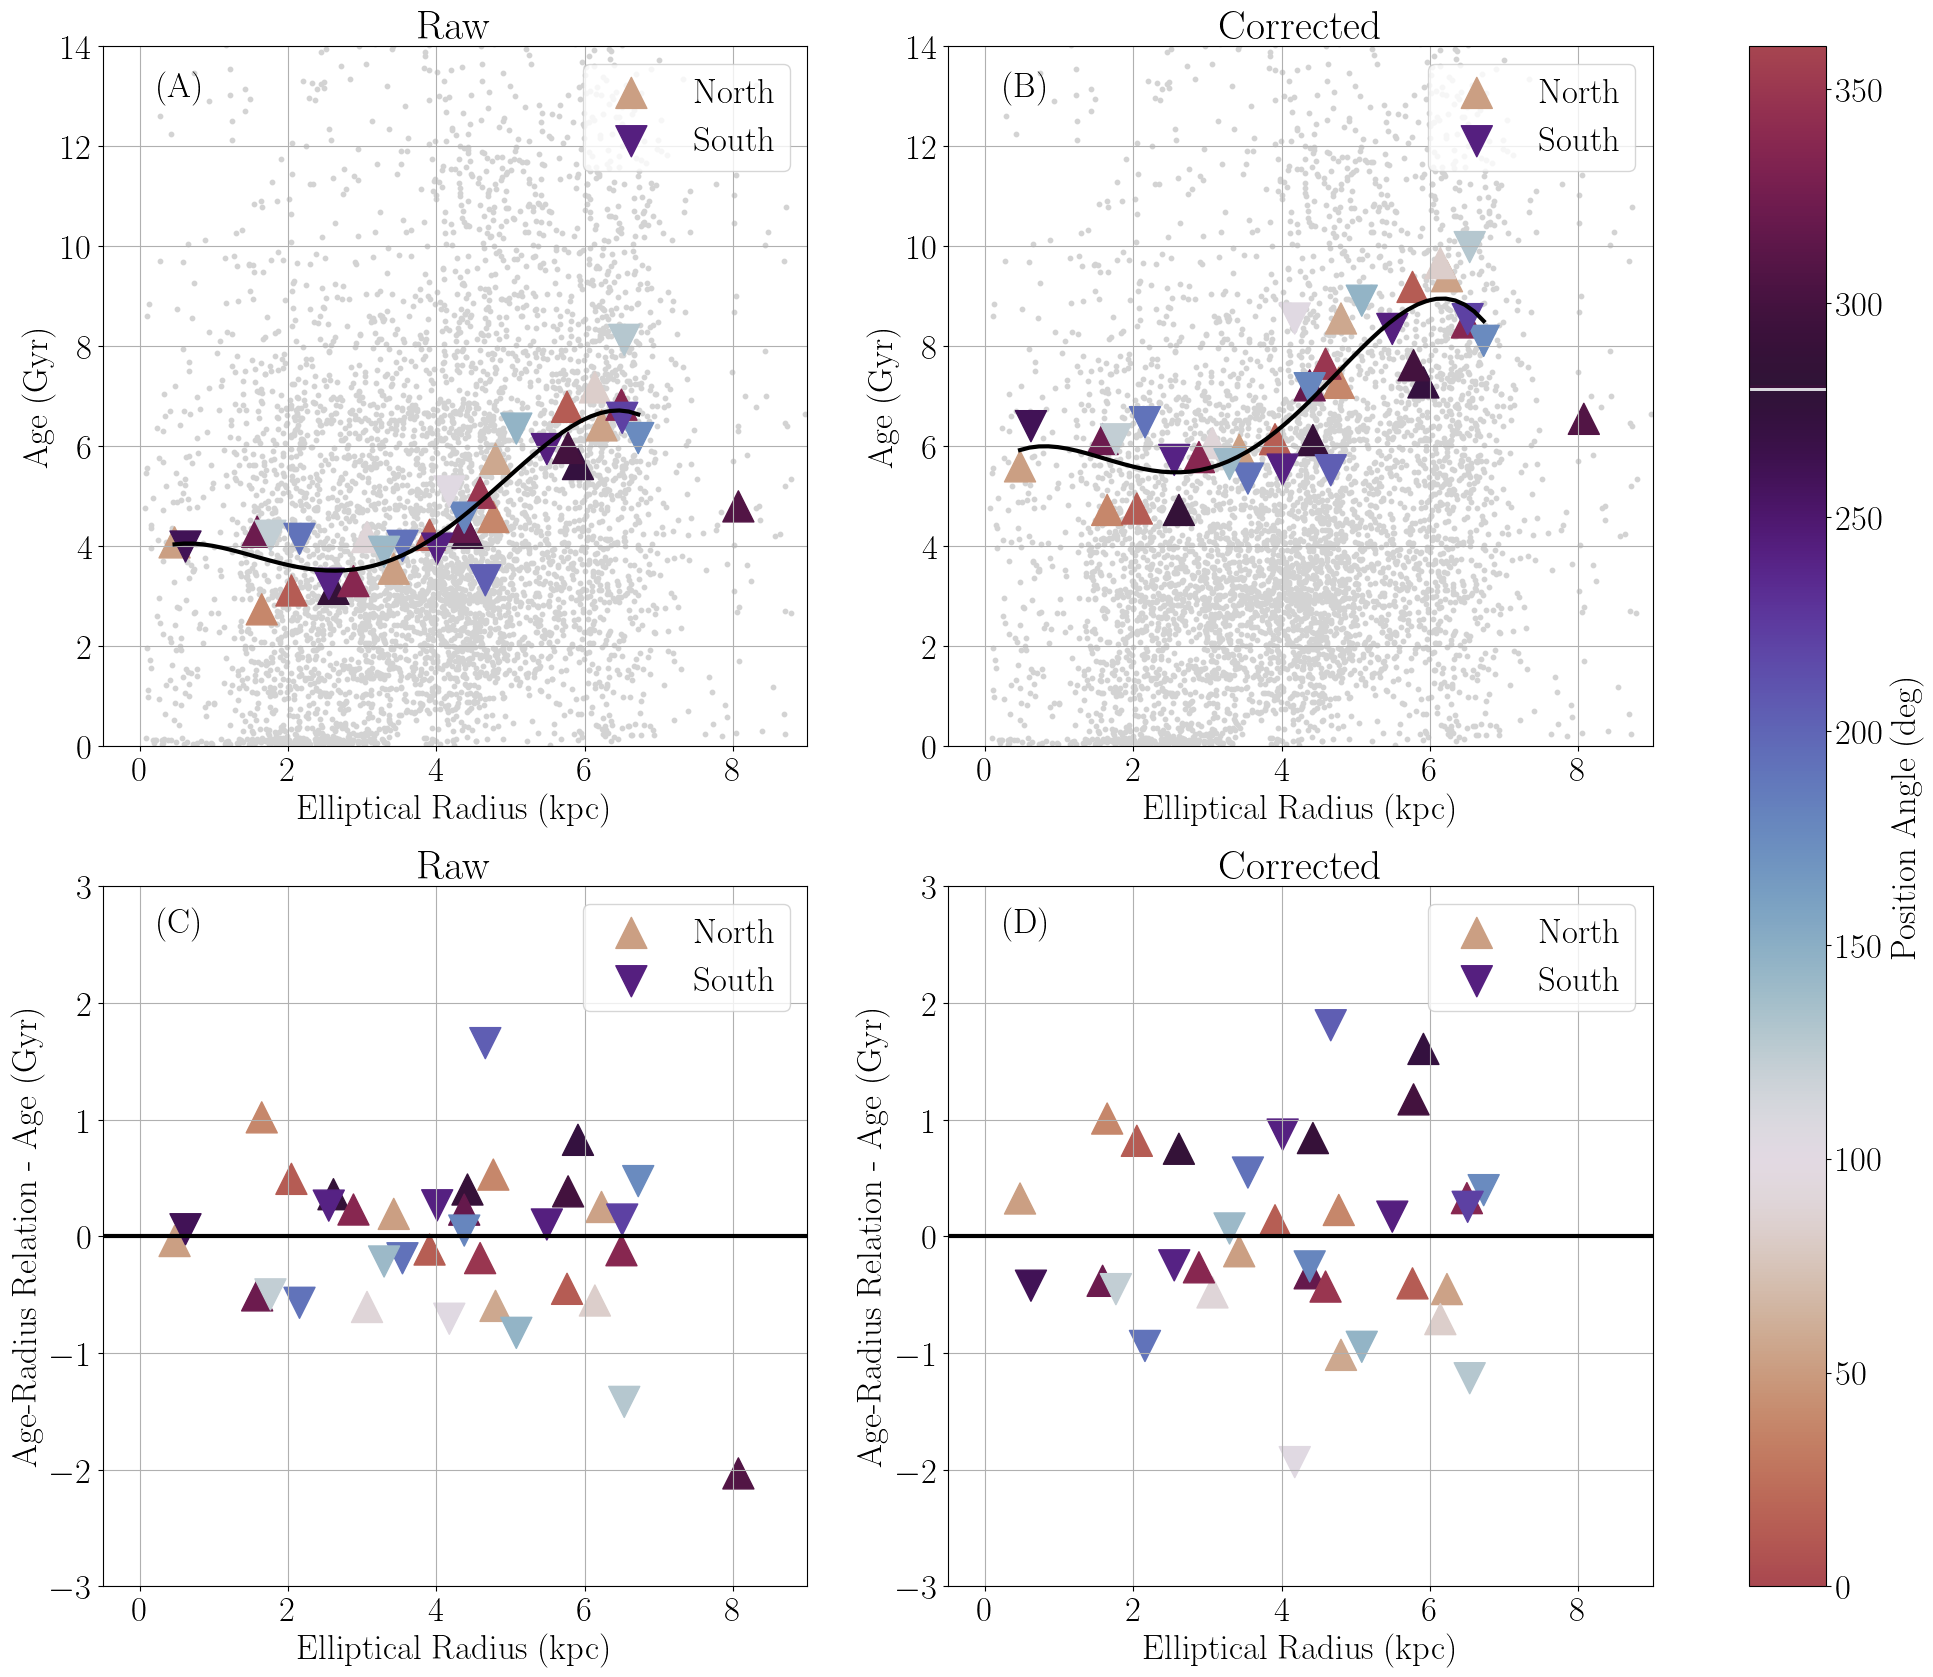

In [164]:
# radii = np.array([fld_raidus[north],])

quad_north_ys = np.array([med_fld_age[north_fld],fld_wgt_avg[north_fld],raw_res_fld_age[north_fld],
                          corr_res_fld_age[north_fld]])
quad_north_xs = np.array([fld_radius[north_fld],fld_radius[north_fld],
                          fld_radius[north_fld],fld_radius[north_fld]])
quad_north_pa = np.array([fld_pa[north_fld],fld_pa[north_fld],fld_pa[north_fld],fld_pa[north_fld]])

quad_south_ys = np.array([med_fld_age[south_fld],fld_wgt_avg[south_fld],raw_res_fld_age[south_fld],
                          corr_res_fld_age[south_fld]])
quad_south_xs = np.array([fld_radius[south_fld],fld_radius[south_fld],
                          fld_radius[south_fld],fld_radius[south_fld]])
quad_south_pa = np.array([fld_pa[south_fld],fld_pa[south_fld],fld_pa[south_fld],fld_pa[south_fld]])

labels = np.array(['A','B','C','D'])

fig,ax = plt.subplots(2,2,figsize=[25,20])
axs = ax.ravel() 

for i in range(len(ax.ravel().tolist())):
    axs[i].grid()
    
    # top plots
    if i < 2:
        axs[i].scatter(lmcr,agetab['AGE'],c='lightgray',s=10)
        axs[i].set_ylim(0,14)#13.787)
        axs[i].set_ylabel(r'Age (Gyr)')
        axs[i].text(0.25,13,r'({})'.format(labels[i]))
        
    if i > 1:
        axs[i].set_ylim(-3,3)
        axs[i].axhline(0,c='k',lw=3.0)
        axs[i].set_ylabel(r'Age-Radius Relation - Age (Gyr)')
        axs[i].text(0.25,2.6,r'({})'.format(labels[i]))
        
    # left column
    if i in [0,2]:
        axs[i].set_title(r'Raw')
    
    # right column
    if i in [1,3]:
        axs[i].set_title(r'Corrected')
        
    axs[i].scatter(quad_north_xs[i],quad_north_ys[i],marker='^',
                          c=quad_north_pa[i],cmap=cmap_rolled,s=500,label='North',vmin=0,vmax=360)
    im = axs[i].scatter(quad_south_xs[i],quad_south_ys[i],marker='v',
                          c=quad_south_pa[i],cmap=cmap_rolled,s=500,label='South',vmin=0,vmax=360)
    
    axs[i].legend(loc='upper right')
    axs[i].set_xlabel(r'Elliptical Radius (kpc)')
    
    axs[i].set_xlim(-0.5,9)
    
axs[0].plot(xs_rads,p_raw(xs_rads),c='k',lw=3)
axs[1].plot(xs_rads,p_corr(xs_rads),c='k',lw=3)

# axs[2].scatter(lmcr,p_raw(lmcr)-agetab['AGE'],zorder=0,c='lightgrey',s=10)
# axs[3].scatter(lmcr,p_corr(lmcr)-agetab['AGE'],zorder=0,c='lightgrey',s=10)
    
plt.colorbar(im,ax=axs,label='Position Angle (deg)')
plt.savefig('lmc_age_radius_sf2.png',bbox_inches='tight')
plt.show()

In [63]:
print(p_raw)

         4          3         2
-0.0221 x + 0.2865 x - 1.009 x + 0.9739 x + 3.778


In [64]:
fld_radius[fld_radius<8],med_fld_age[fld_radius<8]
np.std(p_raw(fld_radius)-med_fld_age)

0.6558428331181473

In [65]:
print(p_corr)

          4          3         2
-0.03159 x + 0.4015 x - 1.443 x + 1.603 x + 5.452


In [66]:
fld_radius[fld_radius<8],med_fld_age[fld_radius<8]
np.std(p_corr(fld_radius)-corr_res_fld_age)

1.479647225442911

In [67]:
# plt.figure(figsize=[12,7])
# plt.scatter(agetab['AGE'],lmcdr17['FE_H'],c='lightgrey',s=10)
# plt.xlim(0,20)
# plt.xlabel(r'Age (Gyr)')
# plt.ylabel(r'[Fe/H]')

In [68]:
feh_upper_carrera = np.array([0.5,-0.25,-0.75,-1.5]) 
feh_lower_carrera = np.array([-0.25,-0.75,-1.5,-3.5])

age_upper_carrera = np.array([2,6,10,13.787]) 
age_lower_carrera = np.array([0,2,6,10])

feh_carrera = np.ones(4)
feh_wid_carrera = np.ones(4)
age_carrera = np.ones(4)
age_wid_carrera = np.ones(4)

for i in range(4):
    feh_carrera[i] = np.mean([feh_upper_carrera[i],feh_lower_carrera[i]])
    feh_wid_carrera[i] = np.diff([feh_upper_carrera[i],feh_lower_carrera[i]])/2
    
    age_carrera[i] = np.mean([age_upper_carrera[i],age_lower_carrera[i]])
    age_wid_carrera[i] = np.diff([age_upper_carrera[i],age_lower_carrera[i]])/2

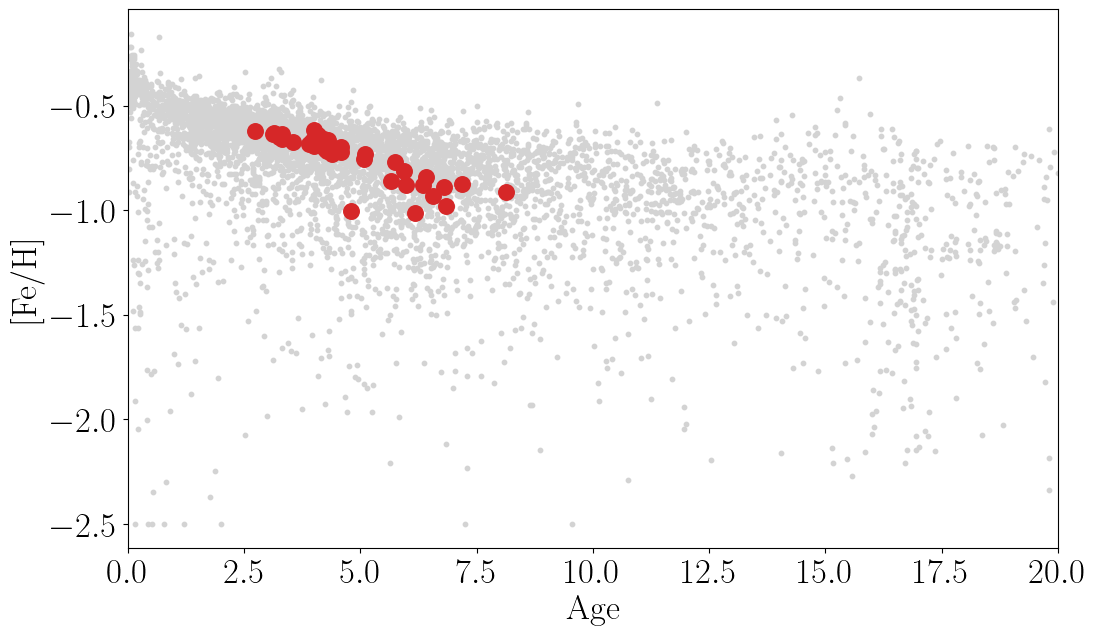

In [69]:
plt.figure(figsize=[12,7])
plt.scatter(agetab['AGE'],lmcdr17['FE_H'],c='lightgray',s=10)
plt.scatter(med_fld_age,fld_feh,c='tab:red',marker='.',s=500)
plt.xlim(0,20)
# xs_rads = np.linspace(min(fld_radius[np.argsort(fld_radius)][:-1]),max(fld_radius[np.argsort(fld_radius)][:-1]))
# plt.plot(xs_rads,p2(xs_rads),c='k',lw=3)
# plt.ylim(0,13)
plt.xlabel(r'Age')
plt.ylabel(r'[Fe/H]')
# plt.savefig('lmc_fld_age_radius_w_poly.png',bbox_inches='tight')
plt.show()


#### 
#### plot star make size mass 
#### maybe sq stellar mass
#### logage instead of linear age?
#### binned values in age or feh?
#### look at carrera paper

Text(0, 0.5, '[Fe/H]')

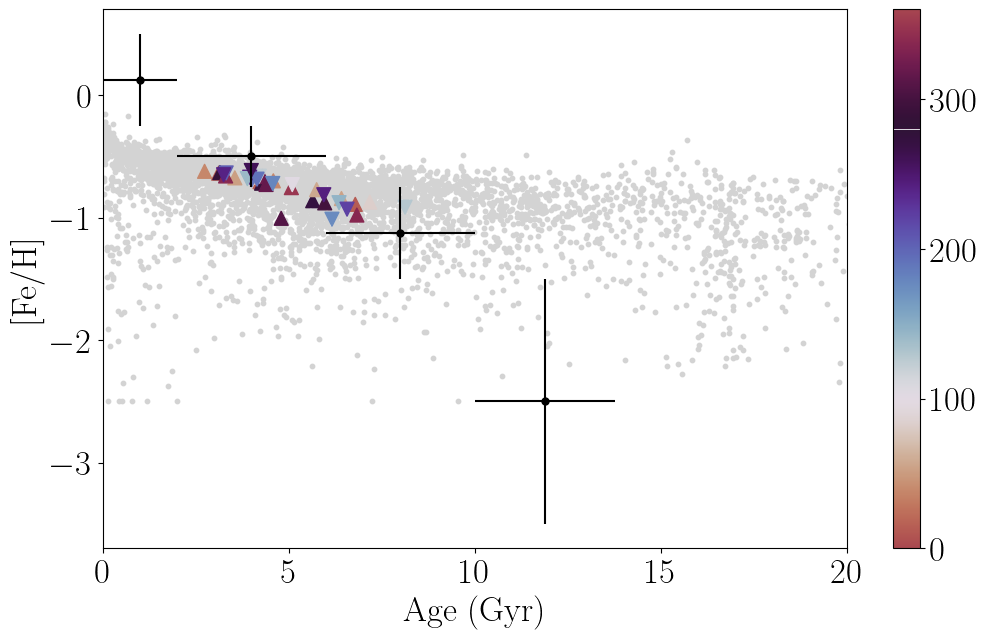

In [70]:
plt.figure(figsize=[12,7])
plt.scatter(agetab['AGE'],lmcdr17['FE_H'],c='lightgrey',s=10)
plt.scatter(age_carrera,feh_carrera,s=25,c='k')
plt.scatter(med_fld_age[north_fld],fld_feh[north_fld],c=fld_pa[north_fld],marker='^',s=100,
            cmap=cmap_rolled,vmin=0,vmax=360)
plt.scatter(med_fld_age[south_fld],fld_feh[south_fld],c=fld_pa[south_fld],marker='v',s=100,
            cmap=cmap_rolled,vmin=0,vmax=360)
plt.errorbar(age_carrera,feh_carrera,xerr=age_wid_carrera,yerr=feh_wid_carrera,ls=' ',c='k')
plt.colorbar()
plt.xlim(0,20)
plt.xlabel(r'Age (Gyr)')
plt.ylabel(r'[Fe/H]')

Text(0, 0.5, '[Fe/H]')

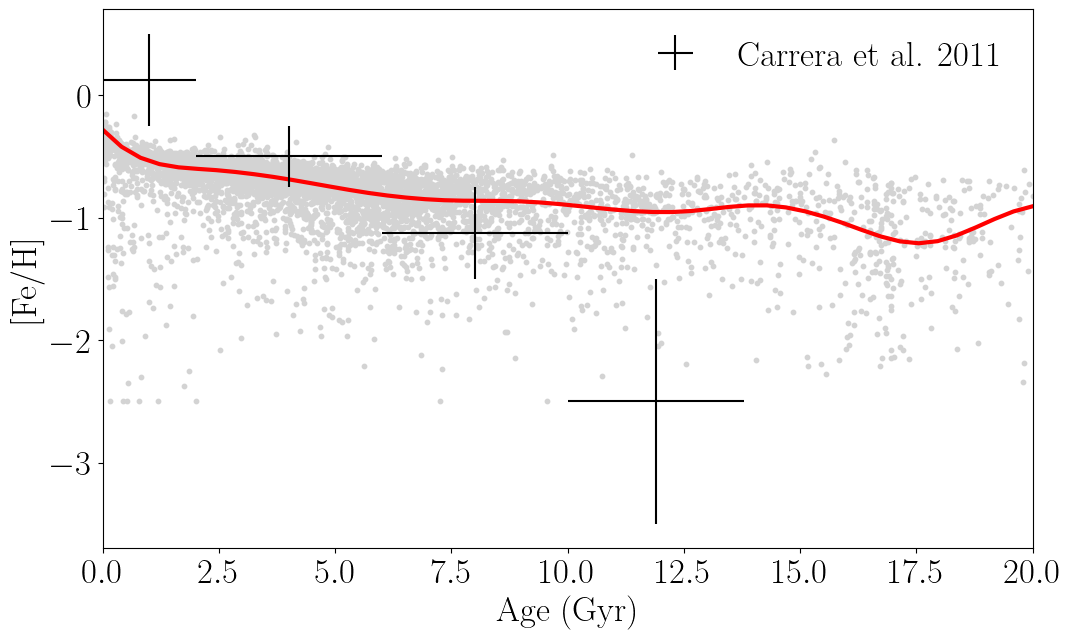

In [71]:
from scipy.stats import binned_statistic
# amr_spl = bspline(agetab['AGE'],lmcdr17['FE_H'])

amr_cut, = np.where((agetab['AGE']<=20.)&(np.isfinite(agetab['AGE'])==True)&(np.isfinite(lmcdr17['FE_H'])==True))

bin_stat,bin_edge,bin_num = binned_statistic(agetab['AGE'][amr_cut],lmcdr17['FE_H'][amr_cut],'median',bins=20)

amr_spl = bspline(bin_edge[:-1]+0.5*np.diff(bin_edge),bin_stat,extrapolate=True)

plt.figure(figsize=[12,7])
plt.scatter(agetab['AGE'],lmcdr17['FE_H'],c='lightgrey',s=10)
# plt.scatter(age_carrera,feh_carrera,s=25,c='k')
plt.plot(np.linspace(0,20),amr_spl(np.linspace(0,20)),c='r',lw=3.)
plt.errorbar(age_carrera,feh_carrera,xerr=age_wid_carrera,yerr=feh_wid_carrera,ls=' ',c='k',
             label='Carrera et al. 2011')
plt.legend(frameon=False)
plt.xlim(0,20)
plt.xlabel(r'Age (Gyr)')
plt.ylabel(r'[Fe/H]')

# plt.axvline(1)

In [72]:
amr_cut, = np.where((agetab['AGE']<=20.)&(np.isfinite(agetab['AGE'])==True)&(np.isfinite(lmcdr17['FE_H'])==True))

bin_stat,bin_edge,bin_num = binned_statistic(agetab['AGE'][amr_cut],lmcdr17['FE_H'][amr_cut],'median',bins=20)

bin_disp = np.ones(len(bin_stat))
for i in range(len(bin_disp)):
    wht_bin, = np.where(bin_num==np.unique(bin_num)[i])
    bin_disp[i] = mad(lmcdr17['FE_H'][amr_cut][wht_bin]) 

amr_spl = bspline(bin_edge[:-1]+0.5*np.diff(bin_edge),bin_stat,extrapolate=True)

# amr_spl(np.linspace(0,20))

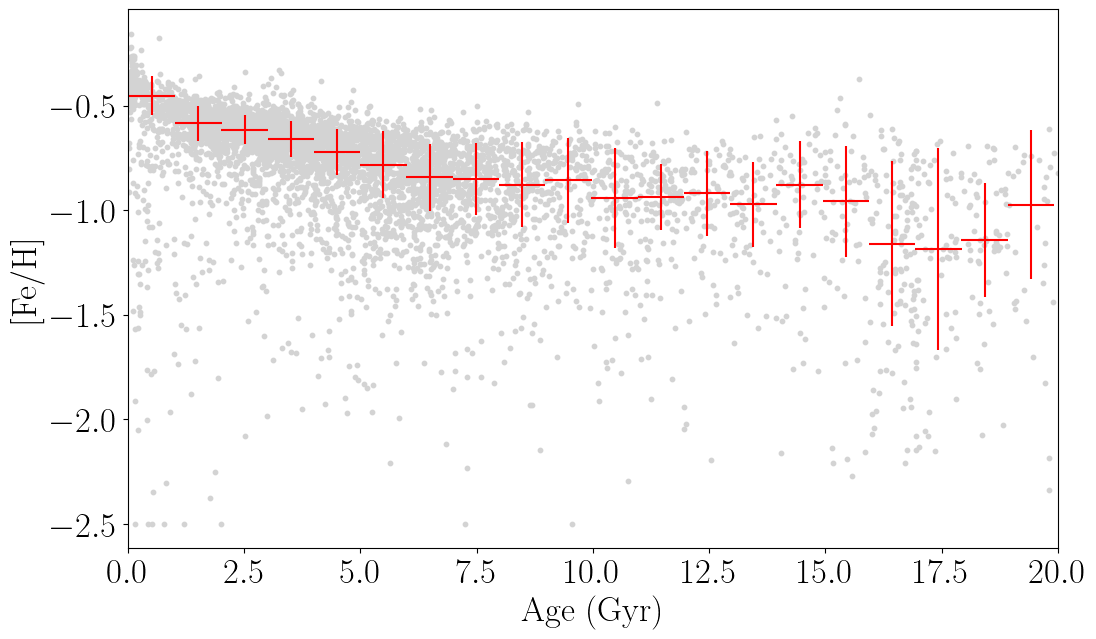

In [73]:
plt.figure(figsize=[12,7])
plt.scatter(agetab['AGE'],lmcdr17['FE_H'],c='lightgrey',s=10)
# plt.plot(np.linspace(0,20),amr_spl(np.linspace(0,20)),c='r',lw=3.)
plt.errorbar(bin_edge[:-1]+0.5*np.diff(bin_edge),bin_stat,xerr=0.5*np.ones(len(bin_stat)),yerr=bin_disp,ls=' ',c='r')
# plt.legend(frameon=False)
# plt.errorbar(age_carrera,feh_carrera,xerr=age_wid_carrera,yerr=feh_wid_carrera,ls=' ',c='k',
#              label='Carrera et al. 2011')
# plt.ylim(-3,0.5)
plt.xlim(0,20)
plt.xlabel(r'Age (Gyr)')
plt.ylabel(r'[Fe/H]')
# plt.savefig('lmc_amr.png',bbox_inches='tight')
plt.show()

In [74]:
# len()

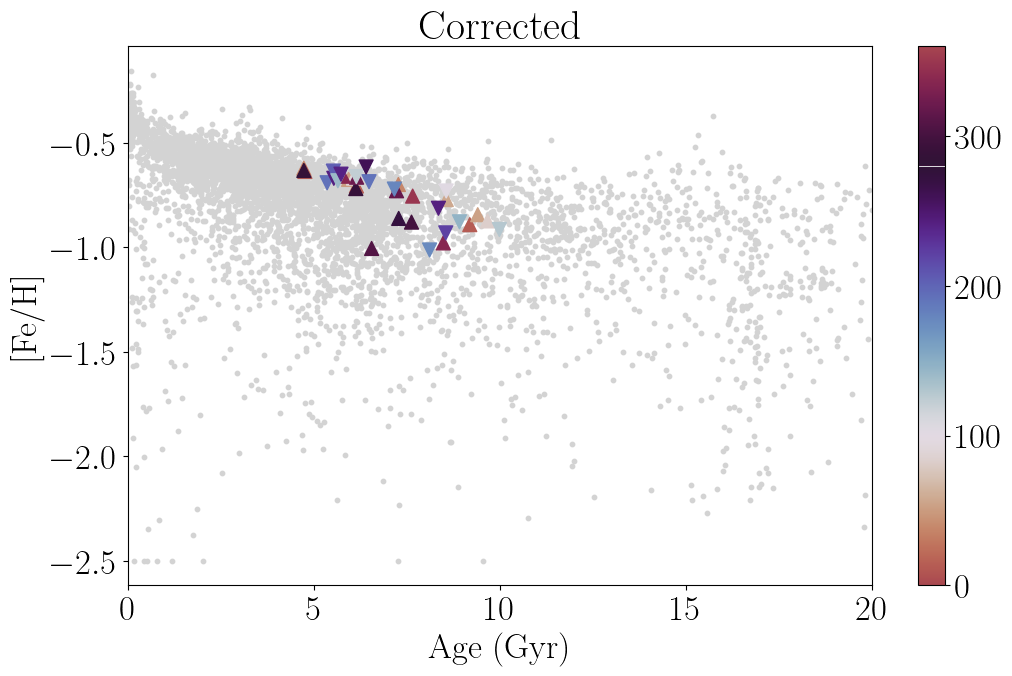

In [75]:
plt.figure(figsize=[12,7])
plt.scatter(agetab['AGE'],lmcdr17['FE_H'],c='lightgrey',s=10)
# plt.scatter(age_carrera,feh_carrera,s=25,c='k')
plt.scatter(fld_wgt_avg[north_fld],fld_feh[north_fld],c=fld_pa[north_fld],marker='^',s=100,
            cmap=cmap_rolled,vmin=0,vmax=360)
plt.scatter(fld_wgt_avg[south_fld],fld_feh[south_fld],c=fld_pa[south_fld],marker='v',s=100,
            cmap=cmap_rolled,vmin=0,vmax=360)
# plt.errorbar(age_carrera,feh_carrera,xerr=age_wid_carrera,yerr=feh_wid_carrera,ls=' ',c='k')
plt.colorbar()
plt.xlim(0,20)
plt.title('Corrected')
plt.xlabel(r'Age (Gyr)')
plt.ylabel(r'[Fe/H]')
# plt.savefig('lmc_amr_corr.png',bbox_inches='tight')
plt.show()

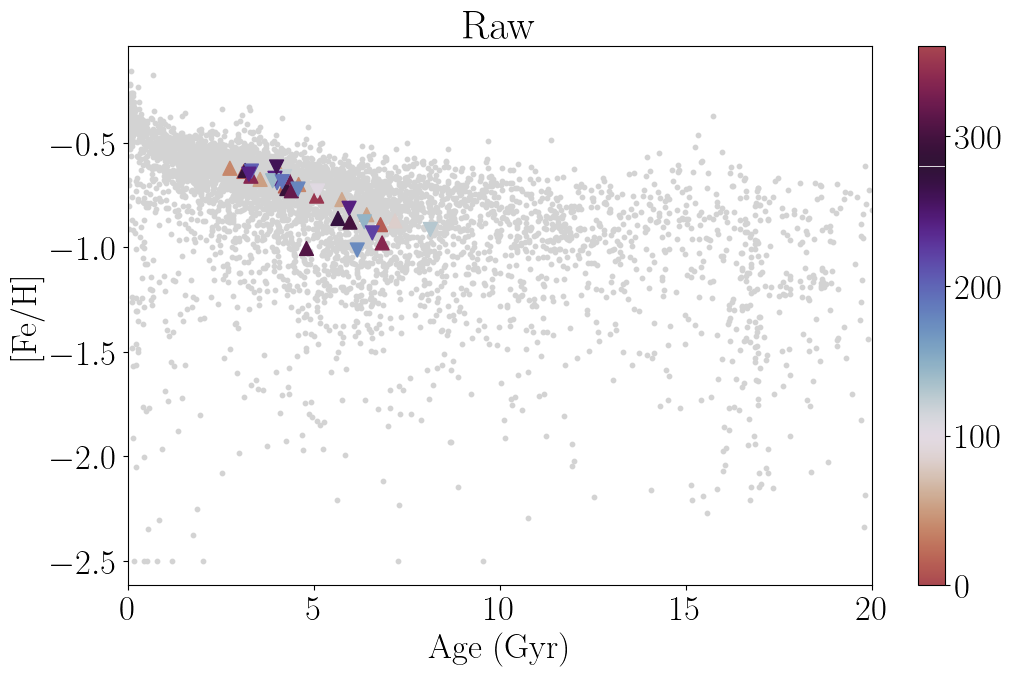

In [76]:
plt.figure(figsize=[12,7])
plt.scatter(agetab['AGE'],lmcdr17['FE_H'],c='lightgrey',s=10)
# plt.scatter(age_carrera,feh_carrera,s=25,c='k')
plt.scatter(med_fld_age[north_fld],fld_feh[north_fld],c=fld_pa[north_fld],marker='^',s=100,
            cmap=cmap_rolled,vmin=0,vmax=360)
plt.scatter(med_fld_age[south_fld],fld_feh[south_fld],c=fld_pa[south_fld],marker='v',s=100,
            cmap=cmap_rolled,vmin=0,vmax=360)
# plt.errorbar(age_carrera,feh_carrera,xerr=age_wid_carrera,yerr=feh_wid_carrera,ls=' ',c='k')
plt.colorbar()
plt.xlim(0,20)
plt.title('Raw')
plt.xlabel(r'Age (Gyr)')
plt.ylabel(r'[Fe/H]')
# plt.savefig('lmc_amr_raw.png',bbox_inches='tight')
plt.show()

# sorted_binned AMR

In [77]:
import pandas as pd

'''@article{harris2009star,
  title={The star formation history of the large magellanic cloud},
  author={Harris, Jason and Zaritsky, Dennis},
  journal={The Astronomical Journal},
  volume={138},
  number={5},
  pages={1243},
  year={2009},
  publisher={IOP Publishing}
}'''

df = pd.read_csv('harris_zaritsky_09_lmc_clusters_table3.csv',skipfooter=6)
df

/var/folders/rc/1rzbdsbd3pb_0pd6mhcfkh2r0000gn/T/ipykernel_15859/3933023042.py:14: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('harris_zaritsky_09_lmc_clusters_table3.csv',skipfooter=6)


Cluster  [Fe/H]  sigma_[Fe/H]  log(Age)  sigma_log(Age)  \
0   Reticulum   -1.66          0.12     10.13            0.05   
1       BRHTb   -0.40          0.00      8.00            0.00   
2      ESO121   -0.97          0.10      9.96            0.04   
3        R136   -0.40          0.00      7.00            0.00   
4      OHSC33   -1.05          0.20      9.18            0.03   
..        ...     ...           ...       ...             ...   
84   NGC 2257   -1.63          0.21     10.20            0.10   
85  NGC 2213    -0.70          0.10      9.23            0.04   
86   NGC 2214   -0.20          0.20      8.00            0.00   
87   NGC 2249   -0.45          0.10      9.35            0.03   
88   NGC 2257   -1.63          0.21     10.20            0.10   

                  Reference           Notes  
0   Mackey & Gilmore (2004)               a  
1      Piatti et al. (2003)              bc  
2      Mackey et al. (2006)   sdotsdotsdot   
3      Hunter et al. (1995)              bc  
4        Bica et al. (1998)   sdotsdotsdot   
..                      ...             ...  
84     Dirsch et al. (2000)   sdotsdotsdot   
85     Kerber et al. (2007)               e  
86  Sagar & Richtler (1991)               c  
87     Kerber et al. (2007)    sdotsdotsdot  
88     Dirsch et al. (2000)   sdotsdotsdot   

[89 rows x 7 columns]

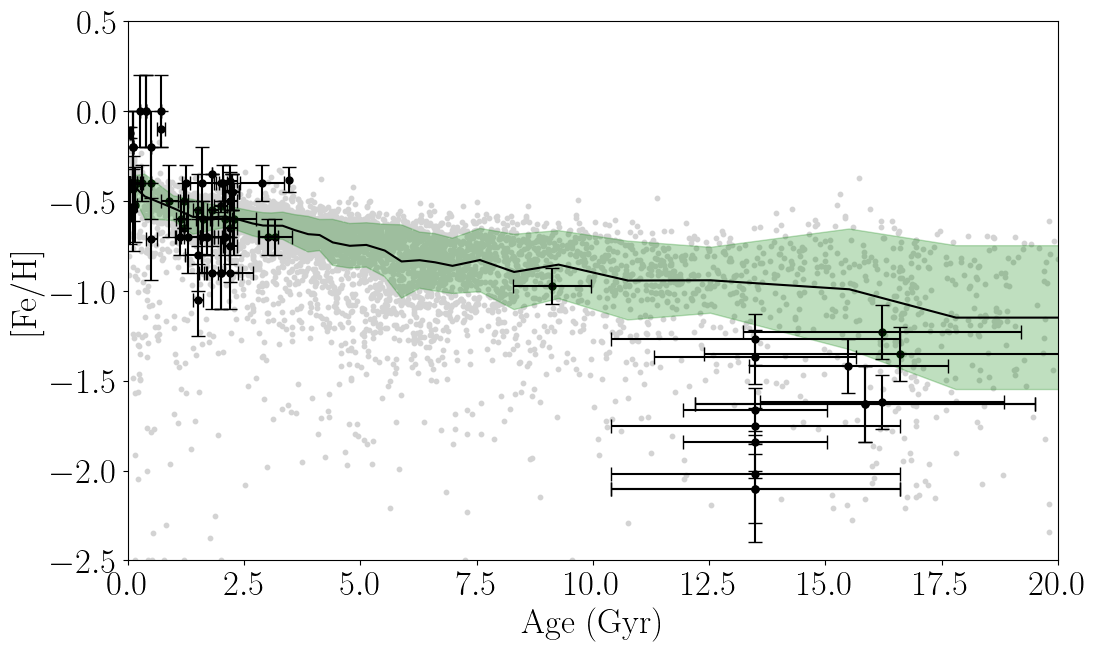

In [78]:
sidx = np.argsort(agetab['AGE'])

nbins = 200
chunks = np.array_split(sidx, len(sidx)/nbins)

binned_feh = 999999.0*np.ones(len(chunks))
binned_feh_mad = 999999.0*np.ones(len(chunks))
binned_age = 999999.0*np.ones(len(chunks))
binned_age_mad = 999999.0*np.ones(len(chunks))

for i in range(len(chunks)):

    binned_age[i] = np.nanmedian(agetab['AGE'][chunks[i]])
    binned_age_mad[i] = mad(agetab['AGE'][chunks[i]])
    binned_feh[i] = np.nanmedian(lmcdr17['FE_H'][chunks[i]])
    binned_feh_mad[i] = mad(lmcdr17['FE_H'][chunks[i]])
    
plt.figure(figsize=[12,7])
plt.scatter(agetab['AGE'],lmcdr17['FE_H'],c='lightgrey',s=10)
plt.scatter(10**df['log(Age)']/10**9,df['[Fe/H]'],c='k',s=25)
hz09_err = (10**df['log(Age)'])*np.log(10)*df['sigma_log(Age)']/10**9
plt.errorbar(10**df['log(Age)']/10**9,df['[Fe/H]'],c='k',yerr=df['sigma_[Fe/H]'],xerr=hz09_err,ls=' ',capsize=5)
plt.fill_between(binned_age,binned_feh+binned_feh_mad,binned_feh-binned_feh_mad,alpha=0.25,color='green')
plt.plot(binned_age,binned_feh,c='k')
plt.xlim(0,20)
plt.ylim(-2.5,0.5)
plt.xlabel(r'Age (Gyr)')
plt.ylabel(r'[Fe/H]')
plt.savefig('lmc_amr_numbin_clus.png',bbox_inches='tight')
plt.show()

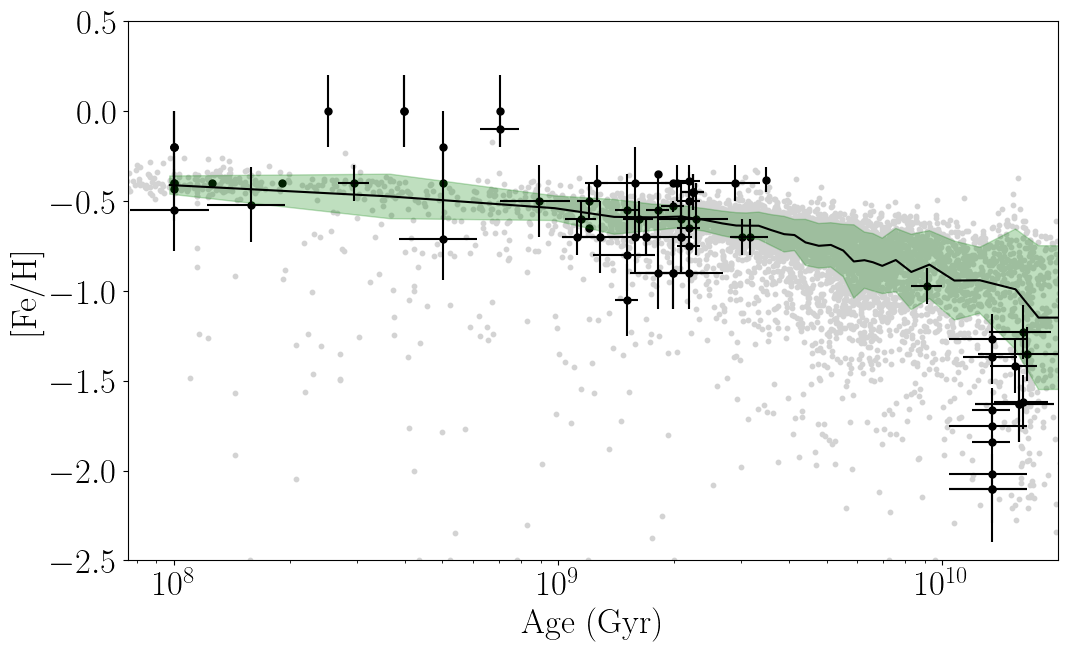

In [79]:
plt.figure(figsize=[12,7])
plt.scatter(agetab['AGE']*10**9,lmcdr17['FE_H'],c='lightgrey',s=10)
plt.scatter(10**df['log(Age)'],df['[Fe/H]'],c='k',s=25)
hz09_err = (10**df['log(Age)'])*np.log(10)*df['sigma_log(Age)']
plt.errorbar(10**df['log(Age)'],df['[Fe/H]'],c='k',yerr=df['sigma_[Fe/H]'],xerr=hz09_err,ls=' ')#,capsize=5)
plt.fill_between(binned_age*10**9,binned_feh+binned_feh_mad,binned_feh-binned_feh_mad,alpha=0.25,color='green')
plt.plot(binned_age*10**9,binned_feh,c='k')
plt.xlim(10**7.88,10**10.301)
plt.ylim(-2.5,0.5)
plt.xlabel(r'Age (Gyr)')
plt.ylabel(r'[Fe/H]')
plt.xscale('log')
plt.savefig('lmc_amr_numbin_logscale_clus.png',bbox_inches='tight')
plt.show()

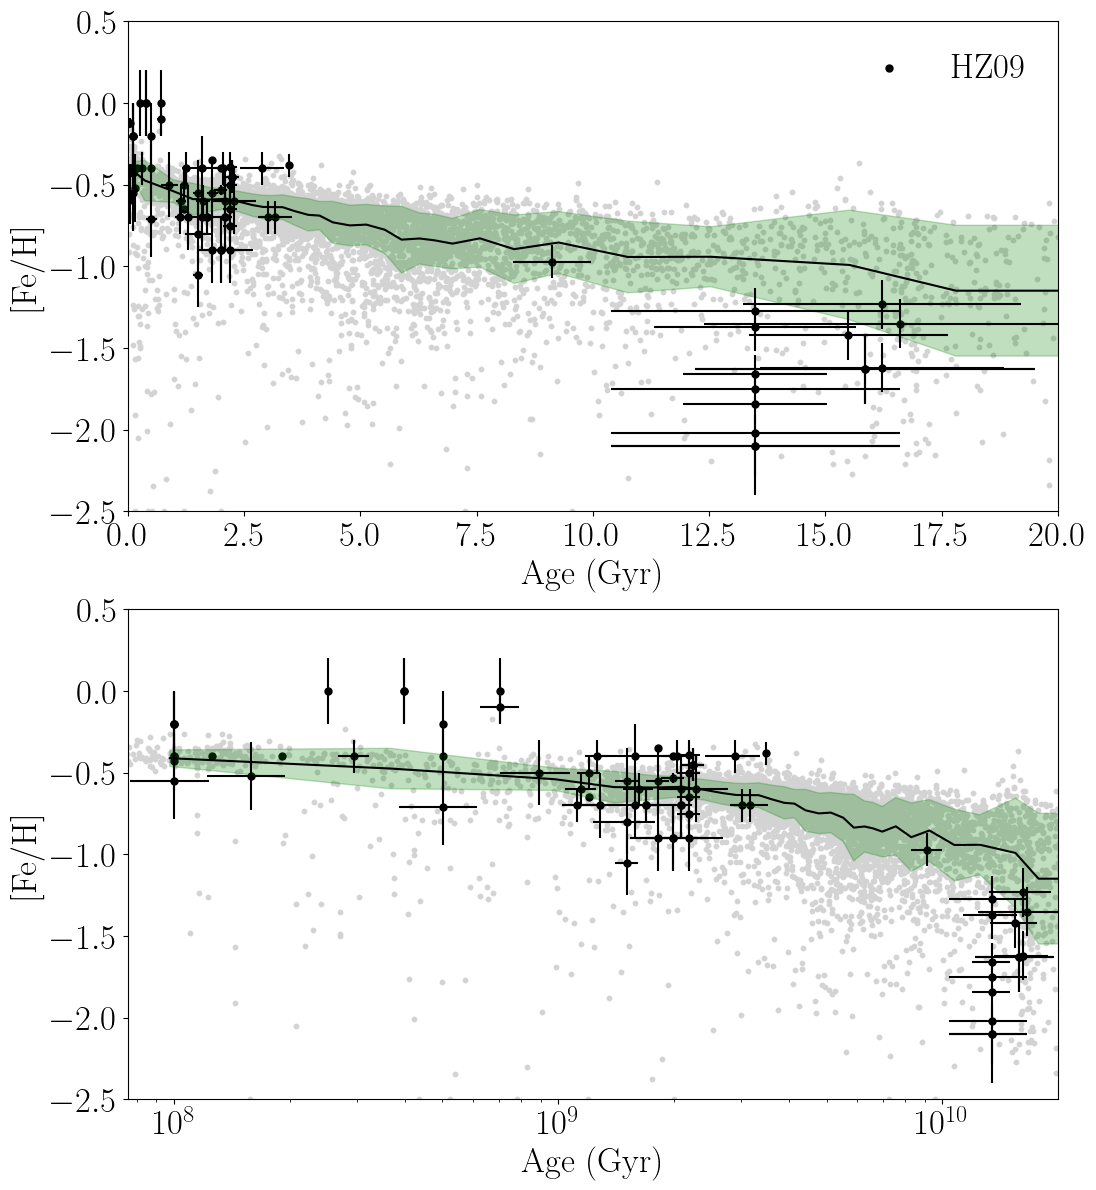

In [163]:
plt.figure(figsize=[12,14])

plt.subplot(211)
plt.scatter(agetab['AGE'],lmcdr17['FE_H'],c='lightgrey',s=10)
plt.scatter(10**df['log(Age)']/10**9,df['[Fe/H]'],c='k',s=25,label='HZ09')
plt.legend(frameon=False)
hz09_err = (10**df['log(Age)'])*np.log(10)*df['sigma_log(Age)']/10**9
plt.errorbar(10**df['log(Age)']/10**9,df['[Fe/H]'],c='k',yerr=df['sigma_[Fe/H]'],xerr=hz09_err,ls=' ')#,capsize=5)
plt.fill_between(binned_age,binned_feh+binned_feh_mad,binned_feh-binned_feh_mad,alpha=0.25,color='green')
plt.plot(binned_age,binned_feh,c='k')
plt.xlim(0,20)
plt.ylim(-2.5,0.5)
plt.xlabel(r'Age (Gyr)')
plt.ylabel(r'[Fe/H]')

plt.subplot(212)
plt.scatter(agetab['AGE']*10**9,lmcdr17['FE_H'],c='lightgrey',s=10)
plt.scatter(10**df['log(Age)'],df['[Fe/H]'],c='k',s=25)
hz09_err = (10**df['log(Age)'])*np.log(10)*df['sigma_log(Age)']
plt.errorbar(10**df['log(Age)'],df['[Fe/H]'],c='k',yerr=df['sigma_[Fe/H]'],xerr=hz09_err,ls=' ')#,capsize=5)
plt.fill_between(binned_age*10**9,binned_feh+binned_feh_mad,binned_feh-binned_feh_mad,alpha=0.25,color='green')
plt.plot(binned_age*10**9,binned_feh,c='k')
plt.xlim(10**7.88,10**10.301)
plt.ylim(-2.5,0.5)
plt.xlabel(r'Age (Gyr)')
plt.ylabel(r'[Fe/H]')
plt.xscale('log')

plt.savefig('lmc_amr_numbin_bothscale_clus.png',bbox_inches='tight')
plt.show()

In [81]:
north = Table.read('region_north_SFH_2.txt',format='ascii')
south = Table.read('region_south_SFH_2.txt',format='ascii')

# plt.plot((north['Age_max']+north['Age_min'])/2.,north['SFR'],label='North')

In [82]:
north.columns

<TableColumns names=('Age_min','Age_max','SFR','err_SFR','SFR_times_area','err_SFR_times_area','Z','err_Z')>

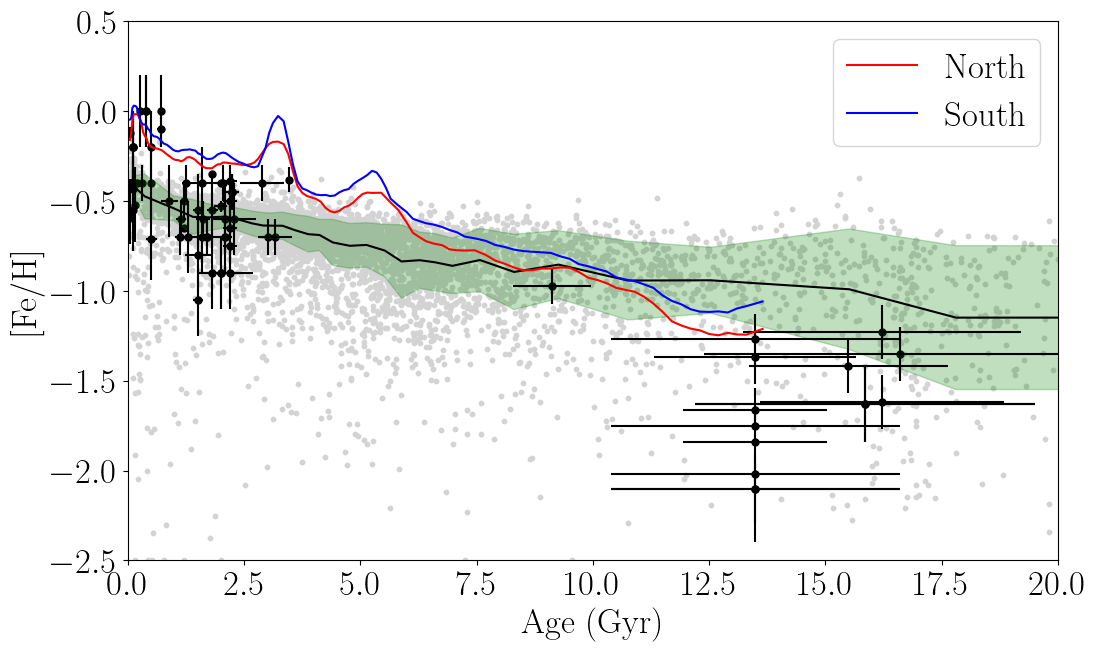

In [83]:
plt.figure(figsize=[12,7])
plt.scatter(agetab['AGE'],lmcdr17['FE_H'],c='lightgrey',s=10)
plt.scatter(10**df['log(Age)']/10**9,df['[Fe/H]'],c='k',s=25)
hz09_err = (10**df['log(Age)'])*np.log(10)*df['sigma_log(Age)']/10**9
plt.errorbar(10**df['log(Age)']/10**9,df['[Fe/H]'],c='k',yerr=df['sigma_[Fe/H]'],xerr=hz09_err,ls=' ')#,capsize=5)
plt.fill_between(binned_age,binned_feh+binned_feh_mad,binned_feh-binned_feh_mad,alpha=0.25,color='green')
plt.plot(binned_age,binned_feh,c='k')

north_err = north['err_Z']/(np.log(10)*north['Z'])
south_err = south['err_Z']/(np.log(10)*south['Z'])

plt.plot((north['Age_max']+north['Age_min'])/2.,np.log10(north['Z']/0.0139),c='r',label='North')
# plt.fill_between((north['Age_max']+north['Age_min'])/2.,np.log10(north['Z']/0.0139)+north_err,np.log10(north['Z']/0.0139)-north_err,alpha=0.25,color='red')
plt.plot((south['Age_max']+south['Age_min'])/2.,np.log10(south['Z']/0.0139),c='b',label='South')
# plt.fill_between((south['Age_max']+south['Age_min'])/2.,np.log10(south['Z']/0.0139)+south_err,np.log10(south['Z']/0.0139)-south_err,alpha=0.25,color='blue')
plt.legend()

plt.xlim(0,20)
plt.ylim(-2.5,0.5)
plt.xlabel(r'Age (Gyr)')
plt.ylabel(r'[Fe/H]')
plt.savefig('lmc_amr_numbin_smash_noband.png',bbox_inches='tight')
plt.show()

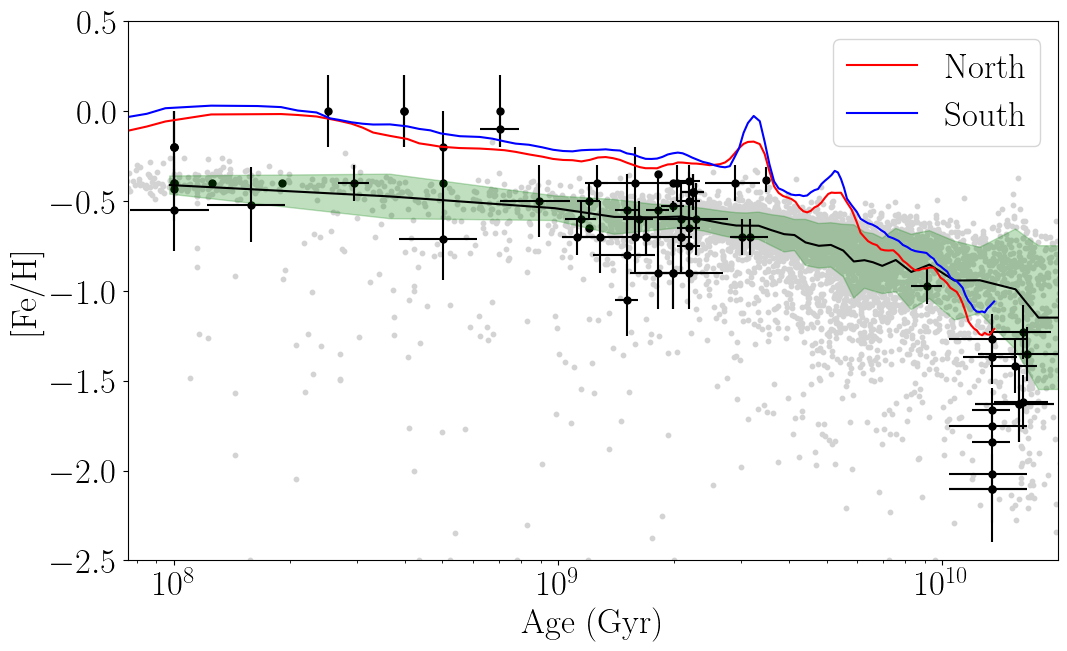

In [84]:
plt.figure(figsize=[12,7])
plt.scatter(agetab['AGE']*10**9,lmcdr17['FE_H'],c='lightgrey',s=10)
plt.scatter(10**df['log(Age)'],df['[Fe/H]'],c='k',s=25)
hz09_err = (10**df['log(Age)'])*np.log(10)*df['sigma_log(Age)']
plt.errorbar(10**df['log(Age)'],df['[Fe/H]'],c='k',yerr=df['sigma_[Fe/H]'],xerr=hz09_err,ls=' ')#,capsize=5)
plt.fill_between(binned_age*10**9,binned_feh+binned_feh_mad,binned_feh-binned_feh_mad,alpha=0.25,color='green')
plt.plot(binned_age*10**9,binned_feh,c='k')

plt.plot(((north['Age_max']+north['Age_min'])/2.)*10**9,np.log10(north['Z']/0.0139),c='r',label='North')
# plt.fill_between(((north['Age_max']+north['Age_min'])/2.)*10**9,np.log10(north['Z']/0.0139)+north_err,np.log10(north['Z']/0.0139)-north_err,alpha=0.25,color='red')
plt.plot(((south['Age_max']+south['Age_min'])/2.)*10**9,np.log10(south['Z']/0.0139),c='b',label='South')
# plt.fill_between(((south['Age_max']+south['Age_min'])/2.)*10**9,np.log10(south['Z']/0.0139)+south_err,np.log10(south['Z']/0.0139)-south_err,alpha=0.25,color='blue')
plt.legend()

plt.xlim(10**7.88,10**10.301)
plt.ylim(-2.5,0.5)
plt.xlabel(r'Age (Gyr)')
plt.ylabel(r'[Fe/H]')
plt.xscale('log')
plt.savefig('lmc_amr_numbin_logscale_smash_noband.png',bbox_inches='tight')
plt.show()

In [85]:
10**((north['Age_max']+north['Age_min'])/2.)

<Column name='Age_max' dtype='float64' length=126>
 1.109174815262401
1.1614486138404765
1.1885022274370185
 1.216186000646368
1.2445146117715284
 1.333521432163324
 1.462177174456718
1.5488166189124815
  1.62181009735893
               ...
1258925411794.1663
1995262314968.8828
3162277660168.3794
 5011872336272.715
 7943282347242.821
12589254117941.662
 19952623149688.83
 44668359215096.35

In [188]:
massive.columns

NameError: name 'massive' is not defined

# Other Clusters

In [139]:
import pandas as pd

'''@article{mackey2003surface,
  title={Surface brightness profiles and structural parameters for 53 rich stellar clusters in the Large Magellanic Cloud},
  author={Mackey⋆, AD and Gilmore, GF},
  journal={Monthly Notices of the Royal Astronomical Society},
  volume={338},
  number={1},
  pages={85--119},
  year={2003},
  publisher={Blackwell Science Ltd Oxford, UK}
}'''

#Rm 1805 and 1818

df2 = pd.read_csv('Mackey_Gilmore_2003.csv')#,names=['NAME','ALT_NAME','RA','DEC','R_OPT','R_ROT','LOG_AGE','LOG_AGE_UPPER','LOG_AGE_LOWER','AGE_REF','METALLICITY','METALLICITY_UPPER','METALLICITY_LOWER','METALLICITY_REF'])
df2

NAME           ALT_NAME           RA              DEC  R_OPT  R_ROT  \
0   'NGC1466'         'SL1, LW1'  '03h44m33s'  '-71d40m18s'   7.89   8.38   
1   'NGC1651'        'SL7, LW12'  '04h37m32s'  '-70d35m06s'   3.77   4.29   
2   'NGC1711'            'SL55'   '04h50m37s'  '-69d59m06s'   2.64   3.17   
3   'NGC1718'             'SL65'  '04h52m25s'  '-67d03m06s'   3.69   4.00   
4   'NGC1754'             'SL91'  '04h54m17s'  '-70d26m30s'   2.43   2.96   
5   'NGC1777'      'SL121, LW96'  '04h55m48s'  '-74d17m00s'   5.10   5.44   
6   'NGC1786'            'SL149'  '04h59m06s'  '-67d44m42s'   2.70   3.02   
7   'NGC1831'     'SL227, LW133'  '05h06m16s'  '-64d55m06s'   4.82   4.85   
8   'NGC1835'            'SL215'  '05h05m05s'  '-69d24m12s'   1.40   1.90   
9   'NGC1841'            'xxxxx'  '04h45m23s'  '-83d59m48s'  14.55  14.78   
10  'NGC1847'            'SL240'  '05h07m08s'  '-68d58m18s'   1.34   1.77   
11  'NGC1850'            'SL261'  '05h08m44s'  '-68d45m36s'   1.32   1.70   
12  'NGC1856'            'SL271'  '05h09m29s'  '-69d07m36s'   1.08   1.53   
13  'NGC1860'            'SL284'  '05h10m39s'  '-68d45m12s'   1.18   1.54   
14  'NGC1866'     'SL319, LW163'  '05h13m39s'  '-65d27m54s'   4.08   4.03   
15  'NGC1868'     'SL330, LW169'  '05h14m36s'  '-63d57m18s'   5.57   5.47   
16  'NGC1898'            'SL350'  '05h16m42s'  '-69d39m24s'   0.41   0.95   
17  'NGC1916'            'SL361'  '05h18m39s'  '-69d24m24s'   0.21   0.72   
18  'NGC1984'            'SL488'  '05h27m40s'  '-69d08m06s'   0.69   0.15   
19  'NGC2004'            'SL523'  '05h30m40s'  '-67d17m12s'   2.38   2.01   
20  'NGC2005'            'SL518'  '05h30m09s'  '-69d45m06s'   0.84   0.58   
21  'NGC2011'            'SL559'  '05h32m19s'  '-67d31m18s'   2.24   1.82   
22  'NGC2019'            'SL554'  '05h31m56s'  '-70d09m36s'   1.16   1.01   
23  'NGC2031'            'SL577'  '05h33m41s'  '-70d59m12s'   1.83   1.82   
24  'NGC2100'            'SL662'  '05h42m08s'  '-69d12m42s'   1.90   1.37   
25  'NGC2121'     'SL725, LW303'  '05h48m12s'  '-71d28m48s'   2.95   2.80   
26  'NGC2136'            'SL762'  '05h53m17s'  '-69d31m42s'   2.83   2.34   
27  'NGC2153'     'SL792, LW341'  '05h57m51s'  '-66d24m00s'   4.81   4.23   
28  'NGC2155'     'SL803, LW347'  '05h58m33s'  '-65d28m36s'   5.59   5.03   
29  'NGC2156'            'SL796'  '05h57m45s'  '-68d27m36s'   3.53   2.96   
30  'NGC2157'            'SL794'  '05h57m34s'  '-69d11m48s'   3.26   2.75   
31  'NGC2159'            'SL799'  '05h57m57s'  '-68d37m24s'   3.48   2.92   
32  'NGC2162'     'SL814, LW351'   06h00m31s'     '-63d43m18s'   7.23   6.69   
33  'NGC2164'            'SL808'  '05h58m54s'  '-68d31m06s'   3.61   3.04   
34  'NGC2172'            'SL812'  '06h00m05s'  '-68d38m12s'   3.66   3.11   
35  'NGC2173'     'SL807, LW348'  '05h57m58s'  '-72d58m42s'   4.43   4.37   
36  'NGC2193'     'SL839, LW387'  '06h06m17s'  '-65d05m54s'   6.48   5.89   
37  'NGC2209'     'SL849, LW408'  '06h08m34s'  '-73d50m30s'   5.48   5.43   
38  'NGC2210'     'SL858, LW423'  '06h11m31s'  '-69d07m18s'   4.52   4.00   
39  'NGC2213'     'SL857, LW419'  '06h10m42s'  '-71d31m42s'   4.44   4.16   
40  'NGC2214'     'SL860, LW426'  '06h12m57s'  '-68d15m36s'   4.97   4.40   
41  'NGC2231'     'SL884, LW466'  '06h20m44s'  '-67d31m06s'   6.04   5.46   
42  'NGC2249'     'SL893, LW479'  '06h25m49s'  '-68d55m12s'   5.86   5.33   
43  'NGC2257'     'SL895, LW481'  '06h30m12s'  '-64d19m36s'   9.10   8.47   
44    'SL663'            'LW273'  '05h42m29s'  '-65d21m48s'   4.69   4.23   
45    'SL842'            'LW399'  '06h08m15s'  '-62d59m18s'   8.43   7.85   
46    'SL855'            'LW420'  '06h10m53s'  '-65d02m36s'   6.88   6.29   
47   'HODGE4'     'SL556, LW237'  '05h31m54s'  '-64d42m00s'   4.92   4.59   
48  'HODGE11'     'SL868, LW437'  '06h14m22s'  '-69d50m54s'   4.62   4.15   
49  'HODG

In [162]:
(2.897771955*10**-3)/300*10**6

9.659239849999999

In [142]:
df2['LOG_AGE_UPPER'][0]

0.01

In [132]:
# asymmetric_error = np.array(list(zip(lower_error, upper_error))).T

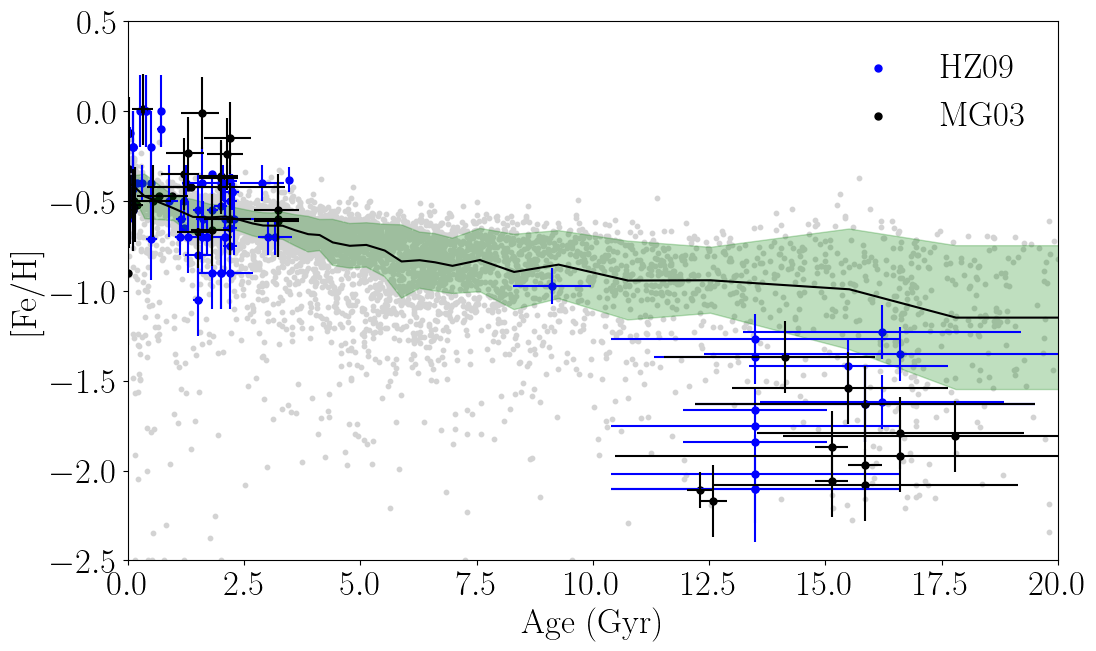

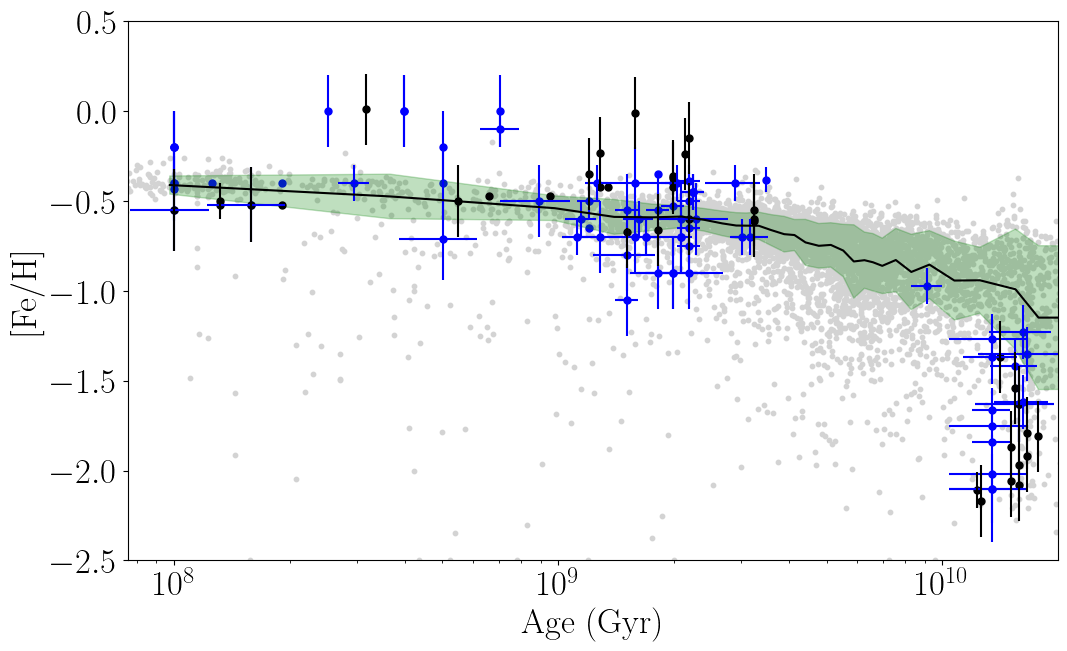

In [159]:
mg03_err_lo = (10**df2['LOG_AGE'])*np.log(10)*df2['LOG_AGE_LOWER']/10**9
mg03_err_hi = (10**df2['LOG_AGE'])*np.log(10)*df2['LOG_AGE_UPPER']/10**9

asym_age_err = np.array(list(zip(mg03_err_lo, mg03_err_hi))).T
asym_feh_err = np.array(list(zip(df2['METALLICITY_LOWER'], df2['METALLICITY_UPPER']))).T

hz09_err = (10**df['log(Age)'])*np.log(10)*df['sigma_log(Age)']/10**9

plt.figure(figsize=[12,7])
plt.scatter(agetab['AGE'],lmcdr17['FE_H'],c='lightgrey',s=10)
plt.scatter(10**df['log(Age)']/10**9,df['[Fe/H]'],c='b',s=25,label='HZ09')
plt.errorbar(10**df['log(Age)']/10**9,df['[Fe/H]'],c='b',yerr=df['sigma_[Fe/H]'],xerr=hz09_err,ls=' ')
plt.scatter(10**df2['LOG_AGE']/10**9,df2['METALLICITY'],c='k',s=25,label='MG03')
plt.legend(frameon=False)
plt.errorbar(10**df2['LOG_AGE']/10**9,df2['METALLICITY'],c='k',yerr=asym_feh_err,xerr=asym_age_err,ls=' ')
plt.fill_between(binned_age,binned_feh+binned_feh_mad,binned_feh-binned_feh_mad,alpha=0.25,color='green')
plt.plot(binned_age,binned_feh,c='k')
plt.xlim(0,20)
plt.ylim(-2.5,0.5)
plt.xlabel(r'Age (Gyr)')
plt.ylabel(r'[Fe/H]')
# plt.savefig('lmc_amr_numbin_clus.png',bbox_inches='tight')
plt.show()

plt.figure(figsize=[12,7])
plt.scatter(agetab['AGE']*10**9,lmcdr17['FE_H'],c='lightgrey',s=10)
plt.scatter(10**df['log(Age)'],df['[Fe/H]'],c='b',s=25)
hz09_err = (10**df['log(Age)'])*np.log(10)*df['sigma_log(Age)']
plt.errorbar(10**df['log(Age)'],df['[Fe/H]'],c='b',yerr=df['sigma_[Fe/H]'],xerr=hz09_err,ls=' ')#,capsize=5)
plt.fill_between(binned_age*10**9,binned_feh+binned_feh_mad,binned_feh-binned_feh_mad,alpha=0.25,color='green')
plt.scatter(10**df2['LOG_AGE'],df2['METALLICITY'],c='k',s=25,label='MG03')
plt.errorbar(10**df2['LOG_AGE'],df2['METALLICITY'],c='k',yerr=asym_feh_err,xerr=asym_age_err,ls=' ')
plt.plot(binned_age*10**9,binned_feh,c='k')
plt.xlim(10**7.88,10**10.301)
plt.ylim(-2.5,0.5)
plt.xlabel(r'Age (Gyr)')
plt.ylabel(r'[Fe/H]')
plt.xscale('log')